In [1]:
from a2c_ppo_acktr.model import Policy
from a2c_ppo_acktr.algo import PPO, A2C_ACKTR
from a2c_ppo_acktr.storage import RolloutStorage
from a2c_ppo_acktr import utils

import torch
import gym
import numpy as np
from collections import deque
from tqdm import tqdm

In [2]:
env = gym.make('CartPole-v0')
env.action_space.shape = (1,)
env.action_space.high = np.array([1])
env.action_space.low = np.array([0])

/home/f1ery/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
actor_critic = Policy(
        (1,),
        env.action_space,
        base_kwargs={'recurrent': False})

In [4]:
class args(object):
    eval_interval = None
    log_interval = 10
    use_gae = False
    num_env_steps = 10e6
    num_steps = 32
    ppo_epoch = 4
    num_mini_batch = 32
    memory_capacity = 32
    value_loss_coef = 0.5
    entropy_coef = 0.01
    lr = 7e-5
    eps = 1e-5
    max_grad_norm = 0.05
    clip_param = 0.05
    alpha = 0.99
    gamma = 0.99
    gae_lambda = 0.95
    use_proper_time_limits = False

In [5]:
agent = A2C_ACKTR(
        actor_critic,
        args.value_loss_coef,
        args.entropy_coef,
        lr=args.lr,
        eps=args.eps,
        alpha=args.alpha,
        max_grad_norm=args.max_grad_norm,
        acktr=False)

In [6]:
memory = RolloutStorage(args.num_steps, 1,
                        (1,), env.action_space,
                        actor_critic.recurrent_hidden_state_size)

In [7]:
episode_rewards = deque(maxlen=10)
value_losses = []
action_losses = []
dist_entropies = []

num_updates = int(args.num_env_steps) // args.num_steps

done = True
episode_reward = 0

for j in range(num_updates):
    memory = RolloutStorage(args.num_steps, 1,
                        (1,), env.action_space,
                        actor_critic.recurrent_hidden_state_size)
    if done:
        state = env.reset()[:1]
        memory.obs[0].copy_(torch.from_numpy(state).float())
        episode_reward = 0
    
    #utils.update_linear_schedule(agent.optimizer, j, num_updates, args.lr)
    for step in range(args.num_steps):
        # Sample actions
        with torch.no_grad():
            value, action, action_log_prob, recurrent_hidden_states = actor_critic.act(
                memory.obs[step], memory.recurrent_hidden_states[step],
                memory.masks[step])
            actual_action = int(action > 0.5)

        # Obser reward and next obs
        state, reward, done, info = env.step(actual_action)
        state = state[:1]

        episode_reward += reward
        
        # If done then clean the history of observations.
        mask = torch.FloatTensor([[1 - float(done)]])
        bad_mask = torch.FloatTensor([[1 - float('bad_transition' in info.keys())]])
        memory.insert(torch.from_numpy(state).float(), recurrent_hidden_states, action,
                        action_log_prob, value, torch.FloatTensor([[reward]]), mask, bad_mask)
        if done:
            episode_rewards.append(episode_reward)
            break
    
    with torch.no_grad():
        next_value = actor_critic.get_value(
            memory.obs[-1], memory.recurrent_hidden_states[-1],
            memory.masks[-1]).detach()

    memory.compute_returns(next_value, args.use_gae, args.gamma,
                           args.gae_lambda, args.use_proper_time_limits)
    
    value_loss, action_loss, dist_entropy = agent.update(memory)
    value_losses.append(value_loss)
    action_losses.append(action_loss)
    dist_entropies.append(dist_entropy)
    memory.after_update()
    
    if j % args.log_interval == 0 and len(episode_rewards) > 1:
        eval_rewards = []
        done = True
        for i in tqdm(range(250), desc='Eval'):
            _done = False
            state = env.reset()[:1]
            eval_rewards.append(0)
            while not _done:
                _, action, _, _ = actor_critic.act(torch.from_numpy(state).float().view((1, 1)), None, None)
                action = int(action > 0.5)
                state, reward, _done, _ = env.step(action)
                state = state[:1]
                eval_rewards[-1] += reward
        total_num_steps = (j + 1) * args.num_steps
        print(
            "Updates {}, num timesteps {} \n Last {} training episodes: mean/median reward {:.1f}/{:.1f}, min/max reward {:.1f}/{:.1f}\neval episodes: mean/median reward {:.1f}/{:.1f}, min/max reward {:.1f}/{:.1f}\n"
            .format(j, total_num_steps,
                    len(episode_rewards), np.mean(episode_rewards),
                    np.median(episode_rewards), np.min(episode_rewards),
                    np.max(episode_rewards), np.mean(eval_rewards),
                    np.median(eval_rewards), np.min(eval_rewards),
                    np.max(eval_rewards)))

Eval: 100%|██████████| 250/250 [00:06<00:00, 41.18it/s]


Updates 10, num timesteps 352 
 Last 8 training episodes: mean/median reward 29.4/27.0, min/max reward 13.0/54.0
eval episodes: mean/median reward 22.1/19.5, min/max reward 8.0/60.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 40.48it/s]


Updates 20, num timesteps 672 
 Last 10 training episodes: mean/median reward 21.9/21.0, min/max reward 12.0/38.0
eval episodes: mean/median reward 22.2/18.0, min/max reward 9.0/74.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.40it/s]


Updates 30, num timesteps 992 
 Last 10 training episodes: mean/median reward 27.4/26.0, min/max reward 11.0/59.0
eval episodes: mean/median reward 22.9/19.0, min/max reward 8.0/87.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 38.19it/s]


Updates 40, num timesteps 1312 
 Last 10 training episodes: mean/median reward 28.7/26.0, min/max reward 15.0/56.0
eval episodes: mean/median reward 23.7/20.0, min/max reward 9.0/84.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.89it/s]


Updates 50, num timesteps 1632 
 Last 10 training episodes: mean/median reward 24.7/24.5, min/max reward 9.0/37.0
eval episodes: mean/median reward 22.2/19.0, min/max reward 8.0/102.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.53it/s]


Updates 60, num timesteps 1952 
 Last 10 training episodes: mean/median reward 20.4/17.5, min/max reward 12.0/39.0
eval episodes: mean/median reward 22.8/19.0, min/max reward 8.0/78.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 36.72it/s]


Updates 70, num timesteps 2272 
 Last 10 training episodes: mean/median reward 18.7/17.0, min/max reward 12.0/33.0
eval episodes: mean/median reward 24.7/20.0, min/max reward 9.0/133.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.58it/s]


Updates 80, num timesteps 2592 
 Last 10 training episodes: mean/median reward 21.2/18.0, min/max reward 11.0/38.0
eval episodes: mean/median reward 22.5/19.0, min/max reward 8.0/112.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 40.44it/s]


Updates 90, num timesteps 2912 
 Last 10 training episodes: mean/median reward 18.3/16.5, min/max reward 11.0/38.0
eval episodes: mean/median reward 22.5/18.0, min/max reward 9.0/86.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 42.40it/s]


Updates 100, num timesteps 3232 
 Last 10 training episodes: mean/median reward 27.5/21.5, min/max reward 12.0/54.0
eval episodes: mean/median reward 21.2/19.0, min/max reward 8.0/78.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.83it/s]


Updates 110, num timesteps 3552 
 Last 10 training episodes: mean/median reward 19.5/19.0, min/max reward 11.0/32.0
eval episodes: mean/median reward 22.5/19.0, min/max reward 8.0/85.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 40.21it/s]


Updates 120, num timesteps 3872 
 Last 10 training episodes: mean/median reward 19.0/14.0, min/max reward 9.0/49.0
eval episodes: mean/median reward 22.5/19.0, min/max reward 9.0/88.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 40.97it/s]


Updates 130, num timesteps 4192 
 Last 10 training episodes: mean/median reward 15.2/15.0, min/max reward 9.0/26.0
eval episodes: mean/median reward 22.2/19.0, min/max reward 8.0/72.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 41.12it/s]


Updates 140, num timesteps 4512 
 Last 10 training episodes: mean/median reward 16.8/16.5, min/max reward 9.0/27.0
eval episodes: mean/median reward 21.7/18.0, min/max reward 8.0/77.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 41.12it/s]


Updates 150, num timesteps 4832 
 Last 10 training episodes: mean/median reward 17.6/17.5, min/max reward 9.0/22.0
eval episodes: mean/median reward 22.1/19.0, min/max reward 8.0/97.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 38.65it/s]


Updates 160, num timesteps 5152 
 Last 10 training episodes: mean/median reward 24.8/16.5, min/max reward 11.0/101.0
eval episodes: mean/median reward 23.2/20.0, min/max reward 8.0/110.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 41.57it/s]


Updates 170, num timesteps 5472 
 Last 10 training episodes: mean/median reward 25.4/17.0, min/max reward 11.0/64.0
eval episodes: mean/median reward 21.7/18.0, min/max reward 9.0/77.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 42.57it/s]


Updates 180, num timesteps 5792 
 Last 10 training episodes: mean/median reward 22.5/22.0, min/max reward 12.0/37.0
eval episodes: mean/median reward 21.3/18.5, min/max reward 8.0/86.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 42.73it/s]


Updates 190, num timesteps 6112 
 Last 10 training episodes: mean/median reward 22.3/18.0, min/max reward 15.0/38.0
eval episodes: mean/median reward 20.7/18.0, min/max reward 9.0/57.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.77it/s]


Updates 200, num timesteps 6432 
 Last 10 training episodes: mean/median reward 23.6/23.0, min/max reward 11.0/39.0
eval episodes: mean/median reward 22.8/19.0, min/max reward 9.0/78.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.61it/s]


Updates 210, num timesteps 6752 
 Last 10 training episodes: mean/median reward 26.7/24.0, min/max reward 12.0/53.0
eval episodes: mean/median reward 22.9/20.0, min/max reward 8.0/63.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 38.15it/s]


Updates 220, num timesteps 7072 
 Last 10 training episodes: mean/median reward 16.7/15.0, min/max reward 13.0/24.0
eval episodes: mean/median reward 23.3/19.0, min/max reward 8.0/88.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.62it/s]


Updates 230, num timesteps 7392 
 Last 10 training episodes: mean/median reward 21.3/20.0, min/max reward 13.0/36.0
eval episodes: mean/median reward 22.9/19.0, min/max reward 8.0/70.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 40.87it/s]


Updates 240, num timesteps 7712 
 Last 10 training episodes: mean/median reward 25.9/24.0, min/max reward 12.0/56.0
eval episodes: mean/median reward 21.8/20.0, min/max reward 8.0/82.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 41.66it/s]


Updates 250, num timesteps 8032 
 Last 10 training episodes: mean/median reward 25.5/23.0, min/max reward 9.0/60.0
eval episodes: mean/median reward 21.7/18.0, min/max reward 9.0/76.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 42.41it/s]


Updates 260, num timesteps 8352 
 Last 10 training episodes: mean/median reward 21.6/23.5, min/max reward 9.0/37.0
eval episodes: mean/median reward 21.4/18.5, min/max reward 8.0/59.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 42.61it/s]


Updates 270, num timesteps 8672 
 Last 10 training episodes: mean/median reward 22.5/23.0, min/max reward 10.0/33.0
eval episodes: mean/median reward 20.7/17.0, min/max reward 8.0/85.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.57it/s]


Updates 280, num timesteps 8992 
 Last 10 training episodes: mean/median reward 24.4/26.0, min/max reward 11.0/48.0
eval episodes: mean/median reward 22.8/20.0, min/max reward 8.0/95.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 40.66it/s]


Updates 290, num timesteps 9312 
 Last 10 training episodes: mean/median reward 22.2/23.5, min/max reward 11.0/38.0
eval episodes: mean/median reward 22.2/19.0, min/max reward 8.0/77.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 42.57it/s]


Updates 300, num timesteps 9632 
 Last 10 training episodes: mean/median reward 18.5/17.5, min/max reward 9.0/29.0
eval episodes: mean/median reward 21.0/18.0, min/max reward 9.0/72.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 40.13it/s]


Updates 310, num timesteps 9952 
 Last 10 training episodes: mean/median reward 19.4/20.0, min/max reward 10.0/32.0
eval episodes: mean/median reward 22.6/19.5, min/max reward 8.0/80.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.61it/s]


Updates 320, num timesteps 10272 
 Last 10 training episodes: mean/median reward 27.1/25.0, min/max reward 12.0/39.0
eval episodes: mean/median reward 22.4/18.0, min/max reward 8.0/64.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 41.98it/s]


Updates 330, num timesteps 10592 
 Last 10 training episodes: mean/median reward 14.5/12.0, min/max reward 10.0/27.0
eval episodes: mean/median reward 21.5/17.0, min/max reward 9.0/84.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 43.28it/s]


Updates 340, num timesteps 10912 
 Last 10 training episodes: mean/median reward 21.7/18.5, min/max reward 10.0/53.0
eval episodes: mean/median reward 20.9/17.0, min/max reward 9.0/101.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.45it/s]


Updates 350, num timesteps 11232 
 Last 10 training episodes: mean/median reward 23.6/22.0, min/max reward 15.0/36.0
eval episodes: mean/median reward 22.5/19.0, min/max reward 9.0/78.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.48it/s]


Updates 360, num timesteps 11552 
 Last 10 training episodes: mean/median reward 20.5/18.0, min/max reward 15.0/37.0
eval episodes: mean/median reward 23.0/19.0, min/max reward 8.0/67.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 41.21it/s]


Updates 370, num timesteps 11872 
 Last 10 training episodes: mean/median reward 21.7/20.0, min/max reward 11.0/42.0
eval episodes: mean/median reward 21.7/17.5, min/max reward 9.0/99.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 41.44it/s]


Updates 380, num timesteps 12192 
 Last 10 training episodes: mean/median reward 21.4/20.5, min/max reward 12.0/36.0
eval episodes: mean/median reward 21.6/19.0, min/max reward 9.0/69.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.89it/s]


Updates 390, num timesteps 12512 
 Last 10 training episodes: mean/median reward 24.4/23.5, min/max reward 12.0/44.0
eval episodes: mean/median reward 22.8/18.0, min/max reward 9.0/99.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.39it/s]


Updates 400, num timesteps 12832 
 Last 10 training episodes: mean/median reward 21.5/16.5, min/max reward 10.0/47.0
eval episodes: mean/median reward 22.6/19.0, min/max reward 9.0/65.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 42.16it/s]


Updates 410, num timesteps 13152 
 Last 10 training episodes: mean/median reward 21.3/21.5, min/max reward 11.0/29.0
eval episodes: mean/median reward 21.5/18.0, min/max reward 9.0/63.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 40.16it/s]


Updates 420, num timesteps 13472 
 Last 10 training episodes: mean/median reward 23.4/20.5, min/max reward 13.0/37.0
eval episodes: mean/median reward 22.4/19.0, min/max reward 9.0/82.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.37it/s]


Updates 430, num timesteps 13792 
 Last 10 training episodes: mean/median reward 20.9/18.5, min/max reward 11.0/35.0
eval episodes: mean/median reward 22.6/19.0, min/max reward 9.0/72.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 40.49it/s]


Updates 440, num timesteps 14112 
 Last 10 training episodes: mean/median reward 24.7/23.0, min/max reward 14.0/40.0
eval episodes: mean/median reward 22.4/20.0, min/max reward 9.0/67.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 40.83it/s]


Updates 450, num timesteps 14432 
 Last 10 training episodes: mean/median reward 25.4/20.0, min/max reward 12.0/72.0
eval episodes: mean/median reward 21.8/18.5, min/max reward 10.0/68.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 40.85it/s]


Updates 460, num timesteps 14752 
 Last 10 training episodes: mean/median reward 20.5/19.0, min/max reward 13.0/34.0
eval episodes: mean/median reward 22.0/18.5, min/max reward 9.0/79.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 40.98it/s]


Updates 470, num timesteps 15072 
 Last 10 training episodes: mean/median reward 21.3/17.5, min/max reward 10.0/46.0
eval episodes: mean/median reward 22.1/19.0, min/max reward 9.0/106.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 41.72it/s]


Updates 480, num timesteps 15392 
 Last 10 training episodes: mean/median reward 20.0/17.5, min/max reward 11.0/41.0
eval episodes: mean/median reward 21.3/18.0, min/max reward 9.0/122.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 41.08it/s]


Updates 490, num timesteps 15712 
 Last 10 training episodes: mean/median reward 16.9/16.5, min/max reward 12.0/24.0
eval episodes: mean/median reward 22.1/19.0, min/max reward 8.0/116.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.46it/s]


Updates 500, num timesteps 16032 
 Last 10 training episodes: mean/median reward 21.3/18.0, min/max reward 12.0/51.0
eval episodes: mean/median reward 22.8/20.0, min/max reward 9.0/100.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 41.64it/s]


Updates 510, num timesteps 16352 
 Last 10 training episodes: mean/median reward 21.3/22.5, min/max reward 10.0/31.0
eval episodes: mean/median reward 21.4/18.0, min/max reward 8.0/84.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.58it/s]


Updates 520, num timesteps 16672 
 Last 10 training episodes: mean/median reward 21.3/18.5, min/max reward 11.0/41.0
eval episodes: mean/median reward 22.8/19.0, min/max reward 8.0/81.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 42.08it/s]


Updates 530, num timesteps 16992 
 Last 10 training episodes: mean/median reward 18.1/16.5, min/max reward 11.0/33.0
eval episodes: mean/median reward 21.2/18.0, min/max reward 9.0/89.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 38.88it/s]


Updates 540, num timesteps 17312 
 Last 10 training episodes: mean/median reward 19.6/14.5, min/max reward 8.0/60.0
eval episodes: mean/median reward 23.3/20.5, min/max reward 9.0/61.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 41.13it/s]


Updates 550, num timesteps 17632 
 Last 10 training episodes: mean/median reward 21.0/19.0, min/max reward 10.0/48.0
eval episodes: mean/median reward 22.1/19.0, min/max reward 9.0/83.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 40.26it/s]


Updates 560, num timesteps 17952 
 Last 10 training episodes: mean/median reward 24.4/22.5, min/max reward 17.0/37.0
eval episodes: mean/median reward 22.0/18.5, min/max reward 9.0/95.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 42.72it/s]


Updates 570, num timesteps 18272 
 Last 10 training episodes: mean/median reward 21.4/19.5, min/max reward 8.0/39.0
eval episodes: mean/median reward 21.2/18.0, min/max reward 9.0/88.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.86it/s]


Updates 580, num timesteps 18592 
 Last 10 training episodes: mean/median reward 26.0/23.0, min/max reward 11.0/50.0
eval episodes: mean/median reward 22.6/19.0, min/max reward 9.0/86.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 41.40it/s]


Updates 590, num timesteps 18912 
 Last 10 training episodes: mean/median reward 21.1/16.0, min/max reward 9.0/50.0
eval episodes: mean/median reward 21.7/18.0, min/max reward 8.0/69.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.92it/s]


Updates 600, num timesteps 19232 
 Last 10 training episodes: mean/median reward 16.4/15.0, min/max reward 12.0/22.0
eval episodes: mean/median reward 22.7/18.5, min/max reward 8.0/96.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 38.58it/s]


Updates 610, num timesteps 19552 
 Last 10 training episodes: mean/median reward 20.0/19.0, min/max reward 9.0/53.0
eval episodes: mean/median reward 22.9/20.0, min/max reward 9.0/104.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.30it/s]


Updates 620, num timesteps 19872 
 Last 10 training episodes: mean/median reward 16.9/14.5, min/max reward 9.0/35.0
eval episodes: mean/median reward 23.0/20.0, min/max reward 8.0/84.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 42.25it/s]


Updates 630, num timesteps 20192 
 Last 10 training episodes: mean/median reward 22.8/24.0, min/max reward 12.0/36.0
eval episodes: mean/median reward 21.4/18.0, min/max reward 8.0/103.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 41.52it/s]


Updates 640, num timesteps 20512 
 Last 10 training episodes: mean/median reward 22.3/16.0, min/max reward 12.0/43.0
eval episodes: mean/median reward 21.5/19.0, min/max reward 9.0/107.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.01it/s]


Updates 650, num timesteps 20832 
 Last 10 training episodes: mean/median reward 22.9/22.0, min/max reward 13.0/42.0
eval episodes: mean/median reward 23.2/20.0, min/max reward 9.0/74.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.79it/s]


Updates 660, num timesteps 21152 
 Last 10 training episodes: mean/median reward 20.3/18.0, min/max reward 11.0/32.0
eval episodes: mean/median reward 22.3/19.0, min/max reward 9.0/70.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.95it/s]


Updates 670, num timesteps 21472 
 Last 10 training episodes: mean/median reward 27.7/24.5, min/max reward 14.0/61.0
eval episodes: mean/median reward 22.7/18.5, min/max reward 9.0/76.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 37.41it/s]


Updates 680, num timesteps 21792 
 Last 10 training episodes: mean/median reward 18.0/17.0, min/max reward 11.0/26.0
eval episodes: mean/median reward 24.1/19.0, min/max reward 8.0/97.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 40.31it/s]


Updates 690, num timesteps 22112 
 Last 10 training episodes: mean/median reward 25.6/22.5, min/max reward 15.0/38.0
eval episodes: mean/median reward 22.0/19.0, min/max reward 8.0/77.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 42.56it/s]


Updates 700, num timesteps 22432 
 Last 10 training episodes: mean/median reward 18.8/18.5, min/max reward 12.0/29.0
eval episodes: mean/median reward 21.4/18.0, min/max reward 9.0/66.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 41.99it/s]


Updates 710, num timesteps 22752 
 Last 10 training episodes: mean/median reward 20.6/17.5, min/max reward 10.0/54.0
eval episodes: mean/median reward 21.2/18.0, min/max reward 8.0/115.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.89it/s]


Updates 720, num timesteps 23072 
 Last 10 training episodes: mean/median reward 20.3/14.0, min/max reward 11.0/49.0
eval episodes: mean/median reward 22.5/18.0, min/max reward 8.0/70.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 42.50it/s]


Updates 730, num timesteps 23392 
 Last 10 training episodes: mean/median reward 21.6/17.0, min/max reward 9.0/49.0
eval episodes: mean/median reward 21.4/19.0, min/max reward 8.0/74.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 40.87it/s]


Updates 740, num timesteps 23712 
 Last 10 training episodes: mean/median reward 25.5/19.5, min/max reward 11.0/56.0
eval episodes: mean/median reward 21.8/18.0, min/max reward 9.0/85.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 40.62it/s]


Updates 750, num timesteps 24032 
 Last 10 training episodes: mean/median reward 22.9/20.5, min/max reward 12.0/44.0
eval episodes: mean/median reward 22.5/18.0, min/max reward 9.0/71.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 38.82it/s]


Updates 760, num timesteps 24352 
 Last 10 training episodes: mean/median reward 24.4/21.5, min/max reward 12.0/44.0
eval episodes: mean/median reward 23.1/20.0, min/max reward 8.0/83.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.55it/s]


Updates 770, num timesteps 24672 
 Last 10 training episodes: mean/median reward 25.6/22.5, min/max reward 14.0/58.0
eval episodes: mean/median reward 22.6/19.0, min/max reward 9.0/71.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 40.28it/s]


Updates 780, num timesteps 24992 
 Last 10 training episodes: mean/median reward 25.9/24.5, min/max reward 12.0/58.0
eval episodes: mean/median reward 22.5/19.0, min/max reward 9.0/138.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 41.50it/s]


Updates 790, num timesteps 25312 
 Last 10 training episodes: mean/median reward 22.5/15.5, min/max reward 11.0/66.0
eval episodes: mean/median reward 21.4/18.0, min/max reward 8.0/70.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 41.23it/s]


Updates 800, num timesteps 25632 
 Last 10 training episodes: mean/median reward 26.7/18.0, min/max reward 12.0/66.0
eval episodes: mean/median reward 22.0/18.0, min/max reward 9.0/92.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 41.05it/s]


Updates 810, num timesteps 25952 
 Last 10 training episodes: mean/median reward 20.6/16.0, min/max reward 10.0/42.0
eval episodes: mean/median reward 22.0/19.0, min/max reward 8.0/124.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 38.74it/s]


Updates 820, num timesteps 26272 
 Last 10 training episodes: mean/median reward 21.6/15.0, min/max reward 10.0/55.0
eval episodes: mean/median reward 23.1/19.5, min/max reward 9.0/80.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.97it/s]


Updates 830, num timesteps 26592 
 Last 10 training episodes: mean/median reward 18.1/17.0, min/max reward 11.0/24.0
eval episodes: mean/median reward 22.7/19.0, min/max reward 8.0/83.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 40.77it/s]


Updates 840, num timesteps 26912 
 Last 10 training episodes: mean/median reward 22.3/21.0, min/max reward 11.0/40.0
eval episodes: mean/median reward 21.9/19.0, min/max reward 8.0/83.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 40.89it/s]


Updates 850, num timesteps 27232 
 Last 10 training episodes: mean/median reward 23.9/22.0, min/max reward 11.0/53.0
eval episodes: mean/median reward 22.2/19.0, min/max reward 9.0/74.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 40.60it/s]


Updates 860, num timesteps 27552 
 Last 10 training episodes: mean/median reward 17.4/16.0, min/max reward 10.0/30.0
eval episodes: mean/median reward 22.3/18.0, min/max reward 9.0/83.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 38.51it/s]


Updates 870, num timesteps 27872 
 Last 10 training episodes: mean/median reward 20.9/19.5, min/max reward 12.0/41.0
eval episodes: mean/median reward 23.0/19.0, min/max reward 8.0/87.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 42.23it/s]


Updates 880, num timesteps 28192 
 Last 10 training episodes: mean/median reward 16.3/17.5, min/max reward 10.0/23.0
eval episodes: mean/median reward 21.5/19.0, min/max reward 8.0/68.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.71it/s]


Updates 890, num timesteps 28512 
 Last 10 training episodes: mean/median reward 22.8/17.0, min/max reward 11.0/70.0
eval episodes: mean/median reward 22.7/19.0, min/max reward 8.0/105.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 40.20it/s]


Updates 900, num timesteps 28832 
 Last 10 training episodes: mean/median reward 21.5/19.5, min/max reward 13.0/35.0
eval episodes: mean/median reward 22.4/19.0, min/max reward 9.0/63.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.61it/s]


Updates 910, num timesteps 29152 
 Last 10 training episodes: mean/median reward 23.0/21.5, min/max reward 12.0/37.0
eval episodes: mean/median reward 22.9/18.0, min/max reward 8.0/91.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.02it/s]


Updates 920, num timesteps 29472 
 Last 10 training episodes: mean/median reward 20.7/17.0, min/max reward 11.0/47.0
eval episodes: mean/median reward 22.7/19.0, min/max reward 8.0/73.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 40.05it/s]


Updates 930, num timesteps 29792 
 Last 10 training episodes: mean/median reward 21.3/18.5, min/max reward 10.0/51.0
eval episodes: mean/median reward 22.6/19.0, min/max reward 8.0/107.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.42it/s]


Updates 940, num timesteps 30112 
 Last 10 training episodes: mean/median reward 24.5/20.5, min/max reward 12.0/49.0
eval episodes: mean/median reward 22.8/18.5, min/max reward 9.0/80.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 38.43it/s]


Updates 950, num timesteps 30432 
 Last 10 training episodes: mean/median reward 20.0/17.5, min/max reward 13.0/32.0
eval episodes: mean/median reward 23.3/20.0, min/max reward 9.0/72.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 37.70it/s]


Updates 960, num timesteps 30752 
 Last 10 training episodes: mean/median reward 23.8/24.5, min/max reward 12.0/37.0
eval episodes: mean/median reward 24.2/19.0, min/max reward 9.0/106.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 38.40it/s]


Updates 970, num timesteps 31072 
 Last 10 training episodes: mean/median reward 20.5/22.0, min/max reward 10.0/36.0
eval episodes: mean/median reward 23.1/20.0, min/max reward 8.0/98.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 40.97it/s]


Updates 980, num timesteps 31392 
 Last 10 training episodes: mean/median reward 17.4/14.5, min/max reward 10.0/32.0
eval episodes: mean/median reward 22.0/18.0, min/max reward 8.0/101.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 42.32it/s]


Updates 990, num timesteps 31712 
 Last 10 training episodes: mean/median reward 21.1/15.5, min/max reward 10.0/72.0
eval episodes: mean/median reward 21.4/19.0, min/max reward 8.0/71.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 41.05it/s]


Updates 1000, num timesteps 32032 
 Last 10 training episodes: mean/median reward 24.0/16.5, min/max reward 13.0/72.0
eval episodes: mean/median reward 21.7/18.0, min/max reward 9.0/61.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 42.83it/s]


Updates 1010, num timesteps 32352 
 Last 10 training episodes: mean/median reward 29.9/31.5, min/max reward 13.0/47.0
eval episodes: mean/median reward 21.2/18.0, min/max reward 9.0/65.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 38.43it/s]


Updates 1020, num timesteps 32672 
 Last 10 training episodes: mean/median reward 19.0/19.0, min/max reward 13.0/29.0
eval episodes: mean/median reward 23.4/20.0, min/max reward 9.0/96.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 40.87it/s]


Updates 1030, num timesteps 32992 
 Last 10 training episodes: mean/median reward 16.7/13.0, min/max reward 9.0/33.0
eval episodes: mean/median reward 22.0/18.0, min/max reward 8.0/75.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 41.30it/s]


Updates 1040, num timesteps 33312 
 Last 10 training episodes: mean/median reward 25.0/26.0, min/max reward 10.0/50.0
eval episodes: mean/median reward 22.0/19.0, min/max reward 8.0/81.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.00it/s]


Updates 1050, num timesteps 33632 
 Last 10 training episodes: mean/median reward 22.3/18.5, min/max reward 11.0/65.0
eval episodes: mean/median reward 22.8/20.0, min/max reward 8.0/73.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 41.33it/s]


Updates 1060, num timesteps 33952 
 Last 10 training episodes: mean/median reward 17.8/16.0, min/max reward 13.0/26.0
eval episodes: mean/median reward 22.0/19.0, min/max reward 9.0/84.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.97it/s]


Updates 1070, num timesteps 34272 
 Last 10 training episodes: mean/median reward 21.1/19.5, min/max reward 13.0/40.0
eval episodes: mean/median reward 22.6/18.5, min/max reward 9.0/85.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 41.91it/s]


Updates 1080, num timesteps 34592 
 Last 10 training episodes: mean/median reward 22.9/23.0, min/max reward 15.0/31.0
eval episodes: mean/median reward 21.2/18.0, min/max reward 8.0/66.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.21it/s]


Updates 1090, num timesteps 34912 
 Last 10 training episodes: mean/median reward 17.2/16.5, min/max reward 13.0/24.0
eval episodes: mean/median reward 23.2/20.0, min/max reward 9.0/79.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 41.20it/s]


Updates 1100, num timesteps 35232 
 Last 10 training episodes: mean/median reward 24.9/19.5, min/max reward 12.0/67.0
eval episodes: mean/median reward 21.8/17.0, min/max reward 8.0/73.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.53it/s]


Updates 1110, num timesteps 35552 
 Last 10 training episodes: mean/median reward 20.2/15.0, min/max reward 8.0/51.0
eval episodes: mean/median reward 22.7/20.0, min/max reward 8.0/74.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 41.15it/s]


Updates 1120, num timesteps 35872 
 Last 10 training episodes: mean/median reward 28.5/23.0, min/max reward 8.0/73.0
eval episodes: mean/median reward 22.1/18.0, min/max reward 9.0/86.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 38.50it/s]


Updates 1130, num timesteps 36192 
 Last 10 training episodes: mean/median reward 18.9/17.0, min/max reward 9.0/37.0
eval episodes: mean/median reward 23.1/20.0, min/max reward 9.0/77.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 42.56it/s]


Updates 1140, num timesteps 36512 
 Last 10 training episodes: mean/median reward 18.3/19.0, min/max reward 9.0/31.0
eval episodes: mean/median reward 21.3/18.0, min/max reward 9.0/70.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 42.28it/s]


Updates 1150, num timesteps 36832 
 Last 10 training episodes: mean/median reward 21.5/22.5, min/max reward 9.0/33.0
eval episodes: mean/median reward 21.5/17.0, min/max reward 9.0/65.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 38.55it/s]


Updates 1160, num timesteps 37152 
 Last 10 training episodes: mean/median reward 18.5/17.5, min/max reward 13.0/29.0
eval episodes: mean/median reward 23.1/19.5, min/max reward 8.0/87.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 41.17it/s]


Updates 1170, num timesteps 37472 
 Last 10 training episodes: mean/median reward 15.4/12.5, min/max reward 9.0/34.0
eval episodes: mean/median reward 22.0/17.5, min/max reward 9.0/91.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 40.23it/s]


Updates 1180, num timesteps 37792 
 Last 10 training episodes: mean/median reward 25.2/20.5, min/max reward 10.0/61.0
eval episodes: mean/median reward 22.4/19.0, min/max reward 8.0/95.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 44.21it/s]


Updates 1190, num timesteps 38112 
 Last 10 training episodes: mean/median reward 16.1/13.0, min/max reward 9.0/32.0
eval episodes: mean/median reward 20.2/18.0, min/max reward 9.0/72.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 40.73it/s]


Updates 1200, num timesteps 38432 
 Last 10 training episodes: mean/median reward 16.5/15.0, min/max reward 10.0/23.0
eval episodes: mean/median reward 22.3/19.0, min/max reward 8.0/67.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 38.14it/s]


Updates 1210, num timesteps 38752 
 Last 10 training episodes: mean/median reward 22.3/20.0, min/max reward 12.0/51.0
eval episodes: mean/median reward 23.3/19.0, min/max reward 8.0/87.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 37.57it/s]


Updates 1220, num timesteps 39072 
 Last 10 training episodes: mean/median reward 22.1/21.5, min/max reward 9.0/48.0
eval episodes: mean/median reward 24.2/19.0, min/max reward 8.0/97.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 40.73it/s]


Updates 1230, num timesteps 39392 
 Last 10 training episodes: mean/median reward 20.7/20.5, min/max reward 11.0/43.0
eval episodes: mean/median reward 22.1/19.0, min/max reward 8.0/85.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 41.15it/s]


Updates 1240, num timesteps 39712 
 Last 10 training episodes: mean/median reward 19.8/16.0, min/max reward 10.0/46.0
eval episodes: mean/median reward 21.8/19.0, min/max reward 9.0/82.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.13it/s]


Updates 1250, num timesteps 40032 
 Last 10 training episodes: mean/median reward 25.7/17.5, min/max reward 11.0/51.0
eval episodes: mean/median reward 23.2/20.0, min/max reward 9.0/88.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.50it/s]


Updates 1260, num timesteps 40352 
 Last 10 training episodes: mean/median reward 18.8/18.0, min/max reward 11.0/30.0
eval episodes: mean/median reward 22.5/19.0, min/max reward 8.0/88.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 42.19it/s]


Updates 1270, num timesteps 40672 
 Last 10 training episodes: mean/median reward 19.7/18.5, min/max reward 12.0/37.0
eval episodes: mean/median reward 21.6/19.0, min/max reward 8.0/64.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 38.79it/s]


Updates 1280, num timesteps 40992 
 Last 10 training episodes: mean/median reward 20.3/17.0, min/max reward 13.0/38.0
eval episodes: mean/median reward 23.4/20.0, min/max reward 8.0/77.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.14it/s]


Updates 1290, num timesteps 41312 
 Last 10 training episodes: mean/median reward 22.9/21.0, min/max reward 13.0/52.0
eval episodes: mean/median reward 22.8/20.0, min/max reward 8.0/66.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.96it/s]


Updates 1300, num timesteps 41632 
 Last 10 training episodes: mean/median reward 21.7/20.0, min/max reward 12.0/49.0
eval episodes: mean/median reward 22.7/19.5, min/max reward 9.0/72.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.30it/s]


Updates 1310, num timesteps 41952 
 Last 10 training episodes: mean/median reward 25.6/21.0, min/max reward 11.0/49.0
eval episodes: mean/median reward 22.7/20.0, min/max reward 9.0/74.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 38.67it/s]


Updates 1320, num timesteps 42272 
 Last 10 training episodes: mean/median reward 23.1/21.0, min/max reward 13.0/34.0
eval episodes: mean/median reward 23.4/20.0, min/max reward 9.0/86.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 38.73it/s]


Updates 1330, num timesteps 42592 
 Last 10 training episodes: mean/median reward 21.7/20.5, min/max reward 11.0/34.0
eval episodes: mean/median reward 23.4/19.0, min/max reward 8.0/94.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 42.54it/s]


Updates 1340, num timesteps 42912 
 Last 10 training episodes: mean/median reward 24.7/23.0, min/max reward 15.0/50.0
eval episodes: mean/median reward 21.0/18.0, min/max reward 9.0/82.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 41.84it/s]


Updates 1350, num timesteps 43232 
 Last 10 training episodes: mean/median reward 25.3/21.5, min/max reward 10.0/60.0
eval episodes: mean/median reward 21.7/19.0, min/max reward 8.0/71.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 40.46it/s]


Updates 1360, num timesteps 43552 
 Last 10 training episodes: mean/median reward 21.7/23.0, min/max reward 9.0/38.0
eval episodes: mean/median reward 22.1/19.0, min/max reward 8.0/85.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 41.61it/s]


Updates 1370, num timesteps 43872 
 Last 10 training episodes: mean/median reward 23.8/24.0, min/max reward 10.0/36.0
eval episodes: mean/median reward 21.6/18.5, min/max reward 9.0/83.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 41.69it/s]


Updates 1380, num timesteps 44192 
 Last 10 training episodes: mean/median reward 21.2/19.0, min/max reward 10.0/35.0
eval episodes: mean/median reward 21.8/17.5, min/max reward 9.0/123.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 40.38it/s]


Updates 1390, num timesteps 44512 
 Last 10 training episodes: mean/median reward 18.7/18.5, min/max reward 10.0/29.0
eval episodes: mean/median reward 21.9/18.0, min/max reward 8.0/108.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 42.44it/s]


Updates 1400, num timesteps 44832 
 Last 10 training episodes: mean/median reward 16.3/15.0, min/max reward 10.0/24.0
eval episodes: mean/median reward 21.4/17.0, min/max reward 8.0/80.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 40.22it/s]


Updates 1410, num timesteps 45152 
 Last 10 training episodes: mean/median reward 17.7/15.0, min/max reward 10.0/46.0
eval episodes: mean/median reward 22.5/19.0, min/max reward 8.0/72.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 41.22it/s]


Updates 1420, num timesteps 45472 
 Last 10 training episodes: mean/median reward 19.2/16.0, min/max reward 10.0/37.0
eval episodes: mean/median reward 21.5/17.0, min/max reward 9.0/72.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 41.52it/s]


Updates 1430, num timesteps 45792 
 Last 10 training episodes: mean/median reward 24.2/17.0, min/max reward 11.0/54.0
eval episodes: mean/median reward 21.8/18.0, min/max reward 8.0/74.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 42.86it/s]


Updates 1440, num timesteps 46112 
 Last 10 training episodes: mean/median reward 22.0/22.5, min/max reward 11.0/50.0
eval episodes: mean/median reward 20.9/18.0, min/max reward 8.0/60.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 42.37it/s]


Updates 1450, num timesteps 46432 
 Last 10 training episodes: mean/median reward 22.6/19.5, min/max reward 12.0/46.0
eval episodes: mean/median reward 21.2/18.0, min/max reward 8.0/67.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 43.03it/s]


Updates 1460, num timesteps 46752 
 Last 10 training episodes: mean/median reward 23.4/19.0, min/max reward 11.0/46.0
eval episodes: mean/median reward 21.1/18.0, min/max reward 9.0/66.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 41.14it/s]


Updates 1470, num timesteps 47072 
 Last 10 training episodes: mean/median reward 19.5/16.0, min/max reward 9.0/41.0
eval episodes: mean/median reward 21.6/17.5, min/max reward 8.0/76.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 38.96it/s]


Updates 1480, num timesteps 47392 
 Last 10 training episodes: mean/median reward 24.1/22.0, min/max reward 9.0/41.0
eval episodes: mean/median reward 23.2/19.0, min/max reward 9.0/105.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 41.81it/s]


Updates 1490, num timesteps 47712 
 Last 10 training episodes: mean/median reward 23.4/14.5, min/max reward 9.0/62.0
eval episodes: mean/median reward 21.6/18.0, min/max reward 8.0/68.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 40.98it/s]


Updates 1500, num timesteps 48032 
 Last 10 training episodes: mean/median reward 22.0/18.0, min/max reward 11.0/47.0
eval episodes: mean/median reward 21.7/17.0, min/max reward 8.0/93.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 44.49it/s]


Updates 1510, num timesteps 48352 
 Last 10 training episodes: mean/median reward 17.9/14.0, min/max reward 11.0/32.0
eval episodes: mean/median reward 20.3/17.0, min/max reward 8.0/84.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 42.32it/s]


Updates 1520, num timesteps 48672 
 Last 10 training episodes: mean/median reward 17.3/15.5, min/max reward 10.0/26.0
eval episodes: mean/median reward 21.2/17.5, min/max reward 9.0/102.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 40.14it/s]


Updates 1530, num timesteps 48992 
 Last 10 training episodes: mean/median reward 21.1/21.0, min/max reward 10.0/32.0
eval episodes: mean/median reward 21.4/18.0, min/max reward 9.0/78.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 42.50it/s]


Updates 1540, num timesteps 49312 
 Last 10 training episodes: mean/median reward 25.3/24.0, min/max reward 14.0/47.0
eval episodes: mean/median reward 21.2/17.0, min/max reward 8.0/65.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 39.64it/s]


Updates 1550, num timesteps 49632 
 Last 10 training episodes: mean/median reward 19.7/18.0, min/max reward 10.0/38.0
eval episodes: mean/median reward 22.4/19.0, min/max reward 8.0/70.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 42.75it/s]


Updates 1560, num timesteps 49952 
 Last 10 training episodes: mean/median reward 17.4/16.0, min/max reward 9.0/36.0
eval episodes: mean/median reward 21.0/18.0, min/max reward 9.0/73.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 42.31it/s]


Updates 1570, num timesteps 50272 
 Last 10 training episodes: mean/median reward 23.5/19.5, min/max reward 10.0/48.0
eval episodes: mean/median reward 21.5/19.0, min/max reward 8.0/72.0



Eval: 100%|██████████| 250/250 [00:06<00:00, 40.11it/s]


Updates 1580, num timesteps 50592 
 Last 10 training episodes: mean/median reward 19.8/15.5, min/max reward 10.0/47.0
eval episodes: mean/median reward 22.1/18.0, min/max reward 8.0/101.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 41.77it/s]


Updates 1590, num timesteps 50912 
 Last 10 training episodes: mean/median reward 21.9/20.0, min/max reward 13.0/34.0
eval episodes: mean/median reward 21.8/18.0, min/max reward 8.0/76.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 43.43it/s]


Updates 1600, num timesteps 51232 
 Last 10 training episodes: mean/median reward 19.1/17.5, min/max reward 14.0/27.0
eval episodes: mean/median reward 20.7/18.0, min/max reward 9.0/83.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 42.47it/s]


Updates 1610, num timesteps 51552 
 Last 10 training episodes: mean/median reward 26.4/25.5, min/max reward 9.0/46.0
eval episodes: mean/median reward 21.0/17.0, min/max reward 8.0/80.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 44.46it/s]


Updates 1620, num timesteps 51872 
 Last 10 training episodes: mean/median reward 20.7/16.5, min/max reward 13.0/37.0
eval episodes: mean/median reward 20.3/16.5, min/max reward 9.0/77.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 41.88it/s]


Updates 1630, num timesteps 52192 
 Last 10 training episodes: mean/median reward 26.6/15.5, min/max reward 11.0/100.0
eval episodes: mean/median reward 21.2/18.0, min/max reward 8.0/82.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 45.47it/s]


Updates 1640, num timesteps 52512 
 Last 10 training episodes: mean/median reward 20.7/17.0, min/max reward 11.0/40.0
eval episodes: mean/median reward 19.9/17.0, min/max reward 9.0/60.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 44.50it/s]


Updates 1650, num timesteps 52832 
 Last 10 training episodes: mean/median reward 15.2/15.0, min/max reward 11.0/24.0
eval episodes: mean/median reward 20.3/17.0, min/max reward 8.0/72.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 42.46it/s]


Updates 1660, num timesteps 53152 
 Last 10 training episodes: mean/median reward 19.6/17.0, min/max reward 10.0/38.0
eval episodes: mean/median reward 20.8/17.0, min/max reward 9.0/74.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 42.71it/s]


Updates 1670, num timesteps 53472 
 Last 10 training episodes: mean/median reward 20.5/13.5, min/max reward 10.0/64.0
eval episodes: mean/median reward 21.2/19.0, min/max reward 9.0/78.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 46.46it/s]


Updates 1680, num timesteps 53792 
 Last 10 training episodes: mean/median reward 22.2/18.5, min/max reward 11.0/52.0
eval episodes: mean/median reward 19.4/17.0, min/max reward 8.0/70.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 46.62it/s]


Updates 1690, num timesteps 54112 
 Last 10 training episodes: mean/median reward 20.0/17.0, min/max reward 10.0/39.0
eval episodes: mean/median reward 18.9/16.0, min/max reward 9.0/73.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 43.05it/s]


Updates 1700, num timesteps 54432 
 Last 10 training episodes: mean/median reward 17.6/14.0, min/max reward 11.0/44.0
eval episodes: mean/median reward 21.0/18.0, min/max reward 8.0/64.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 44.26it/s]


Updates 1710, num timesteps 54752 
 Last 10 training episodes: mean/median reward 26.0/16.0, min/max reward 11.0/57.0
eval episodes: mean/median reward 20.3/16.0, min/max reward 8.0/75.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 43.60it/s]


Updates 1720, num timesteps 55072 
 Last 10 training episodes: mean/median reward 22.7/23.0, min/max reward 15.0/33.0
eval episodes: mean/median reward 20.3/17.0, min/max reward 8.0/65.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 43.30it/s]


Updates 1730, num timesteps 55392 
 Last 10 training episodes: mean/median reward 26.1/21.0, min/max reward 10.0/57.0
eval episodes: mean/median reward 20.9/17.0, min/max reward 8.0/93.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 43.95it/s]


Updates 1740, num timesteps 55712 
 Last 10 training episodes: mean/median reward 21.0/21.0, min/max reward 11.0/34.0
eval episodes: mean/median reward 20.2/17.0, min/max reward 8.0/81.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 45.30it/s]


Updates 1750, num timesteps 56032 
 Last 10 training episodes: mean/median reward 20.8/20.0, min/max reward 12.0/29.0
eval episodes: mean/median reward 19.8/16.0, min/max reward 8.0/78.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 43.94it/s]


Updates 1760, num timesteps 56352 
 Last 10 training episodes: mean/median reward 19.4/17.0, min/max reward 11.0/37.0
eval episodes: mean/median reward 20.6/17.0, min/max reward 9.0/87.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 44.56it/s]


Updates 1770, num timesteps 56672 
 Last 10 training episodes: mean/median reward 19.1/19.5, min/max reward 11.0/29.0
eval episodes: mean/median reward 19.9/17.0, min/max reward 8.0/81.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 42.52it/s]


Updates 1780, num timesteps 56992 
 Last 10 training episodes: mean/median reward 14.2/12.5, min/max reward 9.0/28.0
eval episodes: mean/median reward 21.1/17.0, min/max reward 8.0/79.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 44.82it/s]


Updates 1790, num timesteps 57312 
 Last 10 training episodes: mean/median reward 20.3/19.5, min/max reward 14.0/30.0
eval episodes: mean/median reward 20.1/17.0, min/max reward 8.0/85.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 42.08it/s]


Updates 1800, num timesteps 57632 
 Last 10 training episodes: mean/median reward 25.5/22.5, min/max reward 13.0/47.0
eval episodes: mean/median reward 21.0/18.0, min/max reward 9.0/69.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 43.26it/s]


Updates 1810, num timesteps 57952 
 Last 10 training episodes: mean/median reward 24.7/23.5, min/max reward 10.0/47.0
eval episodes: mean/median reward 20.9/17.0, min/max reward 9.0/72.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 44.27it/s]


Updates 1820, num timesteps 58272 
 Last 10 training episodes: mean/median reward 17.5/16.5, min/max reward 13.0/24.0
eval episodes: mean/median reward 20.3/18.0, min/max reward 8.0/63.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 43.07it/s]


Updates 1830, num timesteps 58592 
 Last 10 training episodes: mean/median reward 13.6/12.0, min/max reward 10.0/27.0
eval episodes: mean/median reward 20.4/18.0, min/max reward 8.0/79.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 46.41it/s]


Updates 1840, num timesteps 58912 
 Last 10 training episodes: mean/median reward 15.7/12.5, min/max reward 9.0/28.0
eval episodes: mean/median reward 19.5/16.0, min/max reward 8.0/72.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 43.52it/s]


Updates 1850, num timesteps 59232 
 Last 10 training episodes: mean/median reward 20.4/20.5, min/max reward 11.0/29.0
eval episodes: mean/median reward 20.7/17.0, min/max reward 9.0/58.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 45.94it/s]


Updates 1860, num timesteps 59552 
 Last 10 training episodes: mean/median reward 23.3/21.0, min/max reward 9.0/62.0
eval episodes: mean/median reward 19.3/17.0, min/max reward 8.0/85.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 44.30it/s]


Updates 1870, num timesteps 59872 
 Last 10 training episodes: mean/median reward 19.4/16.0, min/max reward 10.0/44.0
eval episodes: mean/median reward 20.4/17.0, min/max reward 8.0/73.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 46.83it/s]


Updates 1880, num timesteps 60192 
 Last 10 training episodes: mean/median reward 16.9/15.5, min/max reward 10.0/29.0
eval episodes: mean/median reward 19.2/17.0, min/max reward 8.0/65.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 44.21it/s]


Updates 1890, num timesteps 60512 
 Last 10 training episodes: mean/median reward 20.1/15.5, min/max reward 10.0/64.0
eval episodes: mean/median reward 20.1/17.0, min/max reward 9.0/78.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 42.70it/s]


Updates 1900, num timesteps 60832 
 Last 10 training episodes: mean/median reward 17.2/15.5, min/max reward 12.0/27.0
eval episodes: mean/median reward 21.0/17.0, min/max reward 8.0/72.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 45.50it/s]


Updates 1910, num timesteps 61152 
 Last 10 training episodes: mean/median reward 20.0/20.0, min/max reward 12.0/31.0
eval episodes: mean/median reward 19.6/16.0, min/max reward 8.0/71.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 44.08it/s]


Updates 1920, num timesteps 61472 
 Last 10 training episodes: mean/median reward 19.8/16.5, min/max reward 11.0/39.0
eval episodes: mean/median reward 20.3/17.0, min/max reward 8.0/59.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 46.35it/s]


Updates 1930, num timesteps 61792 
 Last 10 training episodes: mean/median reward 15.4/13.5, min/max reward 9.0/29.0
eval episodes: mean/median reward 19.5/17.0, min/max reward 8.0/95.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 44.32it/s]


Updates 1940, num timesteps 62112 
 Last 10 training episodes: mean/median reward 16.2/15.0, min/max reward 11.0/25.0
eval episodes: mean/median reward 20.1/17.0, min/max reward 9.0/88.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 43.24it/s]


Updates 1950, num timesteps 62432 
 Last 10 training episodes: mean/median reward 20.0/19.5, min/max reward 11.0/28.0
eval episodes: mean/median reward 20.9/17.0, min/max reward 8.0/97.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 43.96it/s]


Updates 1960, num timesteps 62752 
 Last 10 training episodes: mean/median reward 20.3/16.5, min/max reward 12.0/42.0
eval episodes: mean/median reward 20.6/16.0, min/max reward 8.0/84.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 44.78it/s]


Updates 1970, num timesteps 63072 
 Last 10 training episodes: mean/median reward 16.6/14.0, min/max reward 9.0/37.0
eval episodes: mean/median reward 19.7/16.0, min/max reward 8.0/106.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 45.82it/s]


Updates 1980, num timesteps 63392 
 Last 10 training episodes: mean/median reward 15.9/14.0, min/max reward 11.0/23.0
eval episodes: mean/median reward 19.7/17.0, min/max reward 8.0/67.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 46.81it/s]


Updates 1990, num timesteps 63712 
 Last 10 training episodes: mean/median reward 16.8/15.5, min/max reward 12.0/26.0
eval episodes: mean/median reward 19.3/15.5, min/max reward 8.0/77.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 44.19it/s]


Updates 2000, num timesteps 64032 
 Last 10 training episodes: mean/median reward 13.8/12.5, min/max reward 9.0/19.0
eval episodes: mean/median reward 20.0/17.0, min/max reward 8.0/80.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 49.30it/s]


Updates 2010, num timesteps 64352 
 Last 10 training episodes: mean/median reward 21.1/22.0, min/max reward 11.0/31.0
eval episodes: mean/median reward 18.3/16.0, min/max reward 8.0/57.0



Eval: 100%|██████████| 250/250 [00:04<00:00, 52.56it/s]


Updates 2020, num timesteps 64672 
 Last 10 training episodes: mean/median reward 24.7/21.5, min/max reward 9.0/60.0
eval episodes: mean/median reward 17.2/15.0, min/max reward 8.0/47.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 45.14it/s]


Updates 2030, num timesteps 64992 
 Last 10 training episodes: mean/median reward 21.8/17.5, min/max reward 9.0/41.0
eval episodes: mean/median reward 19.4/17.0, min/max reward 8.0/69.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 46.59it/s]


Updates 2040, num timesteps 65312 
 Last 10 training episodes: mean/median reward 12.7/12.0, min/max reward 9.0/19.0
eval episodes: mean/median reward 19.3/17.0, min/max reward 8.0/50.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 47.60it/s]


Updates 2050, num timesteps 65632 
 Last 10 training episodes: mean/median reward 18.1/11.0, min/max reward 9.0/64.0
eval episodes: mean/median reward 18.9/16.0, min/max reward 8.0/64.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 46.79it/s]


Updates 2060, num timesteps 65952 
 Last 10 training episodes: mean/median reward 17.7/17.5, min/max reward 10.0/30.0
eval episodes: mean/median reward 18.8/15.0, min/max reward 8.0/102.0



Eval: 100%|██████████| 250/250 [00:04<00:00, 51.53it/s]


Updates 2070, num timesteps 66272 
 Last 10 training episodes: mean/median reward 16.5/15.5, min/max reward 10.0/26.0
eval episodes: mean/median reward 17.5/15.0, min/max reward 8.0/72.0



Eval: 100%|██████████| 250/250 [00:04<00:00, 51.35it/s]


Updates 2080, num timesteps 66592 
 Last 10 training episodes: mean/median reward 19.2/14.5, min/max reward 10.0/51.0
eval episodes: mean/median reward 17.6/15.0, min/max reward 8.0/56.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 47.36it/s]


Updates 2090, num timesteps 66912 
 Last 10 training episodes: mean/median reward 17.7/15.5, min/max reward 11.0/30.0
eval episodes: mean/median reward 18.7/15.0, min/max reward 9.0/94.0



Eval: 100%|██████████| 250/250 [00:04<00:00, 51.15it/s]


Updates 2100, num timesteps 67232 
 Last 10 training episodes: mean/median reward 17.5/16.0, min/max reward 10.0/31.0
eval episodes: mean/median reward 17.5/15.0, min/max reward 8.0/66.0



Eval: 100%|██████████| 250/250 [00:04<00:00, 53.43it/s]


Updates 2110, num timesteps 67552 
 Last 10 training episodes: mean/median reward 18.4/16.5, min/max reward 9.0/35.0
eval episodes: mean/median reward 17.0/14.0, min/max reward 8.0/52.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 49.48it/s]


Updates 2120, num timesteps 67872 
 Last 10 training episodes: mean/median reward 17.1/15.5, min/max reward 11.0/29.0
eval episodes: mean/median reward 18.1/15.5, min/max reward 8.0/63.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 48.53it/s]


Updates 2130, num timesteps 68192 
 Last 10 training episodes: mean/median reward 17.2/16.0, min/max reward 12.0/27.0
eval episodes: mean/median reward 18.4/16.0, min/max reward 8.0/78.0



Eval: 100%|██████████| 250/250 [00:04<00:00, 51.18it/s]


Updates 2140, num timesteps 68512 
 Last 10 training episodes: mean/median reward 16.2/14.0, min/max reward 11.0/37.0
eval episodes: mean/median reward 17.7/15.0, min/max reward 8.0/49.0



Eval: 100%|██████████| 250/250 [00:04<00:00, 52.63it/s]


Updates 2150, num timesteps 68832 
 Last 10 training episodes: mean/median reward 18.5/15.5, min/max reward 11.0/38.0
eval episodes: mean/median reward 17.1/15.0, min/max reward 8.0/64.0



Eval: 100%|██████████| 250/250 [00:05<00:00, 48.76it/s]


Updates 2160, num timesteps 69152 
 Last 10 training episodes: mean/median reward 17.7/14.0, min/max reward 11.0/44.0
eval episodes: mean/median reward 18.1/15.0, min/max reward 8.0/90.0



Eval: 100%|██████████| 250/250 [00:04<00:00, 53.40it/s]


Updates 2170, num timesteps 69472 
 Last 10 training episodes: mean/median reward 15.4/15.0, min/max reward 9.0/22.0
eval episodes: mean/median reward 17.0/14.0, min/max reward 8.0/106.0



Eval: 100%|██████████| 250/250 [00:04<00:00, 55.19it/s]


Updates 2180, num timesteps 69792 
 Last 10 training episodes: mean/median reward 17.6/15.5, min/max reward 9.0/38.0
eval episodes: mean/median reward 16.4/14.0, min/max reward 8.0/79.0



Eval: 100%|██████████| 250/250 [00:04<00:00, 50.46it/s]


Updates 2190, num timesteps 70112 
 Last 10 training episodes: mean/median reward 20.2/22.0, min/max reward 9.0/30.0
eval episodes: mean/median reward 17.3/15.0, min/max reward 8.0/63.0



Eval: 100%|██████████| 250/250 [00:04<00:00, 52.52it/s]


Updates 2200, num timesteps 70432 
 Last 10 training episodes: mean/median reward 14.7/12.5, min/max reward 10.0/28.0
eval episodes: mean/median reward 17.2/15.0, min/max reward 8.0/62.0



Eval: 100%|██████████| 250/250 [00:04<00:00, 56.40it/s]


Updates 2210, num timesteps 70752 
 Last 10 training episodes: mean/median reward 19.2/15.0, min/max reward 10.0/43.0
eval episodes: mean/median reward 16.1/14.0, min/max reward 8.0/43.0



Eval: 100%|██████████| 250/250 [00:04<00:00, 54.92it/s]


Updates 2220, num timesteps 71072 
 Last 10 training episodes: mean/median reward 18.7/16.5, min/max reward 10.0/34.0
eval episodes: mean/median reward 16.1/14.0, min/max reward 8.0/59.0



Eval: 100%|██████████| 250/250 [00:04<00:00, 53.73it/s]


Updates 2230, num timesteps 71392 
 Last 10 training episodes: mean/median reward 14.8/13.5, min/max reward 10.0/23.0
eval episodes: mean/median reward 16.6/14.0, min/max reward 8.0/68.0



Eval: 100%|██████████| 250/250 [00:04<00:00, 53.10it/s]


Updates 2240, num timesteps 71712 
 Last 10 training episodes: mean/median reward 15.0/14.5, min/max reward 10.0/24.0
eval episodes: mean/median reward 16.9/15.0, min/max reward 8.0/62.0



Eval: 100%|██████████| 250/250 [00:04<00:00, 53.94it/s]


Updates 2250, num timesteps 72032 
 Last 10 training episodes: mean/median reward 13.7/12.0, min/max reward 9.0/22.0
eval episodes: mean/median reward 16.6/14.5, min/max reward 8.0/71.0



Eval: 100%|██████████| 250/250 [00:04<00:00, 55.61it/s]


Updates 2260, num timesteps 72352 
 Last 10 training episodes: mean/median reward 16.1/16.0, min/max reward 10.0/23.0
eval episodes: mean/median reward 15.8/14.0, min/max reward 8.0/43.0



Eval: 100%|██████████| 250/250 [00:04<00:00, 54.81it/s]


Updates 2270, num timesteps 72672 
 Last 10 training episodes: mean/median reward 16.3/14.5, min/max reward 9.0/27.0
eval episodes: mean/median reward 16.4/14.0, min/max reward 8.0/62.0



Eval: 100%|██████████| 250/250 [00:04<00:00, 56.39it/s]


Updates 2280, num timesteps 72992 
 Last 10 training episodes: mean/median reward 18.5/15.0, min/max reward 9.0/46.0
eval episodes: mean/median reward 16.1/14.0, min/max reward 8.0/57.0



Eval: 100%|██████████| 250/250 [00:04<00:00, 54.11it/s]


Updates 2290, num timesteps 73312 
 Last 10 training episodes: mean/median reward 16.9/16.0, min/max reward 11.0/26.0
eval episodes: mean/median reward 16.3/14.0, min/max reward 8.0/45.0



Eval: 100%|██████████| 250/250 [00:04<00:00, 56.37it/s]


Updates 2300, num timesteps 73632 
 Last 10 training episodes: mean/median reward 19.9/14.5, min/max reward 10.0/48.0
eval episodes: mean/median reward 15.9/14.0, min/max reward 8.0/88.0



Eval: 100%|██████████| 250/250 [00:04<00:00, 59.44it/s]


Updates 2310, num timesteps 73952 
 Last 10 training episodes: mean/median reward 13.6/12.5, min/max reward 9.0/28.0
eval episodes: mean/median reward 15.2/14.0, min/max reward 8.0/53.0



Eval: 100%|██████████| 250/250 [00:04<00:00, 56.30it/s]


Updates 2320, num timesteps 74272 
 Last 10 training episodes: mean/median reward 14.6/13.5, min/max reward 10.0/24.0
eval episodes: mean/median reward 16.0/14.0, min/max reward 8.0/91.0



Eval: 100%|██████████| 250/250 [00:04<00:00, 56.66it/s]


Updates 2330, num timesteps 74592 
 Last 10 training episodes: mean/median reward 15.4/13.0, min/max reward 10.0/34.0
eval episodes: mean/median reward 15.4/13.5, min/max reward 8.0/50.0



Eval: 100%|██████████| 250/250 [00:04<00:00, 57.90it/s]


Updates 2340, num timesteps 74912 
 Last 10 training episodes: mean/median reward 16.7/13.5, min/max reward 10.0/35.0
eval episodes: mean/median reward 15.6/14.0, min/max reward 8.0/54.0



Eval: 100%|██████████| 250/250 [00:04<00:00, 56.05it/s]


Updates 2350, num timesteps 75232 
 Last 10 training episodes: mean/median reward 19.0/14.5, min/max reward 10.0/41.0
eval episodes: mean/median reward 16.2/14.0, min/max reward 8.0/48.0



Eval: 100%|██████████| 250/250 [00:04<00:00, 60.22it/s]


Updates 2360, num timesteps 75552 
 Last 10 training episodes: mean/median reward 15.7/14.0, min/max reward 8.0/32.0
eval episodes: mean/median reward 14.8/13.5, min/max reward 8.0/37.0



Eval: 100%|██████████| 250/250 [00:04<00:00, 59.17it/s]


Updates 2370, num timesteps 75872 
 Last 10 training episodes: mean/median reward 14.0/11.5, min/max reward 9.0/32.0
eval episodes: mean/median reward 15.0/13.0, min/max reward 8.0/38.0



Eval: 100%|██████████| 250/250 [00:04<00:00, 59.73it/s]


Updates 2380, num timesteps 76192 
 Last 10 training episodes: mean/median reward 19.9/15.0, min/max reward 11.0/45.0
eval episodes: mean/median reward 15.0/13.0, min/max reward 8.0/47.0



Eval: 100%|██████████| 250/250 [00:04<00:00, 62.26it/s]


Updates 2390, num timesteps 76512 
 Last 10 training episodes: mean/median reward 14.2/10.5, min/max reward 9.0/40.0
eval episodes: mean/median reward 14.5/13.0, min/max reward 8.0/41.0



Eval: 100%|██████████| 250/250 [00:04<00:00, 60.53it/s]


Updates 2400, num timesteps 76832 
 Last 10 training episodes: mean/median reward 15.8/15.0, min/max reward 9.0/27.0
eval episodes: mean/median reward 14.7/13.0, min/max reward 8.0/54.0



Eval: 100%|██████████| 250/250 [00:04<00:00, 60.53it/s]


Updates 2410, num timesteps 77152 
 Last 10 training episodes: mean/median reward 15.8/17.0, min/max reward 9.0/21.0
eval episodes: mean/median reward 14.6/13.0, min/max reward 8.0/44.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 63.87it/s]


Updates 2420, num timesteps 77472 
 Last 10 training episodes: mean/median reward 12.0/11.5, min/max reward 9.0/19.0
eval episodes: mean/median reward 14.0/13.0, min/max reward 8.0/44.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 64.51it/s]


Updates 2430, num timesteps 77792 
 Last 10 training episodes: mean/median reward 13.4/12.5, min/max reward 8.0/21.0
eval episodes: mean/median reward 13.9/13.0, min/max reward 8.0/37.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 65.00it/s]


Updates 2440, num timesteps 78112 
 Last 10 training episodes: mean/median reward 13.3/13.0, min/max reward 9.0/19.0
eval episodes: mean/median reward 13.6/12.0, min/max reward 8.0/33.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 64.00it/s]


Updates 2450, num timesteps 78432 
 Last 10 training episodes: mean/median reward 15.0/15.0, min/max reward 11.0/21.0
eval episodes: mean/median reward 13.9/13.0, min/max reward 8.0/37.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 65.40it/s]


Updates 2460, num timesteps 78752 
 Last 10 training episodes: mean/median reward 13.3/13.0, min/max reward 9.0/20.0
eval episodes: mean/median reward 13.8/12.0, min/max reward 8.0/41.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 66.50it/s]


Updates 2470, num timesteps 79072 
 Last 10 training episodes: mean/median reward 13.9/13.0, min/max reward 10.0/20.0
eval episodes: mean/median reward 13.5/13.0, min/max reward 8.0/35.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 68.93it/s]


Updates 2480, num timesteps 79392 
 Last 10 training episodes: mean/median reward 13.7/12.0, min/max reward 9.0/22.0
eval episodes: mean/median reward 13.0/12.0, min/max reward 8.0/26.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 67.39it/s]


Updates 2490, num timesteps 79712 
 Last 10 training episodes: mean/median reward 13.1/12.0, min/max reward 10.0/20.0
eval episodes: mean/median reward 13.1/12.0, min/max reward 8.0/33.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 67.40it/s]


Updates 2500, num timesteps 80032 
 Last 10 training episodes: mean/median reward 13.7/12.0, min/max reward 11.0/20.0
eval episodes: mean/median reward 13.3/12.0, min/max reward 8.0/37.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 69.51it/s]


Updates 2510, num timesteps 80352 
 Last 10 training episodes: mean/median reward 13.5/13.5, min/max reward 11.0/16.0
eval episodes: mean/median reward 13.0/12.0, min/max reward 8.0/36.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 69.37it/s]


Updates 2520, num timesteps 80672 
 Last 10 training episodes: mean/median reward 12.0/12.5, min/max reward 9.0/15.0
eval episodes: mean/median reward 13.0/12.0, min/max reward 8.0/32.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 67.71it/s]


Updates 2530, num timesteps 80992 
 Last 10 training episodes: mean/median reward 11.8/11.0, min/max reward 9.0/21.0
eval episodes: mean/median reward 13.0/12.0, min/max reward 8.0/33.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 72.01it/s]


Updates 2540, num timesteps 81312 
 Last 10 training episodes: mean/median reward 13.1/12.5, min/max reward 9.0/20.0
eval episodes: mean/median reward 12.4/12.0, min/max reward 8.0/33.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 72.78it/s]


Updates 2550, num timesteps 81632 
 Last 10 training episodes: mean/median reward 14.5/14.0, min/max reward 10.0/21.0
eval episodes: mean/median reward 12.4/12.0, min/max reward 8.0/34.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 73.93it/s]


Updates 2560, num timesteps 81952 
 Last 10 training episodes: mean/median reward 15.3/13.5, min/max reward 8.0/27.0
eval episodes: mean/median reward 12.2/11.0, min/max reward 8.0/35.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 75.82it/s]


Updates 2570, num timesteps 82272 
 Last 10 training episodes: mean/median reward 12.2/12.5, min/max reward 9.0/15.0
eval episodes: mean/median reward 11.7/11.0, min/max reward 8.0/23.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 76.29it/s]


Updates 2580, num timesteps 82592 
 Last 10 training episodes: mean/median reward 11.1/10.5, min/max reward 9.0/15.0
eval episodes: mean/median reward 11.5/11.0, min/max reward 8.0/26.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 77.98it/s]


Updates 2590, num timesteps 82912 
 Last 10 training episodes: mean/median reward 11.6/10.5, min/max reward 9.0/20.0
eval episodes: mean/median reward 11.5/11.0, min/max reward 8.0/33.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 76.76it/s]


Updates 2600, num timesteps 83232 
 Last 10 training episodes: mean/median reward 11.0/10.5, min/max reward 10.0/14.0
eval episodes: mean/median reward 11.6/11.0, min/max reward 8.0/24.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 78.23it/s]


Updates 2610, num timesteps 83552 
 Last 10 training episodes: mean/median reward 10.4/10.0, min/max reward 8.0/15.0
eval episodes: mean/median reward 11.5/11.0, min/max reward 8.0/27.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 76.44it/s]


Updates 2620, num timesteps 83872 
 Last 10 training episodes: mean/median reward 11.2/11.5, min/max reward 9.0/14.0
eval episodes: mean/median reward 11.5/11.0, min/max reward 8.0/21.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 77.98it/s]


Updates 2630, num timesteps 84192 
 Last 10 training episodes: mean/median reward 11.4/11.0, min/max reward 8.0/15.0
eval episodes: mean/median reward 11.5/11.0, min/max reward 8.0/23.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 77.85it/s]


Updates 2640, num timesteps 84512 
 Last 10 training episodes: mean/median reward 11.7/11.5, min/max reward 9.0/16.0
eval episodes: mean/median reward 11.5/11.0, min/max reward 8.0/27.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 82.08it/s]


Updates 2650, num timesteps 84832 
 Last 10 training episodes: mean/median reward 11.8/13.0, min/max reward 9.0/14.0
eval episodes: mean/median reward 10.9/10.0, min/max reward 8.0/22.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 82.48it/s]


Updates 2660, num timesteps 85152 
 Last 10 training episodes: mean/median reward 11.2/11.0, min/max reward 9.0/14.0
eval episodes: mean/median reward 11.0/10.5, min/max reward 8.0/33.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 80.92it/s]


Updates 2670, num timesteps 85472 
 Last 10 training episodes: mean/median reward 10.6/10.0, min/max reward 8.0/19.0
eval episodes: mean/median reward 10.9/10.0, min/max reward 8.0/25.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 82.42it/s]


Updates 2680, num timesteps 85792 
 Last 10 training episodes: mean/median reward 12.3/11.5, min/max reward 9.0/18.0
eval episodes: mean/median reward 10.6/10.0, min/max reward 8.0/19.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 85.01it/s]


Updates 2690, num timesteps 86112 
 Last 10 training episodes: mean/median reward 10.7/10.0, min/max reward 8.0/14.0
eval episodes: mean/median reward 10.6/10.0, min/max reward 8.0/18.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 84.31it/s]


Updates 2700, num timesteps 86432 
 Last 10 training episodes: mean/median reward 10.8/10.0, min/max reward 9.0/15.0
eval episodes: mean/median reward 10.6/10.0, min/max reward 8.0/20.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 85.85it/s]


Updates 2710, num timesteps 86752 
 Last 10 training episodes: mean/median reward 9.8/9.5, min/max reward 8.0/12.0
eval episodes: mean/median reward 10.5/10.0, min/max reward 8.0/16.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 85.28it/s]


Updates 2720, num timesteps 87072 
 Last 10 training episodes: mean/median reward 10.1/9.5, min/max reward 8.0/14.0
eval episodes: mean/median reward 10.4/10.0, min/max reward 8.0/20.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 84.27it/s]


Updates 2730, num timesteps 87392 
 Last 10 training episodes: mean/median reward 10.7/10.0, min/max reward 9.0/14.0
eval episodes: mean/median reward 10.4/10.0, min/max reward 8.0/18.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 85.20it/s]


Updates 2740, num timesteps 87712 
 Last 10 training episodes: mean/median reward 10.3/10.0, min/max reward 9.0/12.0
eval episodes: mean/median reward 10.4/10.0, min/max reward 8.0/18.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 2750, num timesteps 88032 
 Last 10 training episodes: mean/median reward 10.5/10.0, min/max reward 8.0/13.0
eval episodes: mean/median reward 10.3/10.0, min/max reward 8.0/18.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 88.16it/s]


Updates 2760, num timesteps 88352 
 Last 10 training episodes: mean/median reward 9.6/9.0, min/max reward 8.0/12.0
eval episodes: mean/median reward 10.1/10.0, min/max reward 8.0/16.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 89.33it/s]


Updates 2770, num timesteps 88672 
 Last 10 training episodes: mean/median reward 10.4/10.0, min/max reward 9.0/13.0
eval episodes: mean/median reward 10.0/10.0, min/max reward 8.0/15.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 86.93it/s]


Updates 2780, num timesteps 88992 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 10.0/10.0, min/max reward 8.0/16.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 89.59it/s]


Updates 2790, num timesteps 89312 
 Last 10 training episodes: mean/median reward 10.2/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.9/10.0, min/max reward 8.0/15.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.70it/s]


Updates 2800, num timesteps 89632 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/12.0
eval episodes: mean/median reward 9.9/10.0, min/max reward 8.0/17.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.04it/s]


Updates 2810, num timesteps 89952 
 Last 10 training episodes: mean/median reward 9.9/9.5, min/max reward 8.0/13.0
eval episodes: mean/median reward 9.7/10.0, min/max reward 8.0/15.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.97it/s]


Updates 2820, num timesteps 90272 
 Last 10 training episodes: mean/median reward 10.1/9.5, min/max reward 9.0/13.0
eval episodes: mean/median reward 9.9/10.0, min/max reward 8.0/17.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.38it/s]


Updates 2830, num timesteps 90592 
 Last 10 training episodes: mean/median reward 10.0/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.7/10.0, min/max reward 8.0/15.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 2840, num timesteps 90912 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.8/10.0, min/max reward 8.0/15.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 2850, num timesteps 91232 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.6/10.0, min/max reward 8.0/13.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.42it/s]


Updates 2860, num timesteps 91552 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.6/9.0, min/max reward 8.0/14.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.42it/s]


Updates 2870, num timesteps 91872 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.6/10.0, min/max reward 8.0/14.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.31it/s]


Updates 2880, num timesteps 92192 
 Last 10 training episodes: mean/median reward 10.0/10.0, min/max reward 8.0/14.0
eval episodes: mean/median reward 9.7/10.0, min/max reward 8.0/14.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.86it/s]


Updates 2890, num timesteps 92512 
 Last 10 training episodes: mean/median reward 9.7/9.0, min/max reward 8.0/14.0
eval episodes: mean/median reward 9.6/10.0, min/max reward 8.0/12.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.74it/s]


Updates 2900, num timesteps 92832 
 Last 10 training episodes: mean/median reward 9.8/9.5, min/max reward 9.0/13.0
eval episodes: mean/median reward 9.6/10.0, min/max reward 8.0/14.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 2910, num timesteps 93152 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.5/9.0, min/max reward 8.0/13.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 2920, num timesteps 93472 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.6/10.0, min/max reward 8.0/13.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 2930, num timesteps 93792 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/9.0, min/max reward 8.0/14.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 2940, num timesteps 94112 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/13.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.47it/s]


Updates 2950, num timesteps 94432 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.6/10.0, min/max reward 8.0/13.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.34it/s]


Updates 2960, num timesteps 94752 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.6/10.0, min/max reward 8.0/13.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 2970, num timesteps 95072 
 Last 10 training episodes: mean/median reward 10.4/10.5, min/max reward 9.0/13.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/12.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 2980, num timesteps 95392 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/13.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.13it/s]


Updates 2990, num timesteps 95712 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/12.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3000, num timesteps 96032 
 Last 10 training episodes: mean/median reward 9.7/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/13.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3010, num timesteps 96352 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/14.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3020, num timesteps 96672 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/13.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.39it/s]


Updates 3030, num timesteps 96992 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3040, num timesteps 97312 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/12.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.71it/s]


Updates 3050, num timesteps 97632 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/12.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3060, num timesteps 97952 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.49it/s]


Updates 3070, num timesteps 98272 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/12.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.01it/s]


Updates 3080, num timesteps 98592 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/12.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.90it/s]


Updates 3090, num timesteps 98912 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/12.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3100, num timesteps 99232 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.86it/s]


Updates 3110, num timesteps 99552 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3120, num timesteps 99872 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/12.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3130, num timesteps 100192 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/12.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3140, num timesteps 100512 
 Last 10 training episodes: mean/median reward 8.7/8.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/12.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3150, num timesteps 100832 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/13.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3160, num timesteps 101152 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3170, num timesteps 101472 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3180, num timesteps 101792 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.65it/s]


Updates 3190, num timesteps 102112 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3200, num timesteps 102432 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3210, num timesteps 102752 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3220, num timesteps 103072 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3230, num timesteps 103392 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.72it/s]


Updates 3240, num timesteps 103712 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.01it/s]


Updates 3250, num timesteps 104032 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3260, num timesteps 104352 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3270, num timesteps 104672 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3280, num timesteps 104992 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3290, num timesteps 105312 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.73it/s]


Updates 3300, num timesteps 105632 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.32it/s]


Updates 3310, num timesteps 105952 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3320, num timesteps 106272 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3330, num timesteps 106592 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3340, num timesteps 106912 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3350, num timesteps 107232 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.39it/s]


Updates 3360, num timesteps 107552 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.48it/s]


Updates 3370, num timesteps 107872 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3380, num timesteps 108192 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.89it/s]


Updates 3390, num timesteps 108512 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3400, num timesteps 108832 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 96.09it/s]


Updates 3410, num timesteps 109152 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3420, num timesteps 109472 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.22it/s]


Updates 3430, num timesteps 109792 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3440, num timesteps 110112 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3450, num timesteps 110432 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3460, num timesteps 110752 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3470, num timesteps 111072 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.85it/s]


Updates 3480, num timesteps 111392 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.00it/s]


Updates 3490, num timesteps 111712 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3500, num timesteps 112032 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.87it/s]


Updates 3510, num timesteps 112352 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3520, num timesteps 112672 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3530, num timesteps 112992 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.06it/s]


Updates 3540, num timesteps 113312 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3550, num timesteps 113632 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.58it/s]


Updates 3560, num timesteps 113952 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3570, num timesteps 114272 
 Last 10 training episodes: mean/median reward 9.7/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3580, num timesteps 114592 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.37it/s]


Updates 3590, num timesteps 114912 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.89it/s]


Updates 3600, num timesteps 115232 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3610, num timesteps 115552 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3620, num timesteps 115872 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3630, num timesteps 116192 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.52it/s]


Updates 3640, num timesteps 116512 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3650, num timesteps 116832 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.78it/s]


Updates 3660, num timesteps 117152 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3670, num timesteps 117472 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3680, num timesteps 117792 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.87it/s]


Updates 3690, num timesteps 118112 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.55it/s]


Updates 3700, num timesteps 118432 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 96.21it/s]


Updates 3710, num timesteps 118752 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.37it/s]


Updates 3720, num timesteps 119072 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3730, num timesteps 119392 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.80it/s]


Updates 3740, num timesteps 119712 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3750, num timesteps 120032 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3760, num timesteps 120352 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.92it/s]


Updates 3770, num timesteps 120672 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.58it/s]


Updates 3780, num timesteps 120992 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 96.11it/s]


Updates 3790, num timesteps 121312 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3800, num timesteps 121632 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.96it/s]


Updates 3810, num timesteps 121952 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3820, num timesteps 122272 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3830, num timesteps 122592 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3840, num timesteps 122912 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3850, num timesteps 123232 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3860, num timesteps 123552 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3870, num timesteps 123872 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 96.17it/s]


Updates 3880, num timesteps 124192 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.51it/s]


Updates 3890, num timesteps 124512 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.07it/s]


Updates 3900, num timesteps 124832 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.53it/s]


Updates 3910, num timesteps 125152 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.55it/s]


Updates 3920, num timesteps 125472 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3930, num timesteps 125792 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3940, num timesteps 126112 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3950, num timesteps 126432 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.52it/s]


Updates 3960, num timesteps 126752 
 Last 10 training episodes: mean/median reward 8.7/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.04it/s]


Updates 3970, num timesteps 127072 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 3980, num timesteps 127392 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.93it/s]


Updates 3990, num timesteps 127712 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.63it/s]


Updates 4000, num timesteps 128032 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.57it/s]


Updates 4010, num timesteps 128352 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.60it/s]


Updates 4020, num timesteps 128672 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4030, num timesteps 128992 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.47it/s]


Updates 4040, num timesteps 129312 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.36it/s]


Updates 4050, num timesteps 129632 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 96.57it/s]


Updates 4060, num timesteps 129952 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.36it/s]


Updates 4070, num timesteps 130272 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.34it/s]


Updates 4080, num timesteps 130592 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.27it/s]


Updates 4090, num timesteps 130912 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.45it/s]


Updates 4100, num timesteps 131232 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.10it/s]


Updates 4110, num timesteps 131552 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4120, num timesteps 131872 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4130, num timesteps 132192 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.20it/s]


Updates 4140, num timesteps 132512 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4150, num timesteps 132832 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.02it/s]


Updates 4160, num timesteps 133152 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 96.24it/s]


Updates 4170, num timesteps 133472 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.77it/s]


Updates 4180, num timesteps 133792 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.27it/s]


Updates 4190, num timesteps 134112 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4200, num timesteps 134432 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4210, num timesteps 134752 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4220, num timesteps 135072 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4230, num timesteps 135392 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.60it/s]


Updates 4240, num timesteps 135712 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 96.35it/s]


Updates 4250, num timesteps 136032 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.26it/s]


Updates 4260, num timesteps 136352 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4270, num timesteps 136672 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.91it/s]


Updates 4280, num timesteps 136992 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4290, num timesteps 137312 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4300, num timesteps 137632 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.16it/s]


Updates 4310, num timesteps 137952 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.09it/s]


Updates 4320, num timesteps 138272 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4330, num timesteps 138592 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4340, num timesteps 138912 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4350, num timesteps 139232 
 Last 10 training episodes: mean/median reward 8.7/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4360, num timesteps 139552 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.54it/s]


Updates 4370, num timesteps 139872 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.92it/s]


Updates 4380, num timesteps 140192 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4390, num timesteps 140512 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4400, num timesteps 140832 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4410, num timesteps 141152 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4420, num timesteps 141472 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4430, num timesteps 141792 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4440, num timesteps 142112 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4450, num timesteps 142432 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4460, num timesteps 142752 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4470, num timesteps 143072 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4480, num timesteps 143392 
 Last 10 training episodes: mean/median reward 8.8/8.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4490, num timesteps 143712 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.20it/s]


Updates 4500, num timesteps 144032 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4510, num timesteps 144352 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4520, num timesteps 144672 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4530, num timesteps 144992 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4540, num timesteps 145312 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.83it/s]


Updates 4550, num timesteps 145632 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4560, num timesteps 145952 
 Last 10 training episodes: mean/median reward 8.8/8.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.76it/s]


Updates 4570, num timesteps 146272 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4580, num timesteps 146592 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4590, num timesteps 146912 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4600, num timesteps 147232 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.41it/s]


Updates 4610, num timesteps 147552 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4620, num timesteps 147872 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4630, num timesteps 148192 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4640, num timesteps 148512 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.03it/s]


Updates 4650, num timesteps 148832 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4660, num timesteps 149152 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4670, num timesteps 149472 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4680, num timesteps 149792 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.74it/s]


Updates 4690, num timesteps 150112 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4700, num timesteps 150432 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4710, num timesteps 150752 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.73it/s]


Updates 4720, num timesteps 151072 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4730, num timesteps 151392 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4740, num timesteps 151712 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.79it/s]


Updates 4750, num timesteps 152032 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4760, num timesteps 152352 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4770, num timesteps 152672 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4780, num timesteps 152992 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4790, num timesteps 153312 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.35it/s]


Updates 4800, num timesteps 153632 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4810, num timesteps 153952 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4820, num timesteps 154272 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.78it/s]


Updates 4830, num timesteps 154592 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.67it/s]


Updates 4840, num timesteps 154912 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4850, num timesteps 155232 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4860, num timesteps 155552 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4870, num timesteps 155872 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4880, num timesteps 156192 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4890, num timesteps 156512 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4900, num timesteps 156832 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.47it/s]


Updates 4910, num timesteps 157152 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4920, num timesteps 157472 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4930, num timesteps 157792 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4940, num timesteps 158112 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4950, num timesteps 158432 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4960, num timesteps 158752 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4970, num timesteps 159072 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 4980, num timesteps 159392 
 Last 10 training episodes: mean/median reward 8.7/8.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.75it/s]


Updates 4990, num timesteps 159712 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5000, num timesteps 160032 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.50it/s]


Updates 5010, num timesteps 160352 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5020, num timesteps 160672 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5030, num timesteps 160992 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.16it/s]


Updates 5040, num timesteps 161312 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5050, num timesteps 161632 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.58it/s]


Updates 5060, num timesteps 161952 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5070, num timesteps 162272 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5080, num timesteps 162592 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.63it/s]


Updates 5090, num timesteps 162912 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5100, num timesteps 163232 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5110, num timesteps 163552 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5120, num timesteps 163872 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5130, num timesteps 164192 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5140, num timesteps 164512 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.69it/s]


Updates 5150, num timesteps 164832 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5160, num timesteps 165152 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5170, num timesteps 165472 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.03it/s]


Updates 5180, num timesteps 165792 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5190, num timesteps 166112 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.40it/s]


Updates 5200, num timesteps 166432 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5210, num timesteps 166752 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5220, num timesteps 167072 
 Last 10 training episodes: mean/median reward 8.8/8.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5230, num timesteps 167392 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5240, num timesteps 167712 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5250, num timesteps 168032 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5260, num timesteps 168352 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5270, num timesteps 168672 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5280, num timesteps 168992 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5290, num timesteps 169312 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.99it/s]


Updates 5300, num timesteps 169632 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5310, num timesteps 169952 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.10it/s]


Updates 5320, num timesteps 170272 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5330, num timesteps 170592 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5340, num timesteps 170912 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5350, num timesteps 171232 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5360, num timesteps 171552 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5370, num timesteps 171872 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.55it/s]


Updates 5380, num timesteps 172192 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5390, num timesteps 172512 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5400, num timesteps 172832 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5410, num timesteps 173152 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5420, num timesteps 173472 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.37it/s]


Updates 5430, num timesteps 173792 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.70it/s]


Updates 5440, num timesteps 174112 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5450, num timesteps 174432 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.67it/s]


Updates 5460, num timesteps 174752 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/9.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5470, num timesteps 175072 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.73it/s]


Updates 5480, num timesteps 175392 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.73it/s]


Updates 5490, num timesteps 175712 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.56it/s]


Updates 5500, num timesteps 176032 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5510, num timesteps 176352 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5520, num timesteps 176672 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5530, num timesteps 176992 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5540, num timesteps 177312 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.14it/s]


Updates 5550, num timesteps 177632 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5560, num timesteps 177952 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5570, num timesteps 178272 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5580, num timesteps 178592 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5590, num timesteps 178912 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5600, num timesteps 179232 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.85it/s]


Updates 5610, num timesteps 179552 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5620, num timesteps 179872 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5630, num timesteps 180192 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5640, num timesteps 180512 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5650, num timesteps 180832 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.06it/s]


Updates 5660, num timesteps 181152 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.99it/s]


Updates 5670, num timesteps 181472 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5680, num timesteps 181792 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 96.38it/s]


Updates 5690, num timesteps 182112 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5700, num timesteps 182432 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5710, num timesteps 182752 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5720, num timesteps 183072 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.41it/s]


Updates 5730, num timesteps 183392 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.12it/s]


Updates 5740, num timesteps 183712 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5750, num timesteps 184032 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5760, num timesteps 184352 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5770, num timesteps 184672 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.20it/s]


Updates 5780, num timesteps 184992 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5790, num timesteps 185312 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.63it/s]


Updates 5800, num timesteps 185632 
 Last 10 training episodes: mean/median reward 8.8/8.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.85it/s]


Updates 5810, num timesteps 185952 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5820, num timesteps 186272 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5830, num timesteps 186592 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.12it/s]


Updates 5840, num timesteps 186912 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.72it/s]


Updates 5850, num timesteps 187232 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5860, num timesteps 187552 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5870, num timesteps 187872 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5880, num timesteps 188192 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5890, num timesteps 188512 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.09it/s]


Updates 5900, num timesteps 188832 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.66it/s]


Updates 5910, num timesteps 189152 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.99it/s]


Updates 5920, num timesteps 189472 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5930, num timesteps 189792 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.78it/s]


Updates 5940, num timesteps 190112 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5950, num timesteps 190432 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5960, num timesteps 190752 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5970, num timesteps 191072 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5980, num timesteps 191392 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 5990, num timesteps 191712 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.42it/s]


Updates 6000, num timesteps 192032 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6010, num timesteps 192352 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.56it/s]


Updates 6020, num timesteps 192672 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.01it/s]


Updates 6030, num timesteps 192992 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6040, num timesteps 193312 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.44it/s]


Updates 6050, num timesteps 193632 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6060, num timesteps 193952 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6070, num timesteps 194272 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.47it/s]


Updates 6080, num timesteps 194592 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.33it/s]


Updates 6090, num timesteps 194912 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6100, num timesteps 195232 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.5/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6110, num timesteps 195552 
 Last 10 training episodes: mean/median reward 8.8/8.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.74it/s]


Updates 6120, num timesteps 195872 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.81it/s]


Updates 6130, num timesteps 196192 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.82it/s]


Updates 6140, num timesteps 196512 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.82it/s]


Updates 6150, num timesteps 196832 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6160, num timesteps 197152 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.91it/s]


Updates 6170, num timesteps 197472 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.82it/s]


Updates 6180, num timesteps 197792 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.00it/s]


Updates 6190, num timesteps 198112 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.12it/s]


Updates 6200, num timesteps 198432 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6210, num timesteps 198752 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6220, num timesteps 199072 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.75it/s]


Updates 6230, num timesteps 199392 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6240, num timesteps 199712 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6250, num timesteps 200032 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6260, num timesteps 200352 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.35it/s]


Updates 6270, num timesteps 200672 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6280, num timesteps 200992 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6290, num timesteps 201312 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6300, num timesteps 201632 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.64it/s]


Updates 6310, num timesteps 201952 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.47it/s]


Updates 6320, num timesteps 202272 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6330, num timesteps 202592 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.84it/s]


Updates 6340, num timesteps 202912 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6350, num timesteps 203232 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.38it/s]


Updates 6360, num timesteps 203552 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.44it/s]


Updates 6370, num timesteps 203872 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.59it/s]


Updates 6380, num timesteps 204192 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.19it/s]


Updates 6390, num timesteps 204512 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.44it/s]


Updates 6400, num timesteps 204832 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6410, num timesteps 205152 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6420, num timesteps 205472 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.35it/s]


Updates 6430, num timesteps 205792 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6440, num timesteps 206112 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.42it/s]


Updates 6450, num timesteps 206432 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6460, num timesteps 206752 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6470, num timesteps 207072 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6480, num timesteps 207392 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.04it/s]


Updates 6490, num timesteps 207712 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.05it/s]


Updates 6500, num timesteps 208032 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6510, num timesteps 208352 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.72it/s]


Updates 6520, num timesteps 208672 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6530, num timesteps 208992 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.25it/s]


Updates 6540, num timesteps 209312 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.24it/s]


Updates 6550, num timesteps 209632 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6560, num timesteps 209952 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6570, num timesteps 210272 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6580, num timesteps 210592 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6590, num timesteps 210912 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.94it/s]


Updates 6600, num timesteps 211232 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.72it/s]


Updates 6610, num timesteps 211552 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6620, num timesteps 211872 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6630, num timesteps 212192 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6640, num timesteps 212512 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6650, num timesteps 212832 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.06it/s]


Updates 6660, num timesteps 213152 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6670, num timesteps 213472 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6680, num timesteps 213792 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6690, num timesteps 214112 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6700, num timesteps 214432 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6710, num timesteps 214752 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.82it/s]


Updates 6720, num timesteps 215072 
 Last 10 training episodes: mean/median reward 9.0/8.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.68it/s]


Updates 6730, num timesteps 215392 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6740, num timesteps 215712 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.44it/s]


Updates 6750, num timesteps 216032 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.97it/s]


Updates 6760, num timesteps 216352 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.72it/s]


Updates 6770, num timesteps 216672 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.17it/s]


Updates 6780, num timesteps 216992 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6790, num timesteps 217312 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6800, num timesteps 217632 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.17it/s]


Updates 6810, num timesteps 217952 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6820, num timesteps 218272 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6830, num timesteps 218592 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6840, num timesteps 218912 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6850, num timesteps 219232 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.37it/s]


Updates 6860, num timesteps 219552 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6870, num timesteps 219872 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.07it/s]


Updates 6880, num timesteps 220192 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.04it/s]


Updates 6890, num timesteps 220512 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.81it/s]


Updates 6900, num timesteps 220832 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6910, num timesteps 221152 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6920, num timesteps 221472 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.07it/s]


Updates 6930, num timesteps 221792 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6940, num timesteps 222112 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.55it/s]


Updates 6950, num timesteps 222432 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6960, num timesteps 222752 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6970, num timesteps 223072 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6980, num timesteps 223392 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 6990, num timesteps 223712 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7000, num timesteps 224032 
 Last 10 training episodes: mean/median reward 9.1/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7010, num timesteps 224352 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.71it/s]


Updates 7020, num timesteps 224672 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7030, num timesteps 224992 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.90it/s]


Updates 7040, num timesteps 225312 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7050, num timesteps 225632 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7060, num timesteps 225952 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.88it/s]


Updates 7070, num timesteps 226272 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.63it/s]


Updates 7080, num timesteps 226592 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7090, num timesteps 226912 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7100, num timesteps 227232 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7110, num timesteps 227552 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7120, num timesteps 227872 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.15it/s]


Updates 7130, num timesteps 228192 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7140, num timesteps 228512 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7150, num timesteps 228832 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7160, num timesteps 229152 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7170, num timesteps 229472 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7180, num timesteps 229792 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.12it/s]


Updates 7190, num timesteps 230112 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.35it/s]


Updates 7200, num timesteps 230432 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.44it/s]


Updates 7210, num timesteps 230752 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7220, num timesteps 231072 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.09it/s]


Updates 7230, num timesteps 231392 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.19it/s]


Updates 7240, num timesteps 231712 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.61it/s]


Updates 7250, num timesteps 232032 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7260, num timesteps 232352 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7270, num timesteps 232672 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7280, num timesteps 232992 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.54it/s]


Updates 7290, num timesteps 233312 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.89it/s]


Updates 7300, num timesteps 233632 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.99it/s]


Updates 7310, num timesteps 233952 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.21it/s]


Updates 7320, num timesteps 234272 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7330, num timesteps 234592 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7340, num timesteps 234912 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7350, num timesteps 235232 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7360, num timesteps 235552 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7370, num timesteps 235872 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.11it/s]


Updates 7380, num timesteps 236192 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7390, num timesteps 236512 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.95it/s]


Updates 7400, num timesteps 236832 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7410, num timesteps 237152 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.77it/s]


Updates 7420, num timesteps 237472 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7430, num timesteps 237792 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7440, num timesteps 238112 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.11it/s]


Updates 7450, num timesteps 238432 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.18it/s]


Updates 7460, num timesteps 238752 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7470, num timesteps 239072 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.62it/s]


Updates 7480, num timesteps 239392 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.25it/s]


Updates 7490, num timesteps 239712 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7500, num timesteps 240032 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.32it/s]


Updates 7510, num timesteps 240352 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.50it/s]


Updates 7520, num timesteps 240672 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.22it/s]


Updates 7530, num timesteps 240992 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.49it/s]


Updates 7540, num timesteps 241312 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7550, num timesteps 241632 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7560, num timesteps 241952 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.97it/s]


Updates 7570, num timesteps 242272 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7580, num timesteps 242592 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.29it/s]


Updates 7590, num timesteps 242912 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7600, num timesteps 243232 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7610, num timesteps 243552 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.53it/s]


Updates 7620, num timesteps 243872 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7630, num timesteps 244192 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.12it/s]


Updates 7640, num timesteps 244512 
 Last 10 training episodes: mean/median reward 9.7/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.80it/s]


Updates 7650, num timesteps 244832 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7660, num timesteps 245152 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.13it/s]


Updates 7670, num timesteps 245472 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7680, num timesteps 245792 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7690, num timesteps 246112 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7700, num timesteps 246432 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.74it/s]


Updates 7710, num timesteps 246752 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7720, num timesteps 247072 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.41it/s]


Updates 7730, num timesteps 247392 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.34it/s]


Updates 7740, num timesteps 247712 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7750, num timesteps 248032 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.34it/s]


Updates 7760, num timesteps 248352 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.35it/s]


Updates 7770, num timesteps 248672 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.25it/s]


Updates 7780, num timesteps 248992 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.72it/s]


Updates 7790, num timesteps 249312 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.27it/s]


Updates 7800, num timesteps 249632 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.16it/s]


Updates 7810, num timesteps 249952 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.99it/s]


Updates 7820, num timesteps 250272 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.72it/s]


Updates 7830, num timesteps 250592 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7840, num timesteps 250912 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.63it/s]


Updates 7850, num timesteps 251232 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7860, num timesteps 251552 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.01it/s]


Updates 7870, num timesteps 251872 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.09it/s]


Updates 7880, num timesteps 252192 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.32it/s]


Updates 7890, num timesteps 252512 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7900, num timesteps 252832 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.84it/s]


Updates 7910, num timesteps 253152 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7920, num timesteps 253472 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7930, num timesteps 253792 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7940, num timesteps 254112 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7950, num timesteps 254432 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7960, num timesteps 254752 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 7970, num timesteps 255072 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.34it/s]


Updates 7980, num timesteps 255392 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.20it/s]


Updates 7990, num timesteps 255712 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.68it/s]


Updates 8000, num timesteps 256032 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.98it/s]


Updates 8010, num timesteps 256352 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8020, num timesteps 256672 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8030, num timesteps 256992 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8040, num timesteps 257312 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8050, num timesteps 257632 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.23it/s]


Updates 8060, num timesteps 257952 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8070, num timesteps 258272 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8080, num timesteps 258592 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.12it/s]


Updates 8090, num timesteps 258912 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8100, num timesteps 259232 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.54it/s]


Updates 8110, num timesteps 259552 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.41it/s]


Updates 8120, num timesteps 259872 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8130, num timesteps 260192 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8140, num timesteps 260512 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.06it/s]


Updates 8150, num timesteps 260832 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8160, num timesteps 261152 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.07it/s]


Updates 8170, num timesteps 261472 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.27it/s]


Updates 8180, num timesteps 261792 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8190, num timesteps 262112 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8200, num timesteps 262432 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.62it/s]


Updates 8210, num timesteps 262752 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.58it/s]


Updates 8220, num timesteps 263072 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8230, num timesteps 263392 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.80it/s]


Updates 8240, num timesteps 263712 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8250, num timesteps 264032 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8260, num timesteps 264352 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8270, num timesteps 264672 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8280, num timesteps 264992 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8290, num timesteps 265312 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8300, num timesteps 265632 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.41it/s]


Updates 8310, num timesteps 265952 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8320, num timesteps 266272 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.32it/s]


Updates 8330, num timesteps 266592 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8340, num timesteps 266912 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.57it/s]


Updates 8350, num timesteps 267232 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8360, num timesteps 267552 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8370, num timesteps 267872 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.46it/s]


Updates 8380, num timesteps 268192 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.80it/s]


Updates 8390, num timesteps 268512 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.54it/s]


Updates 8400, num timesteps 268832 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.47it/s]


Updates 8410, num timesteps 269152 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8420, num timesteps 269472 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8430, num timesteps 269792 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.60it/s]


Updates 8440, num timesteps 270112 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.84it/s]


Updates 8450, num timesteps 270432 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.19it/s]


Updates 8460, num timesteps 270752 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.21it/s]


Updates 8470, num timesteps 271072 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8480, num timesteps 271392 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8490, num timesteps 271712 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8500, num timesteps 272032 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8510, num timesteps 272352 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.60it/s]


Updates 8520, num timesteps 272672 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.63it/s]


Updates 8530, num timesteps 272992 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8540, num timesteps 273312 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8550, num timesteps 273632 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8560, num timesteps 273952 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8570, num timesteps 274272 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.68it/s]


Updates 8580, num timesteps 274592 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.09it/s]


Updates 8590, num timesteps 274912 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8600, num timesteps 275232 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8610, num timesteps 275552 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8620, num timesteps 275872 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8630, num timesteps 276192 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.02it/s]


Updates 8640, num timesteps 276512 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.15it/s]


Updates 8650, num timesteps 276832 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8660, num timesteps 277152 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.02it/s]


Updates 8670, num timesteps 277472 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.29it/s]


Updates 8680, num timesteps 277792 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8690, num timesteps 278112 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.13it/s]


Updates 8700, num timesteps 278432 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.35it/s]


Updates 8710, num timesteps 278752 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8720, num timesteps 279072 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8730, num timesteps 279392 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8740, num timesteps 279712 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8750, num timesteps 280032 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.02it/s]


Updates 8760, num timesteps 280352 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8770, num timesteps 280672 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.94it/s]


Updates 8780, num timesteps 280992 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8790, num timesteps 281312 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8800, num timesteps 281632 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8810, num timesteps 281952 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.82it/s]


Updates 8820, num timesteps 282272 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.23it/s]


Updates 8830, num timesteps 282592 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8840, num timesteps 282912 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.52it/s]


Updates 8850, num timesteps 283232 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.66it/s]


Updates 8860, num timesteps 283552 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.30it/s]


Updates 8870, num timesteps 283872 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.82it/s]


Updates 8880, num timesteps 284192 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.78it/s]


Updates 8890, num timesteps 284512 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8900, num timesteps 284832 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8910, num timesteps 285152 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8920, num timesteps 285472 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8930, num timesteps 285792 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.65it/s]


Updates 8940, num timesteps 286112 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.93it/s]


Updates 8950, num timesteps 286432 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8960, num timesteps 286752 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8970, num timesteps 287072 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 8980, num timesteps 287392 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.20it/s]


Updates 8990, num timesteps 287712 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.12it/s]


Updates 9000, num timesteps 288032 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.90it/s]


Updates 9010, num timesteps 288352 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.90it/s]


Updates 9020, num timesteps 288672 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 9030, num timesteps 288992 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 9040, num timesteps 289312 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 9050, num timesteps 289632 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.53it/s]


Updates 9060, num timesteps 289952 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 9070, num timesteps 290272 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.55it/s]


Updates 9080, num timesteps 290592 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 9090, num timesteps 290912 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 9100, num timesteps 291232 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.03it/s]


Updates 9110, num timesteps 291552 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.05it/s]


Updates 9120, num timesteps 291872 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 9130, num timesteps 292192 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 9140, num timesteps 292512 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.74it/s]


Updates 9150, num timesteps 292832 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.61it/s]


Updates 9160, num timesteps 293152 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.40it/s]


Updates 9170, num timesteps 293472 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.75it/s]


Updates 9180, num timesteps 293792 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.82it/s]


Updates 9190, num timesteps 294112 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 9200, num timesteps 294432 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 9210, num timesteps 294752 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 9220, num timesteps 295072 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.71it/s]


Updates 9230, num timesteps 295392 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.08it/s]


Updates 9240, num timesteps 295712 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 9250, num timesteps 296032 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 9260, num timesteps 296352 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.70it/s]


Updates 9270, num timesteps 296672 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.74it/s]


Updates 9280, num timesteps 296992 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.69it/s]


Updates 9290, num timesteps 297312 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 9300, num timesteps 297632 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 9310, num timesteps 297952 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 9320, num timesteps 298272 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.76it/s]


Updates 9330, num timesteps 298592 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 96.12it/s]


Updates 9340, num timesteps 298912 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.69it/s]


Updates 9350, num timesteps 299232 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.03it/s]


Updates 9360, num timesteps 299552 
 Last 10 training episodes: mean/median reward 10.0/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 9370, num timesteps 299872 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.46it/s]


Updates 9380, num timesteps 300192 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.74it/s]


Updates 9390, num timesteps 300512 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.38it/s]


Updates 9400, num timesteps 300832 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.96it/s]


Updates 9410, num timesteps 301152 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 9420, num timesteps 301472 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 9430, num timesteps 301792 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.62it/s]


Updates 9440, num timesteps 302112 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.24it/s]


Updates 9450, num timesteps 302432 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.04it/s]


Updates 9460, num timesteps 302752 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.39it/s]


Updates 9470, num timesteps 303072 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 9480, num timesteps 303392 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 9490, num timesteps 303712 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 9500, num timesteps 304032 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 9510, num timesteps 304352 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.62it/s]


Updates 9520, num timesteps 304672 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.50it/s]


Updates 9530, num timesteps 304992 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.61it/s]


Updates 9540, num timesteps 305312 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 9550, num timesteps 305632 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 9560, num timesteps 305952 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 9570, num timesteps 306272 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.37it/s]


Updates 9580, num timesteps 306592 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 9590, num timesteps 306912 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.80it/s]


Updates 9600, num timesteps 307232 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.33it/s]


Updates 9610, num timesteps 307552 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.04it/s]


Updates 9620, num timesteps 307872 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.95it/s]


Updates 9630, num timesteps 308192 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.25it/s]


Updates 9640, num timesteps 308512 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.96it/s]


Updates 9650, num timesteps 308832 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 9660, num timesteps 309152 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.56it/s]


Updates 9670, num timesteps 309472 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.82it/s]


Updates 9680, num timesteps 309792 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.16it/s]


Updates 9690, num timesteps 310112 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.83it/s]


Updates 9700, num timesteps 310432 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.12it/s]


Updates 9710, num timesteps 310752 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.39it/s]


Updates 9720, num timesteps 311072 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 96.38it/s]


Updates 9730, num timesteps 311392 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.82it/s]


Updates 9740, num timesteps 311712 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.25it/s]


Updates 9750, num timesteps 312032 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.27it/s]


Updates 9760, num timesteps 312352 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.56it/s]


Updates 9770, num timesteps 312672 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/9.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.77it/s]


Updates 9780, num timesteps 312992 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.50it/s]


Updates 9790, num timesteps 313312 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.30it/s]


Updates 9800, num timesteps 313632 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.48it/s]


Updates 9810, num timesteps 313952 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.85it/s]


Updates 9820, num timesteps 314272 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.13it/s]


Updates 9830, num timesteps 314592 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.30it/s]


Updates 9840, num timesteps 314912 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.80it/s]


Updates 9850, num timesteps 315232 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.54it/s]


Updates 9860, num timesteps 315552 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.87it/s]


Updates 9870, num timesteps 315872 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.24it/s]


Updates 9880, num timesteps 316192 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.96it/s]


Updates 9890, num timesteps 316512 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.65it/s]


Updates 9900, num timesteps 316832 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.87it/s]


Updates 9910, num timesteps 317152 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.58it/s]


Updates 9920, num timesteps 317472 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.00it/s]


Updates 9930, num timesteps 317792 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.38it/s]


Updates 9940, num timesteps 318112 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.19it/s]


Updates 9950, num timesteps 318432 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.54it/s]


Updates 9960, num timesteps 318752 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 96.95it/s] 


Updates 9970, num timesteps 319072 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.30it/s]


Updates 9980, num timesteps 319392 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.49it/s]


Updates 9990, num timesteps 319712 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.88it/s]


Updates 10000, num timesteps 320032 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.73it/s]


Updates 10010, num timesteps 320352 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.40it/s]


Updates 10020, num timesteps 320672 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.00it/s]


Updates 10030, num timesteps 320992 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.59it/s]


Updates 10040, num timesteps 321312 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.00it/s]


Updates 10050, num timesteps 321632 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.47it/s]


Updates 10060, num timesteps 321952 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.44it/s]


Updates 10070, num timesteps 322272 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.26it/s]


Updates 10080, num timesteps 322592 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.13it/s]


Updates 10090, num timesteps 322912 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.39it/s]


Updates 10100, num timesteps 323232 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.63it/s]


Updates 10110, num timesteps 323552 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.76it/s]


Updates 10120, num timesteps 323872 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.77it/s]


Updates 10130, num timesteps 324192 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.00it/s]


Updates 10140, num timesteps 324512 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.11it/s]


Updates 10150, num timesteps 324832 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.20it/s]


Updates 10160, num timesteps 325152 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.98it/s]


Updates 10170, num timesteps 325472 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.29it/s]


Updates 10180, num timesteps 325792 
 Last 10 training episodes: mean/median reward 8.7/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.09it/s]


Updates 10190, num timesteps 326112 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.57it/s]


Updates 10200, num timesteps 326432 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.13it/s]


Updates 10210, num timesteps 326752 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.78it/s]


Updates 10220, num timesteps 327072 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.48it/s]


Updates 10230, num timesteps 327392 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.13it/s]


Updates 10240, num timesteps 327712 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.01it/s]


Updates 10250, num timesteps 328032 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.56it/s]


Updates 10260, num timesteps 328352 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.57it/s]


Updates 10270, num timesteps 328672 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.51it/s]


Updates 10280, num timesteps 328992 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.32it/s]


Updates 10290, num timesteps 329312 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.02it/s]


Updates 10300, num timesteps 329632 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.48it/s]


Updates 10310, num timesteps 329952 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.24it/s]


Updates 10320, num timesteps 330272 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.49it/s]


Updates 10330, num timesteps 330592 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.77it/s]


Updates 10340, num timesteps 330912 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.96it/s]


Updates 10350, num timesteps 331232 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.79it/s]


Updates 10360, num timesteps 331552 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.81it/s]


Updates 10370, num timesteps 331872 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.75it/s]


Updates 10380, num timesteps 332192 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.47it/s]


Updates 10390, num timesteps 332512 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.04it/s]


Updates 10400, num timesteps 332832 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.94it/s]


Updates 10410, num timesteps 333152 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.35it/s]


Updates 10420, num timesteps 333472 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.29it/s]


Updates 10430, num timesteps 333792 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.76it/s]


Updates 10440, num timesteps 334112 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.48it/s]


Updates 10450, num timesteps 334432 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.58it/s]


Updates 10460, num timesteps 334752 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.37it/s]


Updates 10470, num timesteps 335072 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.44it/s]


Updates 10480, num timesteps 335392 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.84it/s]


Updates 10490, num timesteps 335712 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.97it/s]


Updates 10500, num timesteps 336032 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.53it/s]


Updates 10510, num timesteps 336352 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.45it/s]


Updates 10520, num timesteps 336672 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.44it/s]


Updates 10530, num timesteps 336992 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.73it/s]


Updates 10540, num timesteps 337312 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.18it/s]


Updates 10550, num timesteps 337632 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.30it/s]


Updates 10560, num timesteps 337952 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.85it/s]


Updates 10570, num timesteps 338272 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.46it/s]


Updates 10580, num timesteps 338592 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.77it/s]


Updates 10590, num timesteps 338912 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.59it/s]


Updates 10600, num timesteps 339232 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.32it/s]


Updates 10610, num timesteps 339552 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.77it/s]


Updates 10620, num timesteps 339872 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.30it/s]


Updates 10630, num timesteps 340192 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 96.23it/s]


Updates 10640, num timesteps 340512 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.76it/s]


Updates 10650, num timesteps 340832 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.81it/s]


Updates 10660, num timesteps 341152 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.42it/s]


Updates 10670, num timesteps 341472 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.01it/s]


Updates 10680, num timesteps 341792 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.75it/s]


Updates 10690, num timesteps 342112 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.26it/s]


Updates 10700, num timesteps 342432 
 Last 10 training episodes: mean/median reward 9.7/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.58it/s]


Updates 10710, num timesteps 342752 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.44it/s]


Updates 10720, num timesteps 343072 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.16it/s]


Updates 10730, num timesteps 343392 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.83it/s]


Updates 10740, num timesteps 343712 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.91it/s]


Updates 10750, num timesteps 344032 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.43it/s]


Updates 10760, num timesteps 344352 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.18it/s]


Updates 10770, num timesteps 344672 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.32it/s]


Updates 10780, num timesteps 344992 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.89it/s]


Updates 10790, num timesteps 345312 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.06it/s]


Updates 10800, num timesteps 345632 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.87it/s]


Updates 10810, num timesteps 345952 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.55it/s]


Updates 10820, num timesteps 346272 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.69it/s]


Updates 10830, num timesteps 346592 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.46it/s]


Updates 10840, num timesteps 346912 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.97it/s]


Updates 10850, num timesteps 347232 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.84it/s]


Updates 10860, num timesteps 347552 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.35it/s]


Updates 10870, num timesteps 347872 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.37it/s]


Updates 10880, num timesteps 348192 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.63it/s]


Updates 10890, num timesteps 348512 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.95it/s]


Updates 10900, num timesteps 348832 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.88it/s]


Updates 10910, num timesteps 349152 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.71it/s]


Updates 10920, num timesteps 349472 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.84it/s]


Updates 10930, num timesteps 349792 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.62it/s]


Updates 10940, num timesteps 350112 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.44it/s]


Updates 10950, num timesteps 350432 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.40it/s]


Updates 10960, num timesteps 350752 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.82it/s]


Updates 10970, num timesteps 351072 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.96it/s]


Updates 10980, num timesteps 351392 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.10it/s]


Updates 10990, num timesteps 351712 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.54it/s]


Updates 11000, num timesteps 352032 
 Last 10 training episodes: mean/median reward 8.8/8.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.37it/s]


Updates 11010, num timesteps 352352 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.59it/s]


Updates 11020, num timesteps 352672 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.80it/s]


Updates 11030, num timesteps 352992 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.86it/s]


Updates 11040, num timesteps 353312 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.89it/s]


Updates 11050, num timesteps 353632 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.21it/s]


Updates 11060, num timesteps 353952 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.78it/s]


Updates 11070, num timesteps 354272 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.90it/s]


Updates 11080, num timesteps 354592 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.43it/s]


Updates 11090, num timesteps 354912 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.96it/s]


Updates 11100, num timesteps 355232 
 Last 10 training episodes: mean/median reward 10.0/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.85it/s]


Updates 11110, num timesteps 355552 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.71it/s]


Updates 11120, num timesteps 355872 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.05it/s]


Updates 11130, num timesteps 356192 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.69it/s]


Updates 11140, num timesteps 356512 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.71it/s]


Updates 11150, num timesteps 356832 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.54it/s]


Updates 11160, num timesteps 357152 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.53it/s]


Updates 11170, num timesteps 357472 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.30it/s]


Updates 11180, num timesteps 357792 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.44it/s]


Updates 11190, num timesteps 358112 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.74it/s]


Updates 11200, num timesteps 358432 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.65it/s]


Updates 11210, num timesteps 358752 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.97it/s]


Updates 11220, num timesteps 359072 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.35it/s]


Updates 11230, num timesteps 359392 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.17it/s]


Updates 11240, num timesteps 359712 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.68it/s]


Updates 11250, num timesteps 360032 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.31it/s]


Updates 11260, num timesteps 360352 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.90it/s]


Updates 11270, num timesteps 360672 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.72it/s]


Updates 11280, num timesteps 360992 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.47it/s]


Updates 11290, num timesteps 361312 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.01it/s]


Updates 11300, num timesteps 361632 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.20it/s]


Updates 11310, num timesteps 361952 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.17it/s]


Updates 11320, num timesteps 362272 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.07it/s]


Updates 11330, num timesteps 362592 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.30it/s]


Updates 11340, num timesteps 362912 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.67it/s]


Updates 11350, num timesteps 363232 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.36it/s]


Updates 11360, num timesteps 363552 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.58it/s]


Updates 11370, num timesteps 363872 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.46it/s]


Updates 11380, num timesteps 364192 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.72it/s]


Updates 11390, num timesteps 364512 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.71it/s]


Updates 11400, num timesteps 364832 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.97it/s]


Updates 11410, num timesteps 365152 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.44it/s]


Updates 11420, num timesteps 365472 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.40it/s]


Updates 11430, num timesteps 365792 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.81it/s]


Updates 11440, num timesteps 366112 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.68it/s]


Updates 11450, num timesteps 366432 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.87it/s]


Updates 11460, num timesteps 366752 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.26it/s]


Updates 11470, num timesteps 367072 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.19it/s]


Updates 11480, num timesteps 367392 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.97it/s]


Updates 11490, num timesteps 367712 
 Last 10 training episodes: mean/median reward 9.1/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.69it/s]


Updates 11500, num timesteps 368032 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.12it/s]


Updates 11510, num timesteps 368352 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.48it/s]


Updates 11520, num timesteps 368672 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.09it/s]


Updates 11530, num timesteps 368992 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.65it/s]


Updates 11540, num timesteps 369312 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.14it/s]


Updates 11550, num timesteps 369632 
 Last 10 training episodes: mean/median reward 10.0/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.83it/s]


Updates 11560, num timesteps 369952 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.31it/s]


Updates 11570, num timesteps 370272 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.32it/s]


Updates 11580, num timesteps 370592 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.52it/s]


Updates 11590, num timesteps 370912 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.52it/s]


Updates 11600, num timesteps 371232 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.23it/s]


Updates 11610, num timesteps 371552 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.64it/s]


Updates 11620, num timesteps 371872 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.53it/s]


Updates 11630, num timesteps 372192 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.46it/s]


Updates 11640, num timesteps 372512 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.23it/s]


Updates 11650, num timesteps 372832 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.10it/s]


Updates 11660, num timesteps 373152 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.47it/s]


Updates 11670, num timesteps 373472 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.51it/s]


Updates 11680, num timesteps 373792 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.79it/s]


Updates 11690, num timesteps 374112 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 82.11it/s]


Updates 11700, num timesteps 374432 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.72it/s]


Updates 11710, num timesteps 374752 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.79it/s]


Updates 11720, num timesteps 375072 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.59it/s]


Updates 11730, num timesteps 375392 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.40it/s]


Updates 11740, num timesteps 375712 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.55it/s]


Updates 11750, num timesteps 376032 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.73it/s]


Updates 11760, num timesteps 376352 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.86it/s]


Updates 11770, num timesteps 376672 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.85it/s]


Updates 11780, num timesteps 376992 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.40it/s]


Updates 11790, num timesteps 377312 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.92it/s]


Updates 11800, num timesteps 377632 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 96.05it/s]


Updates 11810, num timesteps 377952 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.63it/s]


Updates 11820, num timesteps 378272 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.02it/s]


Updates 11830, num timesteps 378592 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.84it/s]


Updates 11840, num timesteps 378912 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.12it/s]


Updates 11850, num timesteps 379232 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.72it/s]


Updates 11860, num timesteps 379552 
 Last 10 training episodes: mean/median reward 8.7/8.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 11870, num timesteps 379872 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.94it/s]


Updates 11880, num timesteps 380192 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.66it/s]


Updates 11890, num timesteps 380512 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 11900, num timesteps 380832 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.06it/s]


Updates 11910, num timesteps 381152 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.05it/s]


Updates 11920, num timesteps 381472 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.39it/s]


Updates 11930, num timesteps 381792 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 11940, num timesteps 382112 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.53it/s]


Updates 11950, num timesteps 382432 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 11960, num timesteps 382752 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 11970, num timesteps 383072 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.12it/s]


Updates 11980, num timesteps 383392 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.67it/s]


Updates 11990, num timesteps 383712 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.52it/s]


Updates 12000, num timesteps 384032 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.98it/s]


Updates 12010, num timesteps 384352 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12020, num timesteps 384672 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.73it/s]


Updates 12030, num timesteps 384992 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12040, num timesteps 385312 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.77it/s]


Updates 12050, num timesteps 385632 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.53it/s]


Updates 12060, num timesteps 385952 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.53it/s]


Updates 12070, num timesteps 386272 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.93it/s]


Updates 12080, num timesteps 386592 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.95it/s]


Updates 12090, num timesteps 386912 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12100, num timesteps 387232 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.85it/s]


Updates 12110, num timesteps 387552 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12120, num timesteps 387872 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12130, num timesteps 388192 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12140, num timesteps 388512 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.05it/s]


Updates 12150, num timesteps 388832 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12160, num timesteps 389152 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.06it/s]


Updates 12170, num timesteps 389472 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.88it/s]


Updates 12180, num timesteps 389792 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.86it/s]


Updates 12190, num timesteps 390112 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12200, num timesteps 390432 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12210, num timesteps 390752 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.73it/s]


Updates 12220, num timesteps 391072 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.03it/s]


Updates 12230, num timesteps 391392 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.96it/s]


Updates 12240, num timesteps 391712 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12250, num timesteps 392032 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12260, num timesteps 392352 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.10it/s]


Updates 12270, num timesteps 392672 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12280, num timesteps 392992 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.18it/s]


Updates 12290, num timesteps 393312 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.64it/s]


Updates 12300, num timesteps 393632 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.04it/s]


Updates 12310, num timesteps 393952 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12320, num timesteps 394272 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12330, num timesteps 394592 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12340, num timesteps 394912 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12350, num timesteps 395232 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12360, num timesteps 395552 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12370, num timesteps 395872 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12380, num timesteps 396192 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.17it/s]


Updates 12390, num timesteps 396512 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12400, num timesteps 396832 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.67it/s]


Updates 12410, num timesteps 397152 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.01it/s]


Updates 12420, num timesteps 397472 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12430, num timesteps 397792 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12440, num timesteps 398112 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.13it/s]


Updates 12450, num timesteps 398432 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12460, num timesteps 398752 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.97it/s]


Updates 12470, num timesteps 399072 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.11it/s]


Updates 12480, num timesteps 399392 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.06it/s]


Updates 12490, num timesteps 399712 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.39it/s]


Updates 12500, num timesteps 400032 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.52it/s]


Updates 12510, num timesteps 400352 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.70it/s]


Updates 12520, num timesteps 400672 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.81it/s]


Updates 12530, num timesteps 400992 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.68it/s]


Updates 12540, num timesteps 401312 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.19it/s]


Updates 12550, num timesteps 401632 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12560, num timesteps 401952 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.52it/s]


Updates 12570, num timesteps 402272 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.74it/s]


Updates 12580, num timesteps 402592 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.42it/s]


Updates 12590, num timesteps 402912 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12600, num timesteps 403232 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.77it/s]


Updates 12610, num timesteps 403552 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.70it/s]


Updates 12620, num timesteps 403872 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12630, num timesteps 404192 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.54it/s]


Updates 12640, num timesteps 404512 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.11it/s]


Updates 12650, num timesteps 404832 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12660, num timesteps 405152 
 Last 10 training episodes: mean/median reward 9.6/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12670, num timesteps 405472 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.63it/s]


Updates 12680, num timesteps 405792 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.02it/s]


Updates 12690, num timesteps 406112 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.76it/s]


Updates 12700, num timesteps 406432 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.88it/s]


Updates 12710, num timesteps 406752 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.11it/s]


Updates 12720, num timesteps 407072 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.11it/s]


Updates 12730, num timesteps 407392 
 Last 10 training episodes: mean/median reward 9.6/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12740, num timesteps 407712 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.31it/s]


Updates 12750, num timesteps 408032 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.52it/s]


Updates 12760, num timesteps 408352 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.23it/s]


Updates 12770, num timesteps 408672 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12780, num timesteps 408992 
 Last 10 training episodes: mean/median reward 9.6/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.70it/s]


Updates 12790, num timesteps 409312 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.14it/s]


Updates 12800, num timesteps 409632 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.53it/s]


Updates 12810, num timesteps 409952 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.83it/s]


Updates 12820, num timesteps 410272 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.33it/s]


Updates 12830, num timesteps 410592 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12840, num timesteps 410912 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.03it/s]


Updates 12850, num timesteps 411232 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12860, num timesteps 411552 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.28it/s]


Updates 12870, num timesteps 411872 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.11it/s]


Updates 12880, num timesteps 412192 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12890, num timesteps 412512 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.16it/s]


Updates 12900, num timesteps 412832 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12910, num timesteps 413152 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.87it/s]


Updates 12920, num timesteps 413472 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.80it/s]


Updates 12930, num timesteps 413792 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12940, num timesteps 414112 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12950, num timesteps 414432 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12960, num timesteps 414752 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12970, num timesteps 415072 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 12980, num timesteps 415392 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.29it/s]


Updates 12990, num timesteps 415712 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13000, num timesteps 416032 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.20it/s]


Updates 13010, num timesteps 416352 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.12it/s]


Updates 13020, num timesteps 416672 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13030, num timesteps 416992 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13040, num timesteps 417312 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13050, num timesteps 417632 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.22it/s]


Updates 13060, num timesteps 417952 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.93it/s]


Updates 13070, num timesteps 418272 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13080, num timesteps 418592 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13090, num timesteps 418912 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.07it/s]


Updates 13100, num timesteps 419232 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.01it/s]


Updates 13110, num timesteps 419552 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13120, num timesteps 419872 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13130, num timesteps 420192 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13140, num timesteps 420512 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13150, num timesteps 420832 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.15it/s]


Updates 13160, num timesteps 421152 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.02it/s]


Updates 13170, num timesteps 421472 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13180, num timesteps 421792 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.33it/s]


Updates 13190, num timesteps 422112 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13200, num timesteps 422432 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13210, num timesteps 422752 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.02it/s]


Updates 13220, num timesteps 423072 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13230, num timesteps 423392 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13240, num timesteps 423712 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13250, num timesteps 424032 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.08it/s]


Updates 13260, num timesteps 424352 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13270, num timesteps 424672 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.55it/s]


Updates 13280, num timesteps 424992 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13290, num timesteps 425312 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13300, num timesteps 425632 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13310, num timesteps 425952 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13320, num timesteps 426272 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13330, num timesteps 426592 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.00it/s]


Updates 13340, num timesteps 426912 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13350, num timesteps 427232 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13360, num timesteps 427552 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13370, num timesteps 427872 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.25it/s]


Updates 13380, num timesteps 428192 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.92it/s]


Updates 13390, num timesteps 428512 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13400, num timesteps 428832 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.68it/s]


Updates 13410, num timesteps 429152 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13420, num timesteps 429472 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13430, num timesteps 429792 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.21it/s]


Updates 13440, num timesteps 430112 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.39it/s]


Updates 13450, num timesteps 430432 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.73it/s]


Updates 13460, num timesteps 430752 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.76it/s]


Updates 13470, num timesteps 431072 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.06it/s]


Updates 13480, num timesteps 431392 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 96.25it/s]


Updates 13490, num timesteps 431712 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13500, num timesteps 432032 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13510, num timesteps 432352 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.64it/s]


Updates 13520, num timesteps 432672 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13530, num timesteps 432992 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13540, num timesteps 433312 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13550, num timesteps 433632 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13560, num timesteps 433952 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13570, num timesteps 434272 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.26it/s]


Updates 13580, num timesteps 434592 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.82it/s]


Updates 13590, num timesteps 434912 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13600, num timesteps 435232 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.94it/s]


Updates 13610, num timesteps 435552 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.08it/s]


Updates 13620, num timesteps 435872 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.30it/s]


Updates 13630, num timesteps 436192 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.46it/s]


Updates 13640, num timesteps 436512 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13650, num timesteps 436832 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13660, num timesteps 437152 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.01it/s]


Updates 13670, num timesteps 437472 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.67it/s]


Updates 13680, num timesteps 437792 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.57it/s]


Updates 13690, num timesteps 438112 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13700, num timesteps 438432 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13710, num timesteps 438752 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13720, num timesteps 439072 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13730, num timesteps 439392 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.93it/s]


Updates 13740, num timesteps 439712 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.04it/s]


Updates 13750, num timesteps 440032 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.47it/s]


Updates 13760, num timesteps 440352 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13770, num timesteps 440672 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13780, num timesteps 440992 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13790, num timesteps 441312 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.90it/s]


Updates 13800, num timesteps 441632 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13810, num timesteps 441952 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.28it/s]


Updates 13820, num timesteps 442272 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13830, num timesteps 442592 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13840, num timesteps 442912 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.66it/s]


Updates 13850, num timesteps 443232 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.41it/s]


Updates 13860, num timesteps 443552 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.08it/s]


Updates 13870, num timesteps 443872 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.61it/s]


Updates 13880, num timesteps 444192 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13890, num timesteps 444512 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13900, num timesteps 444832 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.77it/s]


Updates 13910, num timesteps 445152 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.31it/s]


Updates 13920, num timesteps 445472 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13930, num timesteps 445792 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13940, num timesteps 446112 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13950, num timesteps 446432 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13960, num timesteps 446752 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.05it/s]


Updates 13970, num timesteps 447072 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.11it/s]


Updates 13980, num timesteps 447392 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 13990, num timesteps 447712 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14000, num timesteps 448032 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14010, num timesteps 448352 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.60it/s]


Updates 14020, num timesteps 448672 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.57it/s]


Updates 14030, num timesteps 448992 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14040, num timesteps 449312 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.31it/s]


Updates 14050, num timesteps 449632 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14060, num timesteps 449952 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.39it/s]


Updates 14070, num timesteps 450272 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.37it/s]


Updates 14080, num timesteps 450592 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.09it/s]


Updates 14090, num timesteps 450912 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.73it/s]


Updates 14100, num timesteps 451232 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.93it/s]


Updates 14110, num timesteps 451552 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.74it/s]


Updates 14120, num timesteps 451872 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14130, num timesteps 452192 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14140, num timesteps 452512 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14150, num timesteps 452832 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14160, num timesteps 453152 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14170, num timesteps 453472 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14180, num timesteps 453792 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.03it/s]


Updates 14190, num timesteps 454112 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.26it/s]


Updates 14200, num timesteps 454432 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.20it/s]


Updates 14210, num timesteps 454752 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.48it/s]


Updates 14220, num timesteps 455072 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14230, num timesteps 455392 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.13it/s]


Updates 14240, num timesteps 455712 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.25it/s]


Updates 14250, num timesteps 456032 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.88it/s]


Updates 14260, num timesteps 456352 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.42it/s]


Updates 14270, num timesteps 456672 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14280, num timesteps 456992 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14290, num timesteps 457312 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.44it/s]


Updates 14300, num timesteps 457632 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14310, num timesteps 457952 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.51it/s]


Updates 14320, num timesteps 458272 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.87it/s]


Updates 14330, num timesteps 458592 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.36it/s]


Updates 14340, num timesteps 458912 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.63it/s]


Updates 14350, num timesteps 459232 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14360, num timesteps 459552 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14370, num timesteps 459872 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.63it/s]


Updates 14380, num timesteps 460192 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.15it/s]


Updates 14390, num timesteps 460512 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.40it/s]


Updates 14400, num timesteps 460832 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14410, num timesteps 461152 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14420, num timesteps 461472 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.96it/s]


Updates 14430, num timesteps 461792 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14440, num timesteps 462112 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14450, num timesteps 462432 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.19it/s]


Updates 14460, num timesteps 462752 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14470, num timesteps 463072 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14480, num timesteps 463392 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14490, num timesteps 463712 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.43it/s]


Updates 14500, num timesteps 464032 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.06it/s]


Updates 14510, num timesteps 464352 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14520, num timesteps 464672 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.88it/s]


Updates 14530, num timesteps 464992 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.31it/s]


Updates 14540, num timesteps 465312 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.10it/s]


Updates 14550, num timesteps 465632 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.45it/s]


Updates 14560, num timesteps 465952 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14570, num timesteps 466272 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14580, num timesteps 466592 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14590, num timesteps 466912 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.59it/s]


Updates 14600, num timesteps 467232 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14610, num timesteps 467552 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.77it/s]


Updates 14620, num timesteps 467872 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14630, num timesteps 468192 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14640, num timesteps 468512 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.34it/s]


Updates 14650, num timesteps 468832 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 96.07it/s]


Updates 14660, num timesteps 469152 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.76it/s]


Updates 14670, num timesteps 469472 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.23it/s]


Updates 14680, num timesteps 469792 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.70it/s]


Updates 14690, num timesteps 470112 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.75it/s]


Updates 14700, num timesteps 470432 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14710, num timesteps 470752 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14720, num timesteps 471072 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.06it/s]


Updates 14730, num timesteps 471392 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.07it/s]


Updates 14740, num timesteps 471712 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14750, num timesteps 472032 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14760, num timesteps 472352 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14770, num timesteps 472672 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.01it/s]


Updates 14780, num timesteps 472992 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.75it/s]


Updates 14790, num timesteps 473312 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14800, num timesteps 473632 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14810, num timesteps 473952 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14820, num timesteps 474272 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14830, num timesteps 474592 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.61it/s]


Updates 14840, num timesteps 474912 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.67it/s]


Updates 14850, num timesteps 475232 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.92it/s]


Updates 14860, num timesteps 475552 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.31it/s]


Updates 14870, num timesteps 475872 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.87it/s]


Updates 14880, num timesteps 476192 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14890, num timesteps 476512 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.53it/s]


Updates 14900, num timesteps 476832 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.70it/s]


Updates 14910, num timesteps 477152 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.47it/s]


Updates 14920, num timesteps 477472 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.69it/s]


Updates 14930, num timesteps 477792 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.39it/s]


Updates 14940, num timesteps 478112 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.40it/s]


Updates 14950, num timesteps 478432 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14960, num timesteps 478752 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14970, num timesteps 479072 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.85it/s]


Updates 14980, num timesteps 479392 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 14990, num timesteps 479712 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15000, num timesteps 480032 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15010, num timesteps 480352 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.92it/s]


Updates 15020, num timesteps 480672 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.95it/s]


Updates 15030, num timesteps 480992 
 Last 10 training episodes: mean/median reward 8.7/8.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15040, num timesteps 481312 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15050, num timesteps 481632 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.44it/s]


Updates 15060, num timesteps 481952 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15070, num timesteps 482272 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.15it/s]


Updates 15080, num timesteps 482592 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15090, num timesteps 482912 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.31it/s]


Updates 15100, num timesteps 483232 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.35it/s]


Updates 15110, num timesteps 483552 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15120, num timesteps 483872 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.99it/s]


Updates 15130, num timesteps 484192 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.93it/s]


Updates 15140, num timesteps 484512 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.67it/s]


Updates 15150, num timesteps 484832 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15160, num timesteps 485152 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.07it/s]


Updates 15170, num timesteps 485472 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.76it/s]


Updates 15180, num timesteps 485792 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.88it/s]


Updates 15190, num timesteps 486112 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.73it/s]


Updates 15200, num timesteps 486432 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15210, num timesteps 486752 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15220, num timesteps 487072 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15230, num timesteps 487392 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15240, num timesteps 487712 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15250, num timesteps 488032 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.24it/s]


Updates 15260, num timesteps 488352 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15270, num timesteps 488672 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15280, num timesteps 488992 
 Last 10 training episodes: mean/median reward 9.3/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15290, num timesteps 489312 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.54it/s]


Updates 15300, num timesteps 489632 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.68it/s]


Updates 15310, num timesteps 489952 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15320, num timesteps 490272 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15330, num timesteps 490592 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.33it/s]


Updates 15340, num timesteps 490912 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.94it/s]


Updates 15350, num timesteps 491232 
 Last 10 training episodes: mean/median reward 9.7/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15360, num timesteps 491552 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.72it/s]


Updates 15370, num timesteps 491872 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15380, num timesteps 492192 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15390, num timesteps 492512 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15400, num timesteps 492832 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.49it/s]


Updates 15410, num timesteps 493152 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15420, num timesteps 493472 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.91it/s]


Updates 15430, num timesteps 493792 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15440, num timesteps 494112 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15450, num timesteps 494432 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15460, num timesteps 494752 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.75it/s]


Updates 15470, num timesteps 495072 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15480, num timesteps 495392 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.26it/s]


Updates 15490, num timesteps 495712 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.30it/s]


Updates 15500, num timesteps 496032 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15510, num timesteps 496352 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.86it/s]


Updates 15520, num timesteps 496672 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15530, num timesteps 496992 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15540, num timesteps 497312 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.43it/s]


Updates 15550, num timesteps 497632 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.63it/s]


Updates 15560, num timesteps 497952 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15570, num timesteps 498272 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15580, num timesteps 498592 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.51it/s]


Updates 15590, num timesteps 498912 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.32it/s]


Updates 15600, num timesteps 499232 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.08it/s]


Updates 15610, num timesteps 499552 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15620, num timesteps 499872 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15630, num timesteps 500192 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.48it/s]


Updates 15640, num timesteps 500512 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15650, num timesteps 500832 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15660, num timesteps 501152 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.22it/s]


Updates 15670, num timesteps 501472 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.81it/s]


Updates 15680, num timesteps 501792 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15690, num timesteps 502112 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15700, num timesteps 502432 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15710, num timesteps 502752 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.13it/s]


Updates 15720, num timesteps 503072 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.41it/s]


Updates 15730, num timesteps 503392 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.02it/s]


Updates 15740, num timesteps 503712 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15750, num timesteps 504032 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15760, num timesteps 504352 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15770, num timesteps 504672 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.72it/s]


Updates 15780, num timesteps 504992 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.08it/s]


Updates 15790, num timesteps 505312 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.53it/s]


Updates 15800, num timesteps 505632 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15810, num timesteps 505952 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.42it/s]


Updates 15820, num timesteps 506272 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.14it/s]


Updates 15830, num timesteps 506592 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.59it/s]


Updates 15840, num timesteps 506912 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15850, num timesteps 507232 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15860, num timesteps 507552 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15870, num timesteps 507872 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15880, num timesteps 508192 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.62it/s]


Updates 15890, num timesteps 508512 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.07it/s]


Updates 15900, num timesteps 508832 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15910, num timesteps 509152 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.72it/s]


Updates 15920, num timesteps 509472 
 Last 10 training episodes: mean/median reward 8.6/9.0, min/max reward 8.0/9.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.66it/s]


Updates 15930, num timesteps 509792 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.94it/s]


Updates 15940, num timesteps 510112 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15950, num timesteps 510432 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.20it/s]


Updates 15960, num timesteps 510752 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.34it/s]


Updates 15970, num timesteps 511072 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.18it/s]


Updates 15980, num timesteps 511392 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 15990, num timesteps 511712 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16000, num timesteps 512032 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.77it/s]


Updates 16010, num timesteps 512352 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16020, num timesteps 512672 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.25it/s]


Updates 16030, num timesteps 512992 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16040, num timesteps 513312 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16050, num timesteps 513632 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16060, num timesteps 513952 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16070, num timesteps 514272 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.95it/s]


Updates 16080, num timesteps 514592 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16090, num timesteps 514912 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16100, num timesteps 515232 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.49it/s]


Updates 16110, num timesteps 515552 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16120, num timesteps 515872 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16130, num timesteps 516192 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.77it/s]


Updates 16140, num timesteps 516512 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16150, num timesteps 516832 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16160, num timesteps 517152 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.45it/s]


Updates 16170, num timesteps 517472 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16180, num timesteps 517792 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16190, num timesteps 518112 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.45it/s]


Updates 16200, num timesteps 518432 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.03it/s]


Updates 16210, num timesteps 518752 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16220, num timesteps 519072 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16230, num timesteps 519392 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16240, num timesteps 519712 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.97it/s]


Updates 16250, num timesteps 520032 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.08it/s]


Updates 16260, num timesteps 520352 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.16it/s]


Updates 16270, num timesteps 520672 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.61it/s]


Updates 16280, num timesteps 520992 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.97it/s]


Updates 16290, num timesteps 521312 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16300, num timesteps 521632 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16310, num timesteps 521952 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16320, num timesteps 522272 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16330, num timesteps 522592 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16340, num timesteps 522912 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16350, num timesteps 523232 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.25it/s]


Updates 16360, num timesteps 523552 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.07it/s]


Updates 16370, num timesteps 523872 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.15it/s]


Updates 16380, num timesteps 524192 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16390, num timesteps 524512 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.36it/s]


Updates 16400, num timesteps 524832 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.11it/s]


Updates 16410, num timesteps 525152 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16420, num timesteps 525472 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.47it/s]


Updates 16430, num timesteps 525792 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.51it/s]


Updates 16440, num timesteps 526112 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16450, num timesteps 526432 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.71it/s]


Updates 16460, num timesteps 526752 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.23it/s]


Updates 16470, num timesteps 527072 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16480, num timesteps 527392 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16490, num timesteps 527712 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16500, num timesteps 528032 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16510, num timesteps 528352 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.54it/s]


Updates 16520, num timesteps 528672 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16530, num timesteps 528992 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16540, num timesteps 529312 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16550, num timesteps 529632 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16560, num timesteps 529952 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16570, num timesteps 530272 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.18it/s]


Updates 16580, num timesteps 530592 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.93it/s]


Updates 16590, num timesteps 530912 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.09it/s]


Updates 16600, num timesteps 531232 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.52it/s]


Updates 16610, num timesteps 531552 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.88it/s]


Updates 16620, num timesteps 531872 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16630, num timesteps 532192 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16640, num timesteps 532512 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16650, num timesteps 532832 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.22it/s]


Updates 16660, num timesteps 533152 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16670, num timesteps 533472 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.23it/s]


Updates 16680, num timesteps 533792 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16690, num timesteps 534112 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.04it/s]


Updates 16700, num timesteps 534432 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.77it/s]


Updates 16710, num timesteps 534752 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.63it/s]


Updates 16720, num timesteps 535072 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.42it/s]


Updates 16730, num timesteps 535392 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16740, num timesteps 535712 
 Last 10 training episodes: mean/median reward 9.7/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16750, num timesteps 536032 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16760, num timesteps 536352 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.36it/s]


Updates 16770, num timesteps 536672 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.40it/s]


Updates 16780, num timesteps 536992 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16790, num timesteps 537312 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16800, num timesteps 537632 
 Last 10 training episodes: mean/median reward 8.7/8.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16810, num timesteps 537952 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16820, num timesteps 538272 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16830, num timesteps 538592 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.38it/s]


Updates 16840, num timesteps 538912 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.78it/s]


Updates 16850, num timesteps 539232 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16860, num timesteps 539552 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.79it/s]


Updates 16870, num timesteps 539872 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.36it/s]


Updates 16880, num timesteps 540192 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.68it/s]


Updates 16890, num timesteps 540512 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.87it/s]


Updates 16900, num timesteps 540832 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.78it/s]


Updates 16910, num timesteps 541152 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16920, num timesteps 541472 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.57it/s]


Updates 16930, num timesteps 541792 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.32it/s]


Updates 16940, num timesteps 542112 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16950, num timesteps 542432 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16960, num timesteps 542752 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.35it/s]


Updates 16970, num timesteps 543072 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.77it/s]


Updates 16980, num timesteps 543392 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 16990, num timesteps 543712 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.11it/s]


Updates 17000, num timesteps 544032 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.38it/s]


Updates 17010, num timesteps 544352 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.12it/s]


Updates 17020, num timesteps 544672 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.97it/s]


Updates 17030, num timesteps 544992 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.98it/s]


Updates 17040, num timesteps 545312 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.22it/s]


Updates 17050, num timesteps 545632 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.53it/s]


Updates 17060, num timesteps 545952 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.26it/s]


Updates 17070, num timesteps 546272 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.65it/s]


Updates 17080, num timesteps 546592 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.35it/s]


Updates 17090, num timesteps 546912 
 Last 10 training episodes: mean/median reward 8.8/8.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17100, num timesteps 547232 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17110, num timesteps 547552 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17120, num timesteps 547872 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17130, num timesteps 548192 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.53it/s]


Updates 17140, num timesteps 548512 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.74it/s]


Updates 17150, num timesteps 548832 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.59it/s]


Updates 17160, num timesteps 549152 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.50it/s]


Updates 17170, num timesteps 549472 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17180, num timesteps 549792 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17190, num timesteps 550112 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.84it/s]


Updates 17200, num timesteps 550432 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17210, num timesteps 550752 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17220, num timesteps 551072 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.57it/s]


Updates 17230, num timesteps 551392 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.02it/s]


Updates 17240, num timesteps 551712 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17250, num timesteps 552032 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17260, num timesteps 552352 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17270, num timesteps 552672 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.97it/s]


Updates 17280, num timesteps 552992 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17290, num timesteps 553312 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17300, num timesteps 553632 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.95it/s]


Updates 17310, num timesteps 553952 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.22it/s]


Updates 17320, num timesteps 554272 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17330, num timesteps 554592 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.94it/s]


Updates 17340, num timesteps 554912 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17350, num timesteps 555232 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.14it/s]


Updates 17360, num timesteps 555552 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.15it/s]


Updates 17370, num timesteps 555872 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.08it/s]


Updates 17380, num timesteps 556192 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.14it/s]


Updates 17390, num timesteps 556512 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 96.11it/s]


Updates 17400, num timesteps 556832 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17410, num timesteps 557152 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.90it/s]


Updates 17420, num timesteps 557472 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.03it/s]


Updates 17430, num timesteps 557792 
 Last 10 training episodes: mean/median reward 9.9/10.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.63it/s]


Updates 17440, num timesteps 558112 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.33it/s]


Updates 17450, num timesteps 558432 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.02it/s]


Updates 17460, num timesteps 558752 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17470, num timesteps 559072 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17480, num timesteps 559392 
 Last 10 training episodes: mean/median reward 8.6/8.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.22it/s]


Updates 17490, num timesteps 559712 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.45it/s]


Updates 17500, num timesteps 560032 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.02it/s]


Updates 17510, num timesteps 560352 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17520, num timesteps 560672 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.25it/s]


Updates 17530, num timesteps 560992 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17540, num timesteps 561312 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17550, num timesteps 561632 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17560, num timesteps 561952 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17570, num timesteps 562272 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.08it/s]


Updates 17580, num timesteps 562592 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.69it/s]


Updates 17590, num timesteps 562912 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17600, num timesteps 563232 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.37it/s]


Updates 17610, num timesteps 563552 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.19it/s]


Updates 17620, num timesteps 563872 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17630, num timesteps 564192 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17640, num timesteps 564512 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17650, num timesteps 564832 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17660, num timesteps 565152 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17670, num timesteps 565472 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17680, num timesteps 565792 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17690, num timesteps 566112 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17700, num timesteps 566432 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17710, num timesteps 566752 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.66it/s]


Updates 17720, num timesteps 567072 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17730, num timesteps 567392 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.95it/s]


Updates 17740, num timesteps 567712 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.27it/s]


Updates 17750, num timesteps 568032 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17760, num timesteps 568352 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17770, num timesteps 568672 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.58it/s]


Updates 17780, num timesteps 568992 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.59it/s]


Updates 17790, num timesteps 569312 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17800, num timesteps 569632 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17810, num timesteps 569952 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.36it/s]


Updates 17820, num timesteps 570272 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17830, num timesteps 570592 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.44it/s]


Updates 17840, num timesteps 570912 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17850, num timesteps 571232 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17860, num timesteps 571552 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.22it/s]


Updates 17870, num timesteps 571872 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17880, num timesteps 572192 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17890, num timesteps 572512 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.50it/s]


Updates 17900, num timesteps 572832 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.18it/s]


Updates 17910, num timesteps 573152 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17920, num timesteps 573472 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.33it/s]


Updates 17930, num timesteps 573792 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17940, num timesteps 574112 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17950, num timesteps 574432 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17960, num timesteps 574752 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.72it/s]


Updates 17970, num timesteps 575072 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 17980, num timesteps 575392 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.03it/s]


Updates 17990, num timesteps 575712 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18000, num timesteps 576032 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18010, num timesteps 576352 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.44it/s]


Updates 18020, num timesteps 576672 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.10it/s]


Updates 18030, num timesteps 576992 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18040, num timesteps 577312 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18050, num timesteps 577632 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18060, num timesteps 577952 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18070, num timesteps 578272 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.94it/s]


Updates 18080, num timesteps 578592 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.91it/s]


Updates 18090, num timesteps 578912 
 Last 10 training episodes: mean/median reward 9.3/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18100, num timesteps 579232 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18110, num timesteps 579552 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.53it/s]


Updates 18120, num timesteps 579872 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.83it/s]


Updates 18130, num timesteps 580192 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 84.70it/s]


Updates 18140, num timesteps 580512 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18150, num timesteps 580832 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18160, num timesteps 581152 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.03it/s]


Updates 18170, num timesteps 581472 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18180, num timesteps 581792 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.57it/s]


Updates 18190, num timesteps 582112 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18200, num timesteps 582432 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.66it/s]


Updates 18210, num timesteps 582752 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18220, num timesteps 583072 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18230, num timesteps 583392 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.55it/s]


Updates 18240, num timesteps 583712 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.99it/s]


Updates 18250, num timesteps 584032 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.92it/s]


Updates 18260, num timesteps 584352 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.79it/s]


Updates 18270, num timesteps 584672 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18280, num timesteps 584992 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.99it/s]


Updates 18290, num timesteps 585312 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18300, num timesteps 585632 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18310, num timesteps 585952 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.31it/s]


Updates 18320, num timesteps 586272 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.32it/s]


Updates 18330, num timesteps 586592 
 Last 10 training episodes: mean/median reward 10.1/10.0, min/max reward 10.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.70it/s]


Updates 18340, num timesteps 586912 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18350, num timesteps 587232 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.72it/s]


Updates 18360, num timesteps 587552 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.16it/s]


Updates 18370, num timesteps 587872 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.66it/s]


Updates 18380, num timesteps 588192 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18390, num timesteps 588512 
 Last 10 training episodes: mean/median reward 8.6/9.0, min/max reward 8.0/9.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.69it/s]


Updates 18400, num timesteps 588832 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18410, num timesteps 589152 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18420, num timesteps 589472 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.55it/s]


Updates 18430, num timesteps 589792 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.99it/s]


Updates 18440, num timesteps 590112 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.61it/s]


Updates 18450, num timesteps 590432 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18460, num timesteps 590752 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.42it/s]


Updates 18470, num timesteps 591072 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.49it/s]


Updates 18480, num timesteps 591392 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.56it/s]


Updates 18490, num timesteps 591712 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18500, num timesteps 592032 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18510, num timesteps 592352 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18520, num timesteps 592672 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.71it/s]


Updates 18530, num timesteps 592992 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.90it/s]


Updates 18540, num timesteps 593312 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.11it/s]


Updates 18550, num timesteps 593632 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.69it/s]


Updates 18560, num timesteps 593952 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18570, num timesteps 594272 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18580, num timesteps 594592 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.89it/s]


Updates 18590, num timesteps 594912 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.78it/s]


Updates 18600, num timesteps 595232 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.39it/s]


Updates 18610, num timesteps 595552 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18620, num timesteps 595872 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.81it/s]


Updates 18630, num timesteps 596192 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18640, num timesteps 596512 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.11it/s]


Updates 18650, num timesteps 596832 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.18it/s]


Updates 18660, num timesteps 597152 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18670, num timesteps 597472 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.30it/s]


Updates 18680, num timesteps 597792 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.98it/s]


Updates 18690, num timesteps 598112 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.91it/s]


Updates 18700, num timesteps 598432 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18710, num timesteps 598752 
 Last 10 training episodes: mean/median reward 10.0/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.92it/s]


Updates 18720, num timesteps 599072 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.64it/s]


Updates 18730, num timesteps 599392 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.79it/s]


Updates 18740, num timesteps 599712 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18750, num timesteps 600032 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.03it/s]


Updates 18760, num timesteps 600352 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.87it/s]


Updates 18770, num timesteps 600672 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.35it/s]


Updates 18780, num timesteps 600992 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.21it/s]


Updates 18790, num timesteps 601312 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.27it/s]


Updates 18800, num timesteps 601632 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.45it/s]


Updates 18810, num timesteps 601952 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18820, num timesteps 602272 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18830, num timesteps 602592 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.52it/s]


Updates 18840, num timesteps 602912 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.18it/s]


Updates 18850, num timesteps 603232 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18860, num timesteps 603552 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.71it/s]


Updates 18870, num timesteps 603872 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.46it/s]


Updates 18880, num timesteps 604192 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.57it/s]


Updates 18890, num timesteps 604512 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.57it/s]


Updates 18900, num timesteps 604832 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.86it/s]


Updates 18910, num timesteps 605152 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18920, num timesteps 605472 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18930, num timesteps 605792 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18940, num timesteps 606112 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18950, num timesteps 606432 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18960, num timesteps 606752 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.40it/s]


Updates 18970, num timesteps 607072 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18980, num timesteps 607392 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 18990, num timesteps 607712 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 19000, num timesteps 608032 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.52it/s]


Updates 19010, num timesteps 608352 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 19020, num timesteps 608672 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 19030, num timesteps 608992 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 19040, num timesteps 609312 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.73it/s]


Updates 19050, num timesteps 609632 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.46it/s]


Updates 19060, num timesteps 609952 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 19070, num timesteps 610272 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.07it/s]


Updates 19080, num timesteps 610592 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 19090, num timesteps 610912 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.28it/s]


Updates 19100, num timesteps 611232 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.74it/s]


Updates 19110, num timesteps 611552 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.77it/s]


Updates 19120, num timesteps 611872 
 Last 10 training episodes: mean/median reward 10.0/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 19130, num timesteps 612192 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.75it/s]


Updates 19140, num timesteps 612512 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.16it/s]


Updates 19150, num timesteps 612832 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 96.69it/s]


Updates 19160, num timesteps 613152 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 19170, num timesteps 613472 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.73it/s]


Updates 19180, num timesteps 613792 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.88it/s]


Updates 19190, num timesteps 614112 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.29it/s]


Updates 19200, num timesteps 614432 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 19210, num timesteps 614752 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.47it/s]


Updates 19220, num timesteps 615072 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.55it/s]


Updates 19230, num timesteps 615392 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 19240, num timesteps 615712 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.64it/s]


Updates 19250, num timesteps 616032 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.59it/s]


Updates 19260, num timesteps 616352 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.83it/s]


Updates 19270, num timesteps 616672 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.56it/s]


Updates 19280, num timesteps 616992 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 19290, num timesteps 617312 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.07it/s]


Updates 19300, num timesteps 617632 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 19310, num timesteps 617952 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.96it/s]


Updates 19320, num timesteps 618272 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.31it/s]


Updates 19330, num timesteps 618592 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.22it/s]


Updates 19340, num timesteps 618912 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 19350, num timesteps 619232 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 19360, num timesteps 619552 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.32it/s]


Updates 19370, num timesteps 619872 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 19380, num timesteps 620192 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 19390, num timesteps 620512 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 19400, num timesteps 620832 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.48it/s]


Updates 19410, num timesteps 621152 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.30it/s]


Updates 19420, num timesteps 621472 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.36it/s]


Updates 19430, num timesteps 621792 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.68it/s]


Updates 19440, num timesteps 622112 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 19450, num timesteps 622432 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.43it/s]


Updates 19460, num timesteps 622752 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 19470, num timesteps 623072 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.82it/s]


Updates 19480, num timesteps 623392 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.85it/s]


Updates 19490, num timesteps 623712 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.37it/s]


Updates 19500, num timesteps 624032 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 19510, num timesteps 624352 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 19520, num timesteps 624672 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 19530, num timesteps 624992 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 19540, num timesteps 625312 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.17it/s]


Updates 19550, num timesteps 625632 
 Last 10 training episodes: mean/median reward 8.9/8.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.92it/s]


Updates 19560, num timesteps 625952 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.42it/s]


Updates 19570, num timesteps 626272 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.59it/s]


Updates 19580, num timesteps 626592 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.41it/s]


Updates 19590, num timesteps 626912 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.70it/s]


Updates 19600, num timesteps 627232 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 19610, num timesteps 627552 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.47it/s]


Updates 19620, num timesteps 627872 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.55it/s]


Updates 19630, num timesteps 628192 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.57it/s]


Updates 19640, num timesteps 628512 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.91it/s]


Updates 19650, num timesteps 628832 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.43it/s]


Updates 19660, num timesteps 629152 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.47it/s]


Updates 19670, num timesteps 629472 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 19680, num timesteps 629792 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 19690, num timesteps 630112 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.84it/s]


Updates 19700, num timesteps 630432 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 19710, num timesteps 630752 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.21it/s]


Updates 19720, num timesteps 631072 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.26it/s]


Updates 19730, num timesteps 631392 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 19740, num timesteps 631712 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.39it/s]


Updates 19750, num timesteps 632032 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.30it/s]


Updates 19760, num timesteps 632352 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 19770, num timesteps 632672 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.04it/s]


Updates 19780, num timesteps 632992 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.21it/s]


Updates 19790, num timesteps 633312 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 19800, num timesteps 633632 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.40it/s]


Updates 19810, num timesteps 633952 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.79it/s]


Updates 19820, num timesteps 634272 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.91it/s]


Updates 19830, num timesteps 634592 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.82it/s]


Updates 19840, num timesteps 634912 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 19850, num timesteps 635232 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.78it/s]


Updates 19860, num timesteps 635552 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 19870, num timesteps 635872 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.37it/s]


Updates 19880, num timesteps 636192 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.24it/s]


Updates 19890, num timesteps 636512 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.61it/s]


Updates 19900, num timesteps 636832 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.86it/s]


Updates 19910, num timesteps 637152 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 19920, num timesteps 637472 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 19930, num timesteps 637792 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.99it/s]


Updates 19940, num timesteps 638112 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.25it/s]


Updates 19950, num timesteps 638432 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.71it/s]


Updates 19960, num timesteps 638752 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 19970, num timesteps 639072 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.97it/s]


Updates 19980, num timesteps 639392 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 19990, num timesteps 639712 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20000, num timesteps 640032 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.69it/s]


Updates 20010, num timesteps 640352 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20020, num timesteps 640672 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20030, num timesteps 640992 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20040, num timesteps 641312 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20050, num timesteps 641632 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.56it/s]


Updates 20060, num timesteps 641952 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.98it/s]


Updates 20070, num timesteps 642272 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20080, num timesteps 642592 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.62it/s]


Updates 20090, num timesteps 642912 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.52it/s]


Updates 20100, num timesteps 643232 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.99it/s]


Updates 20110, num timesteps 643552 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20120, num timesteps 643872 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20130, num timesteps 644192 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.02it/s]


Updates 20140, num timesteps 644512 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20150, num timesteps 644832 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20160, num timesteps 645152 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20170, num timesteps 645472 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20180, num timesteps 645792 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.85it/s]


Updates 20190, num timesteps 646112 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.53it/s]


Updates 20200, num timesteps 646432 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.06it/s]


Updates 20210, num timesteps 646752 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.93it/s]


Updates 20220, num timesteps 647072 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20230, num timesteps 647392 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20240, num timesteps 647712 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.07it/s]


Updates 20250, num timesteps 648032 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.63it/s]


Updates 20260, num timesteps 648352 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.64it/s]


Updates 20270, num timesteps 648672 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20280, num timesteps 648992 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.26it/s]


Updates 20290, num timesteps 649312 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20300, num timesteps 649632 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.31it/s]


Updates 20310, num timesteps 649952 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.03it/s]


Updates 20320, num timesteps 650272 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20330, num timesteps 650592 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20340, num timesteps 650912 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.00it/s]


Updates 20350, num timesteps 651232 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.25it/s]


Updates 20360, num timesteps 651552 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.78it/s]


Updates 20370, num timesteps 651872 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20380, num timesteps 652192 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.05it/s]


Updates 20390, num timesteps 652512 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20400, num timesteps 652832 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20410, num timesteps 653152 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.32it/s]


Updates 20420, num timesteps 653472 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.62it/s]


Updates 20430, num timesteps 653792 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20440, num timesteps 654112 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20450, num timesteps 654432 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.74it/s]


Updates 20460, num timesteps 654752 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20470, num timesteps 655072 
 Last 10 training episodes: mean/median reward 9.7/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.32it/s]


Updates 20480, num timesteps 655392 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.19it/s]


Updates 20490, num timesteps 655712 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.44it/s]


Updates 20500, num timesteps 656032 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.5/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.09it/s]


Updates 20510, num timesteps 656352 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20520, num timesteps 656672 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20530, num timesteps 656992 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.58it/s]


Updates 20540, num timesteps 657312 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20550, num timesteps 657632 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.42it/s]


Updates 20560, num timesteps 657952 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20570, num timesteps 658272 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20580, num timesteps 658592 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20590, num timesteps 658912 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20600, num timesteps 659232 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.79it/s]


Updates 20610, num timesteps 659552 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20620, num timesteps 659872 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20630, num timesteps 660192 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20640, num timesteps 660512 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.68it/s]


Updates 20650, num timesteps 660832 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.21it/s]


Updates 20660, num timesteps 661152 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20670, num timesteps 661472 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20680, num timesteps 661792 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.93it/s]


Updates 20690, num timesteps 662112 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20700, num timesteps 662432 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.23it/s]


Updates 20710, num timesteps 662752 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.08it/s]


Updates 20720, num timesteps 663072 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.25it/s]


Updates 20730, num timesteps 663392 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.99it/s]


Updates 20740, num timesteps 663712 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.26it/s]


Updates 20750, num timesteps 664032 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.58it/s]


Updates 20760, num timesteps 664352 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.57it/s]


Updates 20770, num timesteps 664672 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20780, num timesteps 664992 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.48it/s]


Updates 20790, num timesteps 665312 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20800, num timesteps 665632 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.43it/s]


Updates 20810, num timesteps 665952 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20820, num timesteps 666272 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20830, num timesteps 666592 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.64it/s]


Updates 20840, num timesteps 666912 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.96it/s]


Updates 20850, num timesteps 667232 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20860, num timesteps 667552 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.49it/s]


Updates 20870, num timesteps 667872 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.30it/s]


Updates 20880, num timesteps 668192 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20890, num timesteps 668512 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.37it/s]


Updates 20900, num timesteps 668832 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.88it/s]


Updates 20910, num timesteps 669152 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.92it/s]


Updates 20920, num timesteps 669472 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.21it/s]


Updates 20930, num timesteps 669792 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20940, num timesteps 670112 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.89it/s]


Updates 20950, num timesteps 670432 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20960, num timesteps 670752 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.31it/s]


Updates 20970, num timesteps 671072 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 20980, num timesteps 671392 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.32it/s]


Updates 20990, num timesteps 671712 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 21000, num timesteps 672032 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 21010, num timesteps 672352 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.09it/s]


Updates 21020, num timesteps 672672 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.77it/s]


Updates 21030, num timesteps 672992 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 21040, num timesteps 673312 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.22it/s]


Updates 21050, num timesteps 673632 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.90it/s]


Updates 21060, num timesteps 673952 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.56it/s]


Updates 21070, num timesteps 674272 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.56it/s]


Updates 21080, num timesteps 674592 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.19it/s]


Updates 21090, num timesteps 674912 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.78it/s]


Updates 21100, num timesteps 675232 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.36it/s]


Updates 21110, num timesteps 675552 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 21120, num timesteps 675872 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 21130, num timesteps 676192 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.83it/s]


Updates 21140, num timesteps 676512 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.86it/s]


Updates 21150, num timesteps 676832 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.83it/s]


Updates 21160, num timesteps 677152 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 21170, num timesteps 677472 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.59it/s]


Updates 21180, num timesteps 677792 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.88it/s]


Updates 21190, num timesteps 678112 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.96it/s]


Updates 21200, num timesteps 678432 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.16it/s]


Updates 21210, num timesteps 678752 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.42it/s]


Updates 21220, num timesteps 679072 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.63it/s]


Updates 21230, num timesteps 679392 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.38it/s]


Updates 21240, num timesteps 679712 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 21250, num timesteps 680032 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.06it/s]


Updates 21260, num timesteps 680352 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.73it/s]


Updates 21270, num timesteps 680672 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.80it/s]


Updates 21280, num timesteps 680992 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 21290, num timesteps 681312 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.46it/s]


Updates 21300, num timesteps 681632 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.67it/s]


Updates 21310, num timesteps 681952 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.96it/s]


Updates 21320, num timesteps 682272 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.22it/s]


Updates 21330, num timesteps 682592 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.86it/s]


Updates 21340, num timesteps 682912 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 21350, num timesteps 683232 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.25it/s]


Updates 21360, num timesteps 683552 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 21370, num timesteps 683872 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.77it/s]


Updates 21380, num timesteps 684192 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 21390, num timesteps 684512 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.53it/s]


Updates 21400, num timesteps 684832 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.59it/s]


Updates 21410, num timesteps 685152 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 21420, num timesteps 685472 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.46it/s]


Updates 21430, num timesteps 685792 
 Last 10 training episodes: mean/median reward 8.7/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.31it/s]


Updates 21440, num timesteps 686112 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.66it/s]


Updates 21450, num timesteps 686432 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.42it/s]


Updates 21460, num timesteps 686752 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 21470, num timesteps 687072 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.98it/s]


Updates 21480, num timesteps 687392 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.62it/s]


Updates 21490, num timesteps 687712 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.76it/s]


Updates 21500, num timesteps 688032 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 21510, num timesteps 688352 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 21520, num timesteps 688672 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 21530, num timesteps 688992 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.07it/s]


Updates 21540, num timesteps 689312 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.53it/s]


Updates 21550, num timesteps 689632 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.78it/s]


Updates 21560, num timesteps 689952 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.09it/s]


Updates 21570, num timesteps 690272 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.30it/s]


Updates 21580, num timesteps 690592 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.36it/s]


Updates 21590, num timesteps 690912 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.85it/s]


Updates 21600, num timesteps 691232 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.17it/s]


Updates 21610, num timesteps 691552 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.22it/s]


Updates 21620, num timesteps 691872 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.59it/s]


Updates 21630, num timesteps 692192 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.97it/s]


Updates 21640, num timesteps 692512 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 21650, num timesteps 692832 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 21660, num timesteps 693152 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 21670, num timesteps 693472 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.80it/s]


Updates 21680, num timesteps 693792 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.63it/s]


Updates 21690, num timesteps 694112 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.99it/s]


Updates 21700, num timesteps 694432 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.91it/s]


Updates 21710, num timesteps 694752 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.56it/s]


Updates 21720, num timesteps 695072 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.98it/s]


Updates 21730, num timesteps 695392 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.41it/s]


Updates 21740, num timesteps 695712 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.89it/s]


Updates 21750, num timesteps 696032 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.10it/s]


Updates 21760, num timesteps 696352 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.45it/s]


Updates 21770, num timesteps 696672 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.73it/s]


Updates 21780, num timesteps 696992 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 21790, num timesteps 697312 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.91it/s]


Updates 21800, num timesteps 697632 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.11it/s]


Updates 21810, num timesteps 697952 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 21820, num timesteps 698272 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.37it/s]


Updates 21830, num timesteps 698592 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.70it/s]


Updates 21840, num timesteps 698912 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.67it/s]


Updates 21850, num timesteps 699232 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 21860, num timesteps 699552 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.58it/s]


Updates 21870, num timesteps 699872 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 21880, num timesteps 700192 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 21890, num timesteps 700512 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 21900, num timesteps 700832 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 21910, num timesteps 701152 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.45it/s]


Updates 21920, num timesteps 701472 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.23it/s]


Updates 21930, num timesteps 701792 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 21940, num timesteps 702112 
 Last 10 training episodes: mean/median reward 9.3/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 21950, num timesteps 702432 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 21960, num timesteps 702752 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 21970, num timesteps 703072 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.24it/s]


Updates 21980, num timesteps 703392 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 21990, num timesteps 703712 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22000, num timesteps 704032 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.62it/s]


Updates 22010, num timesteps 704352 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22020, num timesteps 704672 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.73it/s]


Updates 22030, num timesteps 704992 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.92it/s]


Updates 22040, num timesteps 705312 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.58it/s]


Updates 22050, num timesteps 705632 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.58it/s]


Updates 22060, num timesteps 705952 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22070, num timesteps 706272 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22080, num timesteps 706592 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.99it/s]


Updates 22090, num timesteps 706912 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.89it/s]


Updates 22100, num timesteps 707232 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.92it/s]


Updates 22110, num timesteps 707552 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.83it/s]


Updates 22120, num timesteps 707872 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.14it/s]


Updates 22130, num timesteps 708192 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22140, num timesteps 708512 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22150, num timesteps 708832 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.53it/s]


Updates 22160, num timesteps 709152 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.51it/s]


Updates 22170, num timesteps 709472 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22180, num timesteps 709792 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.95it/s]


Updates 22190, num timesteps 710112 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22200, num timesteps 710432 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.05it/s]


Updates 22210, num timesteps 710752 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.53it/s]


Updates 22220, num timesteps 711072 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.37it/s]


Updates 22230, num timesteps 711392 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.71it/s]


Updates 22240, num timesteps 711712 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.90it/s]


Updates 22250, num timesteps 712032 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.34it/s]


Updates 22260, num timesteps 712352 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22270, num timesteps 712672 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.75it/s]


Updates 22280, num timesteps 712992 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22290, num timesteps 713312 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22300, num timesteps 713632 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.92it/s]


Updates 22310, num timesteps 713952 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.13it/s]


Updates 22320, num timesteps 714272 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.26it/s]


Updates 22330, num timesteps 714592 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.58it/s]


Updates 22340, num timesteps 714912 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.08it/s]


Updates 22350, num timesteps 715232 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22360, num timesteps 715552 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.24it/s]


Updates 22370, num timesteps 715872 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22380, num timesteps 716192 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.56it/s]


Updates 22390, num timesteps 716512 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.44it/s]


Updates 22400, num timesteps 716832 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22410, num timesteps 717152 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22420, num timesteps 717472 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22430, num timesteps 717792 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22440, num timesteps 718112 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22450, num timesteps 718432 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.17it/s]


Updates 22460, num timesteps 718752 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.22it/s]


Updates 22470, num timesteps 719072 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22480, num timesteps 719392 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22490, num timesteps 719712 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22500, num timesteps 720032 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.53it/s]


Updates 22510, num timesteps 720352 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22520, num timesteps 720672 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.47it/s]


Updates 22530, num timesteps 720992 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.49it/s]


Updates 22540, num timesteps 721312 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22550, num timesteps 721632 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22560, num timesteps 721952 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.25it/s]


Updates 22570, num timesteps 722272 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22580, num timesteps 722592 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.03it/s]


Updates 22590, num timesteps 722912 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.75it/s]


Updates 22600, num timesteps 723232 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.94it/s]


Updates 22610, num timesteps 723552 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.68it/s]


Updates 22620, num timesteps 723872 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.57it/s]


Updates 22630, num timesteps 724192 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22640, num timesteps 724512 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22650, num timesteps 724832 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22660, num timesteps 725152 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22670, num timesteps 725472 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.09it/s]


Updates 22680, num timesteps 725792 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.84it/s]


Updates 22690, num timesteps 726112 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22700, num timesteps 726432 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22710, num timesteps 726752 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22720, num timesteps 727072 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22730, num timesteps 727392 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.80it/s]


Updates 22740, num timesteps 727712 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.44it/s]


Updates 22750, num timesteps 728032 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.20it/s]


Updates 22760, num timesteps 728352 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22770, num timesteps 728672 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22780, num timesteps 728992 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22790, num timesteps 729312 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.01it/s]


Updates 22800, num timesteps 729632 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.08it/s]


Updates 22810, num timesteps 729952 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22820, num timesteps 730272 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.22it/s]


Updates 22830, num timesteps 730592 
 Last 10 training episodes: mean/median reward 8.7/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22840, num timesteps 730912 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.68it/s]


Updates 22850, num timesteps 731232 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.58it/s]


Updates 22860, num timesteps 731552 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.41it/s]


Updates 22870, num timesteps 731872 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22880, num timesteps 732192 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.43it/s]


Updates 22890, num timesteps 732512 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.33it/s]


Updates 22900, num timesteps 732832 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.54it/s]


Updates 22910, num timesteps 733152 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.75it/s]


Updates 22920, num timesteps 733472 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22930, num timesteps 733792 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22940, num timesteps 734112 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22950, num timesteps 734432 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22960, num timesteps 734752 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 22970, num timesteps 735072 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.39it/s]


Updates 22980, num timesteps 735392 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.89it/s]


Updates 22990, num timesteps 735712 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23000, num timesteps 736032 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23010, num timesteps 736352 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.07it/s]


Updates 23020, num timesteps 736672 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23030, num timesteps 736992 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.07it/s]


Updates 23040, num timesteps 737312 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.87it/s]


Updates 23050, num timesteps 737632 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23060, num timesteps 737952 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23070, num timesteps 738272 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23080, num timesteps 738592 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23090, num timesteps 738912 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23100, num timesteps 739232 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23110, num timesteps 739552 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23120, num timesteps 739872 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.94it/s]


Updates 23130, num timesteps 740192 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23140, num timesteps 740512 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.09it/s]


Updates 23150, num timesteps 740832 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.75it/s]


Updates 23160, num timesteps 741152 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23170, num timesteps 741472 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23180, num timesteps 741792 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.91it/s]


Updates 23190, num timesteps 742112 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.88it/s]


Updates 23200, num timesteps 742432 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.49it/s]


Updates 23210, num timesteps 742752 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.84it/s]


Updates 23220, num timesteps 743072 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23230, num timesteps 743392 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.23it/s]


Updates 23240, num timesteps 743712 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.52it/s]


Updates 23250, num timesteps 744032 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23260, num timesteps 744352 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.02it/s]


Updates 23270, num timesteps 744672 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.09it/s]


Updates 23280, num timesteps 744992 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23290, num timesteps 745312 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.56it/s]


Updates 23300, num timesteps 745632 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.94it/s]


Updates 23310, num timesteps 745952 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23320, num timesteps 746272 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23330, num timesteps 746592 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23340, num timesteps 746912 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.43it/s]


Updates 23350, num timesteps 747232 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23360, num timesteps 747552 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.75it/s]


Updates 23370, num timesteps 747872 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23380, num timesteps 748192 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.59it/s]


Updates 23390, num timesteps 748512 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.59it/s]


Updates 23400, num timesteps 748832 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23410, num timesteps 749152 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.18it/s]


Updates 23420, num timesteps 749472 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23430, num timesteps 749792 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.50it/s]


Updates 23440, num timesteps 750112 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.04it/s]


Updates 23450, num timesteps 750432 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.77it/s]


Updates 23460, num timesteps 750752 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.90it/s]


Updates 23470, num timesteps 751072 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.09it/s]


Updates 23480, num timesteps 751392 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23490, num timesteps 751712 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23500, num timesteps 752032 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.84it/s]


Updates 23510, num timesteps 752352 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23520, num timesteps 752672 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.25it/s]


Updates 23530, num timesteps 752992 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.61it/s]


Updates 23540, num timesteps 753312 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23550, num timesteps 753632 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.83it/s]


Updates 23560, num timesteps 753952 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.27it/s]


Updates 23570, num timesteps 754272 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.97it/s]


Updates 23580, num timesteps 754592 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23590, num timesteps 754912 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23600, num timesteps 755232 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23610, num timesteps 755552 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23620, num timesteps 755872 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23630, num timesteps 756192 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23640, num timesteps 756512 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23650, num timesteps 756832 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.03it/s]


Updates 23660, num timesteps 757152 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23670, num timesteps 757472 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.03it/s]


Updates 23680, num timesteps 757792 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.82it/s]


Updates 23690, num timesteps 758112 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.43it/s]


Updates 23700, num timesteps 758432 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.75it/s]


Updates 23710, num timesteps 758752 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23720, num timesteps 759072 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.01it/s]


Updates 23730, num timesteps 759392 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.43it/s]


Updates 23740, num timesteps 759712 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.84it/s]


Updates 23750, num timesteps 760032 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.68it/s]


Updates 23760, num timesteps 760352 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23770, num timesteps 760672 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23780, num timesteps 760992 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23790, num timesteps 761312 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.50it/s]


Updates 23800, num timesteps 761632 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.47it/s]


Updates 23810, num timesteps 761952 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.36it/s]


Updates 23820, num timesteps 762272 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 96.52it/s]


Updates 23830, num timesteps 762592 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23840, num timesteps 762912 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23850, num timesteps 763232 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23860, num timesteps 763552 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.22it/s]


Updates 23870, num timesteps 763872 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.80it/s]


Updates 23880, num timesteps 764192 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23890, num timesteps 764512 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.95it/s]


Updates 23900, num timesteps 764832 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.18it/s]


Updates 23910, num timesteps 765152 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.16it/s]


Updates 23920, num timesteps 765472 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.60it/s]


Updates 23930, num timesteps 765792 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.88it/s]


Updates 23940, num timesteps 766112 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 23950, num timesteps 766432 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.74it/s]


Updates 23960, num timesteps 766752 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.37it/s]


Updates 23970, num timesteps 767072 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.79it/s]


Updates 23980, num timesteps 767392 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.74it/s]


Updates 23990, num timesteps 767712 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24000, num timesteps 768032 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.24it/s]


Updates 24010, num timesteps 768352 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24020, num timesteps 768672 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.82it/s]


Updates 24030, num timesteps 768992 
 Last 10 training episodes: mean/median reward 9.3/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.66it/s]


Updates 24040, num timesteps 769312 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.04it/s]


Updates 24050, num timesteps 769632 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.63it/s]


Updates 24060, num timesteps 769952 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.37it/s]


Updates 24070, num timesteps 770272 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.38it/s]


Updates 24080, num timesteps 770592 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.57it/s]


Updates 24090, num timesteps 770912 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.52it/s]


Updates 24100, num timesteps 771232 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.71it/s]


Updates 24110, num timesteps 771552 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.41it/s]


Updates 24120, num timesteps 771872 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24130, num timesteps 772192 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.62it/s]


Updates 24140, num timesteps 772512 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24150, num timesteps 772832 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.50it/s]


Updates 24160, num timesteps 773152 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24170, num timesteps 773472 
 Last 10 training episodes: mean/median reward 9.6/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24180, num timesteps 773792 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24190, num timesteps 774112 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.25it/s]


Updates 24200, num timesteps 774432 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.60it/s]


Updates 24210, num timesteps 774752 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24220, num timesteps 775072 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24230, num timesteps 775392 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.39it/s]


Updates 24240, num timesteps 775712 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24250, num timesteps 776032 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 96.34it/s]


Updates 24260, num timesteps 776352 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.18it/s]


Updates 24270, num timesteps 776672 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24280, num timesteps 776992 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.47it/s]


Updates 24290, num timesteps 777312 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.12it/s]


Updates 24300, num timesteps 777632 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24310, num timesteps 777952 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 96.10it/s]


Updates 24320, num timesteps 778272 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24330, num timesteps 778592 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24340, num timesteps 778912 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.38it/s]


Updates 24350, num timesteps 779232 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24360, num timesteps 779552 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24370, num timesteps 779872 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24380, num timesteps 780192 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24390, num timesteps 780512 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24400, num timesteps 780832 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.91it/s]


Updates 24410, num timesteps 781152 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24420, num timesteps 781472 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24430, num timesteps 781792 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.13it/s]


Updates 24440, num timesteps 782112 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24450, num timesteps 782432 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.98it/s]


Updates 24460, num timesteps 782752 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.78it/s]


Updates 24470, num timesteps 783072 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.09it/s]


Updates 24480, num timesteps 783392 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.91it/s]


Updates 24490, num timesteps 783712 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24500, num timesteps 784032 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24510, num timesteps 784352 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.93it/s]


Updates 24520, num timesteps 784672 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.77it/s]


Updates 24530, num timesteps 784992 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.19it/s]


Updates 24540, num timesteps 785312 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24550, num timesteps 785632 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24560, num timesteps 785952 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.24it/s]


Updates 24570, num timesteps 786272 
 Last 10 training episodes: mean/median reward 9.0/8.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.34it/s]


Updates 24580, num timesteps 786592 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.98it/s]


Updates 24590, num timesteps 786912 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.46it/s]


Updates 24600, num timesteps 787232 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24610, num timesteps 787552 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 96.16it/s]


Updates 24620, num timesteps 787872 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24630, num timesteps 788192 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24640, num timesteps 788512 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.13it/s]


Updates 24650, num timesteps 788832 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.47it/s]


Updates 24660, num timesteps 789152 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.15it/s]


Updates 24670, num timesteps 789472 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24680, num timesteps 789792 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24690, num timesteps 790112 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.17it/s]


Updates 24700, num timesteps 790432 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.39it/s]


Updates 24710, num timesteps 790752 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.73it/s]


Updates 24720, num timesteps 791072 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24730, num timesteps 791392 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.53it/s]


Updates 24740, num timesteps 791712 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.49it/s]


Updates 24750, num timesteps 792032 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.24it/s]


Updates 24760, num timesteps 792352 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.74it/s]


Updates 24770, num timesteps 792672 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24780, num timesteps 792992 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24790, num timesteps 793312 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24800, num timesteps 793632 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24810, num timesteps 793952 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.33it/s]


Updates 24820, num timesteps 794272 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24830, num timesteps 794592 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.33it/s]


Updates 24840, num timesteps 794912 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24850, num timesteps 795232 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24860, num timesteps 795552 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.14it/s]


Updates 24870, num timesteps 795872 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24880, num timesteps 796192 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.87it/s]


Updates 24890, num timesteps 796512 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24900, num timesteps 796832 
 Last 10 training episodes: mean/median reward 8.6/8.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24910, num timesteps 797152 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24920, num timesteps 797472 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24930, num timesteps 797792 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.96it/s]


Updates 24940, num timesteps 798112 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.61it/s]


Updates 24950, num timesteps 798432 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24960, num timesteps 798752 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24970, num timesteps 799072 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.63it/s]


Updates 24980, num timesteps 799392 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 24990, num timesteps 799712 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.94it/s]


Updates 25000, num timesteps 800032 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.02it/s]


Updates 25010, num timesteps 800352 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25020, num timesteps 800672 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25030, num timesteps 800992 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25040, num timesteps 801312 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.63it/s]


Updates 25050, num timesteps 801632 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.89it/s]


Updates 25060, num timesteps 801952 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.78it/s]


Updates 25070, num timesteps 802272 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25080, num timesteps 802592 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25090, num timesteps 802912 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25100, num timesteps 803232 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.35it/s]


Updates 25110, num timesteps 803552 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25120, num timesteps 803872 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.97it/s]


Updates 25130, num timesteps 804192 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.47it/s]


Updates 25140, num timesteps 804512 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.64it/s]


Updates 25150, num timesteps 804832 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.90it/s]


Updates 25160, num timesteps 805152 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25170, num timesteps 805472 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25180, num timesteps 805792 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.88it/s]


Updates 25190, num timesteps 806112 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25200, num timesteps 806432 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25210, num timesteps 806752 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25220, num timesteps 807072 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25230, num timesteps 807392 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25240, num timesteps 807712 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.50it/s]


Updates 25250, num timesteps 808032 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.61it/s]


Updates 25260, num timesteps 808352 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.08it/s]


Updates 25270, num timesteps 808672 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25280, num timesteps 808992 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.92it/s]


Updates 25290, num timesteps 809312 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.87it/s]


Updates 25300, num timesteps 809632 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.33it/s]


Updates 25310, num timesteps 809952 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25320, num timesteps 810272 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.87it/s]


Updates 25330, num timesteps 810592 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.09it/s]


Updates 25340, num timesteps 810912 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25350, num timesteps 811232 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.75it/s]


Updates 25360, num timesteps 811552 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.09it/s]


Updates 25370, num timesteps 811872 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25380, num timesteps 812192 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25390, num timesteps 812512 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25400, num timesteps 812832 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.83it/s]


Updates 25410, num timesteps 813152 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.90it/s]


Updates 25420, num timesteps 813472 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.87it/s]


Updates 25430, num timesteps 813792 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.48it/s]


Updates 25440, num timesteps 814112 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25450, num timesteps 814432 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.61it/s]


Updates 25460, num timesteps 814752 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.07it/s]


Updates 25470, num timesteps 815072 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25480, num timesteps 815392 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.72it/s]


Updates 25490, num timesteps 815712 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25500, num timesteps 816032 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25510, num timesteps 816352 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.64it/s]


Updates 25520, num timesteps 816672 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25530, num timesteps 816992 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.05it/s]


Updates 25540, num timesteps 817312 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.71it/s]


Updates 25550, num timesteps 817632 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25560, num timesteps 817952 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25570, num timesteps 818272 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.23it/s]


Updates 25580, num timesteps 818592 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25590, num timesteps 818912 
 Last 10 training episodes: mean/median reward 9.3/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.96it/s]


Updates 25600, num timesteps 819232 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.64it/s]


Updates 25610, num timesteps 819552 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.72it/s]


Updates 25620, num timesteps 819872 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.08it/s]


Updates 25630, num timesteps 820192 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25640, num timesteps 820512 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25650, num timesteps 820832 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25660, num timesteps 821152 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.49it/s]


Updates 25670, num timesteps 821472 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25680, num timesteps 821792 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.44it/s]


Updates 25690, num timesteps 822112 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.75it/s]


Updates 25700, num timesteps 822432 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.38it/s]


Updates 25710, num timesteps 822752 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.96it/s]


Updates 25720, num timesteps 823072 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.65it/s]


Updates 25730, num timesteps 823392 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25740, num timesteps 823712 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.15it/s]


Updates 25750, num timesteps 824032 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.28it/s]


Updates 25760, num timesteps 824352 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25770, num timesteps 824672 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.11it/s]


Updates 25780, num timesteps 824992 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.44it/s]


Updates 25790, num timesteps 825312 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25800, num timesteps 825632 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25810, num timesteps 825952 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25820, num timesteps 826272 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25830, num timesteps 826592 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.58it/s]


Updates 25840, num timesteps 826912 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25850, num timesteps 827232 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25860, num timesteps 827552 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25870, num timesteps 827872 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25880, num timesteps 828192 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25890, num timesteps 828512 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25900, num timesteps 828832 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.54it/s]


Updates 25910, num timesteps 829152 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25920, num timesteps 829472 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25930, num timesteps 829792 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.90it/s]


Updates 25940, num timesteps 830112 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25950, num timesteps 830432 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25960, num timesteps 830752 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.21it/s]


Updates 25970, num timesteps 831072 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.89it/s]


Updates 25980, num timesteps 831392 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 25990, num timesteps 831712 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26000, num timesteps 832032 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.86it/s]


Updates 26010, num timesteps 832352 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.48it/s]


Updates 26020, num timesteps 832672 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26030, num timesteps 832992 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.67it/s]


Updates 26040, num timesteps 833312 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26050, num timesteps 833632 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.74it/s]


Updates 26060, num timesteps 833952 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26070, num timesteps 834272 
 Last 10 training episodes: mean/median reward 9.7/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.52it/s]


Updates 26080, num timesteps 834592 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.75it/s]


Updates 26090, num timesteps 834912 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.59it/s]


Updates 26100, num timesteps 835232 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.71it/s]


Updates 26110, num timesteps 835552 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.82it/s]


Updates 26120, num timesteps 835872 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.67it/s]


Updates 26130, num timesteps 836192 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26140, num timesteps 836512 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.92it/s]


Updates 26150, num timesteps 836832 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.18it/s]


Updates 26160, num timesteps 837152 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.73it/s]


Updates 26170, num timesteps 837472 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26180, num timesteps 837792 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26190, num timesteps 838112 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26200, num timesteps 838432 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.15it/s]


Updates 26210, num timesteps 838752 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.47it/s]


Updates 26220, num timesteps 839072 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26230, num timesteps 839392 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.08it/s]


Updates 26240, num timesteps 839712 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.21it/s]


Updates 26250, num timesteps 840032 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.43it/s]


Updates 26260, num timesteps 840352 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.36it/s]


Updates 26270, num timesteps 840672 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26280, num timesteps 840992 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26290, num timesteps 841312 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26300, num timesteps 841632 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.42it/s]


Updates 26310, num timesteps 841952 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.46it/s]


Updates 26320, num timesteps 842272 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.32it/s]


Updates 26330, num timesteps 842592 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.61it/s]


Updates 26340, num timesteps 842912 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26350, num timesteps 843232 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.11it/s]


Updates 26360, num timesteps 843552 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.44it/s]


Updates 26370, num timesteps 843872 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26380, num timesteps 844192 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.08it/s]


Updates 26390, num timesteps 844512 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.25it/s]


Updates 26400, num timesteps 844832 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.85it/s]


Updates 26410, num timesteps 845152 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26420, num timesteps 845472 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26430, num timesteps 845792 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.29it/s]


Updates 26440, num timesteps 846112 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.03it/s]


Updates 26450, num timesteps 846432 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26460, num timesteps 846752 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.82it/s]


Updates 26470, num timesteps 847072 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26480, num timesteps 847392 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26490, num timesteps 847712 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.09it/s]


Updates 26500, num timesteps 848032 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.29it/s]


Updates 26510, num timesteps 848352 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26520, num timesteps 848672 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.87it/s]


Updates 26530, num timesteps 848992 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.84it/s]


Updates 26540, num timesteps 849312 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.23it/s]


Updates 26550, num timesteps 849632 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.93it/s]


Updates 26560, num timesteps 849952 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.97it/s]


Updates 26570, num timesteps 850272 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26580, num timesteps 850592 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26590, num timesteps 850912 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26600, num timesteps 851232 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26610, num timesteps 851552 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.25it/s]


Updates 26620, num timesteps 851872 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26630, num timesteps 852192 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.92it/s]


Updates 26640, num timesteps 852512 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26650, num timesteps 852832 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.07it/s]


Updates 26660, num timesteps 853152 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26670, num timesteps 853472 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26680, num timesteps 853792 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26690, num timesteps 854112 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.99it/s]


Updates 26700, num timesteps 854432 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.77it/s]


Updates 26710, num timesteps 854752 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.24it/s]


Updates 26720, num timesteps 855072 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.03it/s]


Updates 26730, num timesteps 855392 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.88it/s]


Updates 26740, num timesteps 855712 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.32it/s]


Updates 26750, num timesteps 856032 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.27it/s]


Updates 26760, num timesteps 856352 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26770, num timesteps 856672 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26780, num timesteps 856992 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26790, num timesteps 857312 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.08it/s]


Updates 26800, num timesteps 857632 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26810, num timesteps 857952 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.86it/s]


Updates 26820, num timesteps 858272 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26830, num timesteps 858592 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26840, num timesteps 858912 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26850, num timesteps 859232 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.80it/s]


Updates 26860, num timesteps 859552 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26870, num timesteps 859872 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.59it/s]


Updates 26880, num timesteps 860192 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/9.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.50it/s]


Updates 26890, num timesteps 860512 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.71it/s]


Updates 26900, num timesteps 860832 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.81it/s]


Updates 26910, num timesteps 861152 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.28it/s]


Updates 26920, num timesteps 861472 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.36it/s]


Updates 26930, num timesteps 861792 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26940, num timesteps 862112 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.71it/s]


Updates 26950, num timesteps 862432 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26960, num timesteps 862752 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.90it/s]


Updates 26970, num timesteps 863072 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 26980, num timesteps 863392 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.08it/s]


Updates 26990, num timesteps 863712 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.91it/s]


Updates 27000, num timesteps 864032 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27010, num timesteps 864352 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.62it/s]


Updates 27020, num timesteps 864672 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27030, num timesteps 864992 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.97it/s]


Updates 27040, num timesteps 865312 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.49it/s]


Updates 27050, num timesteps 865632 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27060, num timesteps 865952 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27070, num timesteps 866272 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.19it/s]


Updates 27080, num timesteps 866592 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27090, num timesteps 866912 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.81it/s]


Updates 27100, num timesteps 867232 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.77it/s]


Updates 27110, num timesteps 867552 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27120, num timesteps 867872 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27130, num timesteps 868192 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.34it/s]


Updates 27140, num timesteps 868512 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.10it/s]


Updates 27150, num timesteps 868832 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.09it/s]


Updates 27160, num timesteps 869152 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.00it/s]


Updates 27170, num timesteps 869472 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.15it/s]


Updates 27180, num timesteps 869792 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27190, num timesteps 870112 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27200, num timesteps 870432 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.35it/s]


Updates 27210, num timesteps 870752 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.78it/s]


Updates 27220, num timesteps 871072 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27230, num timesteps 871392 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27240, num timesteps 871712 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27250, num timesteps 872032 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27260, num timesteps 872352 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.98it/s]


Updates 27270, num timesteps 872672 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.29it/s]


Updates 27280, num timesteps 872992 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.49it/s]


Updates 27290, num timesteps 873312 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27300, num timesteps 873632 
 Last 10 training episodes: mean/median reward 9.7/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27310, num timesteps 873952 
 Last 10 training episodes: mean/median reward 8.7/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27320, num timesteps 874272 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.11it/s]


Updates 27330, num timesteps 874592 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.72it/s]


Updates 27340, num timesteps 874912 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27350, num timesteps 875232 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.60it/s]


Updates 27360, num timesteps 875552 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27370, num timesteps 875872 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27380, num timesteps 876192 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27390, num timesteps 876512 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.92it/s]


Updates 27400, num timesteps 876832 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.25it/s]


Updates 27410, num timesteps 877152 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27420, num timesteps 877472 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27430, num timesteps 877792 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.16it/s]


Updates 27440, num timesteps 878112 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.76it/s]


Updates 27450, num timesteps 878432 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27460, num timesteps 878752 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27470, num timesteps 879072 
 Last 10 training episodes: mean/median reward 9.2/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27480, num timesteps 879392 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27490, num timesteps 879712 
 Last 10 training episodes: mean/median reward 8.7/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27500, num timesteps 880032 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27510, num timesteps 880352 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27520, num timesteps 880672 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27530, num timesteps 880992 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 96.74it/s] 


Updates 27540, num timesteps 881312 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27550, num timesteps 881632 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27560, num timesteps 881952 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.16it/s]


Updates 27570, num timesteps 882272 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.46it/s]


Updates 27580, num timesteps 882592 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.28it/s]


Updates 27590, num timesteps 882912 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27600, num timesteps 883232 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27610, num timesteps 883552 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.53it/s]


Updates 27620, num timesteps 883872 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.43it/s]


Updates 27630, num timesteps 884192 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.45it/s]


Updates 27640, num timesteps 884512 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27650, num timesteps 884832 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.04it/s]


Updates 27660, num timesteps 885152 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.46it/s]


Updates 27670, num timesteps 885472 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.89it/s]


Updates 27680, num timesteps 885792 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.31it/s]


Updates 27690, num timesteps 886112 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27700, num timesteps 886432 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27710, num timesteps 886752 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27720, num timesteps 887072 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.23it/s]


Updates 27730, num timesteps 887392 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.70it/s]


Updates 27740, num timesteps 887712 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27750, num timesteps 888032 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27760, num timesteps 888352 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.49it/s]


Updates 27770, num timesteps 888672 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.92it/s]


Updates 27780, num timesteps 888992 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27790, num timesteps 889312 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27800, num timesteps 889632 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27810, num timesteps 889952 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27820, num timesteps 890272 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27830, num timesteps 890592 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.34it/s]


Updates 27840, num timesteps 890912 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.05it/s]


Updates 27850, num timesteps 891232 
 Last 10 training episodes: mean/median reward 10.0/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.44it/s]


Updates 27860, num timesteps 891552 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27870, num timesteps 891872 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.55it/s]


Updates 27880, num timesteps 892192 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27890, num timesteps 892512 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.43it/s]


Updates 27900, num timesteps 892832 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27910, num timesteps 893152 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.22it/s]


Updates 27920, num timesteps 893472 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.83it/s]


Updates 27930, num timesteps 893792 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27940, num timesteps 894112 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27950, num timesteps 894432 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27960, num timesteps 894752 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 27970, num timesteps 895072 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.74it/s]


Updates 27980, num timesteps 895392 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.44it/s]


Updates 27990, num timesteps 895712 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28000, num timesteps 896032 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28010, num timesteps 896352 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.19it/s]


Updates 28020, num timesteps 896672 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.33it/s]


Updates 28030, num timesteps 896992 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.78it/s]


Updates 28040, num timesteps 897312 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28050, num timesteps 897632 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28060, num timesteps 897952 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.65it/s]


Updates 28070, num timesteps 898272 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.16it/s]


Updates 28080, num timesteps 898592 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.98it/s]


Updates 28090, num timesteps 898912 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.66it/s]


Updates 28100, num timesteps 899232 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.71it/s]


Updates 28110, num timesteps 899552 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.78it/s]


Updates 28120, num timesteps 899872 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28130, num timesteps 900192 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.91it/s]


Updates 28140, num timesteps 900512 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.70it/s]


Updates 28150, num timesteps 900832 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.20it/s]


Updates 28160, num timesteps 901152 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.74it/s]


Updates 28170, num timesteps 901472 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.65it/s]


Updates 28180, num timesteps 901792 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28190, num timesteps 902112 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28200, num timesteps 902432 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28210, num timesteps 902752 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.43it/s]


Updates 28220, num timesteps 903072 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.45it/s]


Updates 28230, num timesteps 903392 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.32it/s]


Updates 28240, num timesteps 903712 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.80it/s]


Updates 28250, num timesteps 904032 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.32it/s]


Updates 28260, num timesteps 904352 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28270, num timesteps 904672 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28280, num timesteps 904992 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.05it/s]


Updates 28290, num timesteps 905312 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.45it/s]


Updates 28300, num timesteps 905632 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28310, num timesteps 905952 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28320, num timesteps 906272 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.04it/s]


Updates 28330, num timesteps 906592 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.79it/s]


Updates 28340, num timesteps 906912 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.36it/s]


Updates 28350, num timesteps 907232 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28360, num timesteps 907552 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28370, num timesteps 907872 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28380, num timesteps 908192 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.26it/s]


Updates 28390, num timesteps 908512 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.53it/s]


Updates 28400, num timesteps 908832 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.76it/s]


Updates 28410, num timesteps 909152 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.78it/s]


Updates 28420, num timesteps 909472 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28430, num timesteps 909792 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.70it/s]


Updates 28440, num timesteps 910112 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28450, num timesteps 910432 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.79it/s]


Updates 28460, num timesteps 910752 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.57it/s]


Updates 28470, num timesteps 911072 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28480, num timesteps 911392 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28490, num timesteps 911712 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.38it/s]


Updates 28500, num timesteps 912032 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.29it/s]


Updates 28510, num timesteps 912352 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.34it/s]


Updates 28520, num timesteps 912672 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28530, num timesteps 912992 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.46it/s]


Updates 28540, num timesteps 913312 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.04it/s]


Updates 28550, num timesteps 913632 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28560, num timesteps 913952 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28570, num timesteps 914272 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.31it/s]


Updates 28580, num timesteps 914592 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.26it/s]


Updates 28590, num timesteps 914912 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.14it/s]


Updates 28600, num timesteps 915232 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28610, num timesteps 915552 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28620, num timesteps 915872 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28630, num timesteps 916192 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.15it/s]


Updates 28640, num timesteps 916512 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.40it/s]


Updates 28650, num timesteps 916832 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.20it/s]


Updates 28660, num timesteps 917152 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28670, num timesteps 917472 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28680, num timesteps 917792 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.77it/s]


Updates 28690, num timesteps 918112 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28700, num timesteps 918432 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28710, num timesteps 918752 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.05it/s]


Updates 28720, num timesteps 919072 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.61it/s]


Updates 28730, num timesteps 919392 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.47it/s]


Updates 28740, num timesteps 919712 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.07it/s]


Updates 28750, num timesteps 920032 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.15it/s]


Updates 28760, num timesteps 920352 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.75it/s]


Updates 28770, num timesteps 920672 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28780, num timesteps 920992 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.63it/s]


Updates 28790, num timesteps 921312 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.40it/s]


Updates 28800, num timesteps 921632 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.39it/s]


Updates 28810, num timesteps 921952 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.90it/s]


Updates 28820, num timesteps 922272 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.60it/s]


Updates 28830, num timesteps 922592 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28840, num timesteps 922912 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28850, num timesteps 923232 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28860, num timesteps 923552 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.57it/s]


Updates 28870, num timesteps 923872 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.60it/s]


Updates 28880, num timesteps 924192 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28890, num timesteps 924512 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28900, num timesteps 924832 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28910, num timesteps 925152 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28920, num timesteps 925472 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.64it/s]


Updates 28930, num timesteps 925792 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28940, num timesteps 926112 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.30it/s]


Updates 28950, num timesteps 926432 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.05it/s]


Updates 28960, num timesteps 926752 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 28970, num timesteps 927072 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.68it/s]


Updates 28980, num timesteps 927392 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.93it/s]


Updates 28990, num timesteps 927712 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.57it/s]


Updates 29000, num timesteps 928032 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.93it/s]


Updates 29010, num timesteps 928352 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.62it/s]


Updates 29020, num timesteps 928672 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.26it/s]


Updates 29030, num timesteps 928992 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.47it/s]


Updates 29040, num timesteps 929312 
 Last 10 training episodes: mean/median reward 9.7/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.83it/s]


Updates 29050, num timesteps 929632 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.38it/s]


Updates 29060, num timesteps 929952 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.71it/s]


Updates 29070, num timesteps 930272 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29080, num timesteps 930592 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29090, num timesteps 930912 
 Last 10 training episodes: mean/median reward 8.7/8.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.57it/s]


Updates 29100, num timesteps 931232 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.81it/s]


Updates 29110, num timesteps 931552 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.96it/s]


Updates 29120, num timesteps 931872 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29130, num timesteps 932192 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.54it/s]


Updates 29140, num timesteps 932512 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29150, num timesteps 932832 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29160, num timesteps 933152 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.21it/s]


Updates 29170, num timesteps 933472 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29180, num timesteps 933792 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29190, num timesteps 934112 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29200, num timesteps 934432 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29210, num timesteps 934752 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29220, num timesteps 935072 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.48it/s]


Updates 29230, num timesteps 935392 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.22it/s]


Updates 29240, num timesteps 935712 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29250, num timesteps 936032 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29260, num timesteps 936352 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.71it/s]


Updates 29270, num timesteps 936672 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29280, num timesteps 936992 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.22it/s]


Updates 29290, num timesteps 937312 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.80it/s]


Updates 29300, num timesteps 937632 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.55it/s]


Updates 29310, num timesteps 937952 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.61it/s]


Updates 29320, num timesteps 938272 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.91it/s]


Updates 29330, num timesteps 938592 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.63it/s]


Updates 29340, num timesteps 938912 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.32it/s]


Updates 29350, num timesteps 939232 
 Last 10 training episodes: mean/median reward 9.7/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29360, num timesteps 939552 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.21it/s]


Updates 29370, num timesteps 939872 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29380, num timesteps 940192 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.02it/s]


Updates 29390, num timesteps 940512 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.94it/s]


Updates 29400, num timesteps 940832 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.36it/s]


Updates 29410, num timesteps 941152 
 Last 10 training episodes: mean/median reward 10.0/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.16it/s]


Updates 29420, num timesteps 941472 
 Last 10 training episodes: mean/median reward 9.7/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.93it/s]


Updates 29430, num timesteps 941792 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29440, num timesteps 942112 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.18it/s]


Updates 29450, num timesteps 942432 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29460, num timesteps 942752 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.92it/s]


Updates 29470, num timesteps 943072 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.40it/s]


Updates 29480, num timesteps 943392 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.63it/s]


Updates 29490, num timesteps 943712 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.27it/s]


Updates 29500, num timesteps 944032 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29510, num timesteps 944352 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29520, num timesteps 944672 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 85.75it/s]


Updates 29530, num timesteps 944992 
 Last 10 training episodes: mean/median reward 9.3/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.91it/s]


Updates 29540, num timesteps 945312 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29550, num timesteps 945632 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29560, num timesteps 945952 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.41it/s]


Updates 29570, num timesteps 946272 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29580, num timesteps 946592 
 Last 10 training episodes: mean/median reward 9.7/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.22it/s]


Updates 29590, num timesteps 946912 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.78it/s]


Updates 29600, num timesteps 947232 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.51it/s]


Updates 29610, num timesteps 947552 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.54it/s]


Updates 29620, num timesteps 947872 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29630, num timesteps 948192 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.44it/s]


Updates 29640, num timesteps 948512 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.58it/s]


Updates 29650, num timesteps 948832 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.68it/s]


Updates 29660, num timesteps 949152 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.84it/s]


Updates 29670, num timesteps 949472 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29680, num timesteps 949792 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.74it/s]


Updates 29690, num timesteps 950112 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29700, num timesteps 950432 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.39it/s]


Updates 29710, num timesteps 950752 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.32it/s]


Updates 29720, num timesteps 951072 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.40it/s]


Updates 29730, num timesteps 951392 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29740, num timesteps 951712 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29750, num timesteps 952032 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29760, num timesteps 952352 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.55it/s]


Updates 29770, num timesteps 952672 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.17it/s]


Updates 29780, num timesteps 952992 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.67it/s]


Updates 29790, num timesteps 953312 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.43it/s]


Updates 29800, num timesteps 953632 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.01it/s]


Updates 29810, num timesteps 953952 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29820, num timesteps 954272 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29830, num timesteps 954592 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.31it/s]


Updates 29840, num timesteps 954912 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.29it/s]


Updates 29850, num timesteps 955232 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.87it/s]


Updates 29860, num timesteps 955552 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29870, num timesteps 955872 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.83it/s]


Updates 29880, num timesteps 956192 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.61it/s]


Updates 29890, num timesteps 956512 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29900, num timesteps 956832 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.56it/s]


Updates 29910, num timesteps 957152 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.64it/s]


Updates 29920, num timesteps 957472 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29930, num timesteps 957792 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.12it/s]


Updates 29940, num timesteps 958112 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29950, num timesteps 958432 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29960, num timesteps 958752 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29970, num timesteps 959072 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 29980, num timesteps 959392 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.54it/s]


Updates 29990, num timesteps 959712 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.29it/s]


Updates 30000, num timesteps 960032 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.49it/s]


Updates 30010, num timesteps 960352 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30020, num timesteps 960672 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30030, num timesteps 960992 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30040, num timesteps 961312 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30050, num timesteps 961632 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.00it/s]


Updates 30060, num timesteps 961952 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.82it/s]


Updates 30070, num timesteps 962272 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.17it/s]


Updates 30080, num timesteps 962592 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.07it/s]


Updates 30090, num timesteps 962912 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.74it/s]


Updates 30100, num timesteps 963232 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.47it/s]


Updates 30110, num timesteps 963552 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30120, num timesteps 963872 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.16it/s]


Updates 30130, num timesteps 964192 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.99it/s]


Updates 30140, num timesteps 964512 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.42it/s]


Updates 30150, num timesteps 964832 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30160, num timesteps 965152 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.37it/s]


Updates 30170, num timesteps 965472 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.33it/s]


Updates 30180, num timesteps 965792 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30190, num timesteps 966112 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.35it/s]


Updates 30200, num timesteps 966432 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.54it/s]


Updates 30210, num timesteps 966752 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30220, num timesteps 967072 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.29it/s]


Updates 30230, num timesteps 967392 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.67it/s]


Updates 30240, num timesteps 967712 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.06it/s]


Updates 30250, num timesteps 968032 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.68it/s]


Updates 30260, num timesteps 968352 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.69it/s]


Updates 30270, num timesteps 968672 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30280, num timesteps 968992 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30290, num timesteps 969312 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.70it/s]


Updates 30300, num timesteps 969632 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.11it/s]


Updates 30310, num timesteps 969952 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.70it/s]


Updates 30320, num timesteps 970272 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.51it/s]


Updates 30330, num timesteps 970592 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30340, num timesteps 970912 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30350, num timesteps 971232 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.78it/s]


Updates 30360, num timesteps 971552 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.05it/s]


Updates 30370, num timesteps 971872 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30380, num timesteps 972192 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.84it/s]


Updates 30390, num timesteps 972512 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.82it/s]


Updates 30400, num timesteps 972832 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30410, num timesteps 973152 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.07it/s]


Updates 30420, num timesteps 973472 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.34it/s]


Updates 30430, num timesteps 973792 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30440, num timesteps 974112 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.52it/s]


Updates 30450, num timesteps 974432 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30460, num timesteps 974752 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.46it/s]


Updates 30470, num timesteps 975072 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.06it/s]


Updates 30480, num timesteps 975392 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.54it/s]


Updates 30490, num timesteps 975712 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.65it/s]


Updates 30500, num timesteps 976032 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.47it/s]


Updates 30510, num timesteps 976352 
 Last 10 training episodes: mean/median reward 9.3/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.55it/s]


Updates 30520, num timesteps 976672 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.74it/s]


Updates 30530, num timesteps 976992 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.06it/s]


Updates 30540, num timesteps 977312 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30550, num timesteps 977632 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.05it/s]


Updates 30560, num timesteps 977952 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.78it/s]


Updates 30570, num timesteps 978272 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.67it/s]


Updates 30580, num timesteps 978592 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30590, num timesteps 978912 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30600, num timesteps 979232 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.02it/s]


Updates 30610, num timesteps 979552 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.85it/s]


Updates 30620, num timesteps 979872 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.75it/s]


Updates 30630, num timesteps 980192 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30640, num timesteps 980512 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30650, num timesteps 980832 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.23it/s]


Updates 30660, num timesteps 981152 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.95it/s]


Updates 30670, num timesteps 981472 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30680, num timesteps 981792 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30690, num timesteps 982112 
 Last 10 training episodes: mean/median reward 8.6/9.0, min/max reward 8.0/9.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.24it/s]


Updates 30700, num timesteps 982432 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.76it/s]


Updates 30710, num timesteps 982752 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.88it/s]


Updates 30720, num timesteps 983072 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.08it/s]


Updates 30730, num timesteps 983392 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30740, num timesteps 983712 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.99it/s]


Updates 30750, num timesteps 984032 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30760, num timesteps 984352 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30770, num timesteps 984672 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30780, num timesteps 984992 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.34it/s]


Updates 30790, num timesteps 985312 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.82it/s]


Updates 30800, num timesteps 985632 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30810, num timesteps 985952 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.60it/s]


Updates 30820, num timesteps 986272 
 Last 10 training episodes: mean/median reward 8.7/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.75it/s]


Updates 30830, num timesteps 986592 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.47it/s]


Updates 30840, num timesteps 986912 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.33it/s]


Updates 30850, num timesteps 987232 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30860, num timesteps 987552 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30870, num timesteps 987872 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30880, num timesteps 988192 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.28it/s]


Updates 30890, num timesteps 988512 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.64it/s]


Updates 30900, num timesteps 988832 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30910, num timesteps 989152 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30920, num timesteps 989472 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30930, num timesteps 989792 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30940, num timesteps 990112 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.51it/s]


Updates 30950, num timesteps 990432 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.95it/s]


Updates 30960, num timesteps 990752 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.83it/s]


Updates 30970, num timesteps 991072 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30980, num timesteps 991392 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 30990, num timesteps 991712 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.98it/s]


Updates 31000, num timesteps 992032 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31010, num timesteps 992352 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.56it/s]


Updates 31020, num timesteps 992672 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.74it/s]


Updates 31030, num timesteps 992992 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31040, num timesteps 993312 
 Last 10 training episodes: mean/median reward 9.7/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31050, num timesteps 993632 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31060, num timesteps 993952 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.25it/s]


Updates 31070, num timesteps 994272 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.90it/s]


Updates 31080, num timesteps 994592 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.71it/s]


Updates 31090, num timesteps 994912 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31100, num timesteps 995232 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.39it/s]


Updates 31110, num timesteps 995552 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31120, num timesteps 995872 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.50it/s]


Updates 31130, num timesteps 996192 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.17it/s]


Updates 31140, num timesteps 996512 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.84it/s]


Updates 31150, num timesteps 996832 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.02it/s]


Updates 31160, num timesteps 997152 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.76it/s]


Updates 31170, num timesteps 997472 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.83it/s]


Updates 31180, num timesteps 997792 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.40it/s]


Updates 31190, num timesteps 998112 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.44it/s]


Updates 31200, num timesteps 998432 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.25it/s]


Updates 31210, num timesteps 998752 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31220, num timesteps 999072 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31230, num timesteps 999392 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.01it/s]


Updates 31240, num timesteps 999712 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31250, num timesteps 1000032 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.67it/s]


Updates 31260, num timesteps 1000352 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31270, num timesteps 1000672 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.15it/s]


Updates 31280, num timesteps 1000992 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.61it/s]


Updates 31290, num timesteps 1001312 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31300, num timesteps 1001632 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31310, num timesteps 1001952 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.52it/s]


Updates 31320, num timesteps 1002272 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.07it/s]


Updates 31330, num timesteps 1002592 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31340, num timesteps 1002912 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.70it/s]


Updates 31350, num timesteps 1003232 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.96it/s]


Updates 31360, num timesteps 1003552 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31370, num timesteps 1003872 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31380, num timesteps 1004192 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.76it/s]


Updates 31390, num timesteps 1004512 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31400, num timesteps 1004832 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.56it/s]


Updates 31410, num timesteps 1005152 
 Last 10 training episodes: mean/median reward 9.7/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.55it/s]


Updates 31420, num timesteps 1005472 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31430, num timesteps 1005792 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.73it/s]


Updates 31440, num timesteps 1006112 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.06it/s]


Updates 31450, num timesteps 1006432 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.36it/s]


Updates 31460, num timesteps 1006752 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31470, num timesteps 1007072 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31480, num timesteps 1007392 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31490, num timesteps 1007712 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.59it/s]


Updates 31500, num timesteps 1008032 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.65it/s]


Updates 31510, num timesteps 1008352 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31520, num timesteps 1008672 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31530, num timesteps 1008992 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31540, num timesteps 1009312 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.34it/s]


Updates 31550, num timesteps 1009632 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.27it/s]


Updates 31560, num timesteps 1009952 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.53it/s]


Updates 31570, num timesteps 1010272 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.06it/s]


Updates 31580, num timesteps 1010592 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31590, num timesteps 1010912 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.10it/s]


Updates 31600, num timesteps 1011232 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31610, num timesteps 1011552 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.91it/s]


Updates 31620, num timesteps 1011872 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.13it/s]


Updates 31630, num timesteps 1012192 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31640, num timesteps 1012512 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31650, num timesteps 1012832 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.13it/s]


Updates 31660, num timesteps 1013152 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31670, num timesteps 1013472 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.18it/s]


Updates 31680, num timesteps 1013792 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.37it/s]


Updates 31690, num timesteps 1014112 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31700, num timesteps 1014432 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31710, num timesteps 1014752 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 96.31it/s]


Updates 31720, num timesteps 1015072 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31730, num timesteps 1015392 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.51it/s]


Updates 31740, num timesteps 1015712 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.50it/s]


Updates 31750, num timesteps 1016032 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31760, num timesteps 1016352 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.32it/s]


Updates 31770, num timesteps 1016672 
 Last 10 training episodes: mean/median reward 8.8/8.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31780, num timesteps 1016992 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.78it/s]


Updates 31790, num timesteps 1017312 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.98it/s]


Updates 31800, num timesteps 1017632 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.55it/s]


Updates 31810, num timesteps 1017952 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.86it/s]


Updates 31820, num timesteps 1018272 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.78it/s]


Updates 31830, num timesteps 1018592 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.27it/s]


Updates 31840, num timesteps 1018912 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.01it/s]


Updates 31850, num timesteps 1019232 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.59it/s]


Updates 31860, num timesteps 1019552 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31870, num timesteps 1019872 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.58it/s]


Updates 31880, num timesteps 1020192 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.84it/s]


Updates 31890, num timesteps 1020512 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31900, num timesteps 1020832 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.84it/s]


Updates 31910, num timesteps 1021152 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.46it/s]


Updates 31920, num timesteps 1021472 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31930, num timesteps 1021792 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.56it/s]


Updates 31940, num timesteps 1022112 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.06it/s]


Updates 31950, num timesteps 1022432 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31960, num timesteps 1022752 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31970, num timesteps 1023072 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 31980, num timesteps 1023392 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.07it/s]


Updates 31990, num timesteps 1023712 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32000, num timesteps 1024032 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32010, num timesteps 1024352 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.90it/s]


Updates 32020, num timesteps 1024672 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32030, num timesteps 1024992 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.54it/s]


Updates 32040, num timesteps 1025312 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.48it/s]


Updates 32050, num timesteps 1025632 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32060, num timesteps 1025952 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32070, num timesteps 1026272 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.37it/s]


Updates 32080, num timesteps 1026592 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.17it/s]


Updates 32090, num timesteps 1026912 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.72it/s]


Updates 32100, num timesteps 1027232 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32110, num timesteps 1027552 
 Last 10 training episodes: mean/median reward 10.0/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.31it/s]


Updates 32120, num timesteps 1027872 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.36it/s]


Updates 32130, num timesteps 1028192 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.97it/s]


Updates 32140, num timesteps 1028512 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.97it/s]


Updates 32150, num timesteps 1028832 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32160, num timesteps 1029152 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.83it/s]


Updates 32170, num timesteps 1029472 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32180, num timesteps 1029792 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.93it/s]


Updates 32190, num timesteps 1030112 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.77it/s]


Updates 32200, num timesteps 1030432 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.44it/s]


Updates 32210, num timesteps 1030752 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.02it/s]


Updates 32220, num timesteps 1031072 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.05it/s]


Updates 32230, num timesteps 1031392 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.75it/s]


Updates 32240, num timesteps 1031712 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.23it/s]


Updates 32250, num timesteps 1032032 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32260, num timesteps 1032352 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.28it/s]


Updates 32270, num timesteps 1032672 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.95it/s]


Updates 32280, num timesteps 1032992 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32290, num timesteps 1033312 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.75it/s]


Updates 32300, num timesteps 1033632 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.28it/s]


Updates 32310, num timesteps 1033952 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.22it/s]


Updates 32320, num timesteps 1034272 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32330, num timesteps 1034592 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.32it/s]


Updates 32340, num timesteps 1034912 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.25it/s]


Updates 32350, num timesteps 1035232 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32360, num timesteps 1035552 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.65it/s]


Updates 32370, num timesteps 1035872 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.94it/s]


Updates 32380, num timesteps 1036192 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.80it/s]


Updates 32390, num timesteps 1036512 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.26it/s]


Updates 32400, num timesteps 1036832 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32410, num timesteps 1037152 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32420, num timesteps 1037472 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.59it/s]


Updates 32430, num timesteps 1037792 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.82it/s]


Updates 32440, num timesteps 1038112 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.29it/s]


Updates 32450, num timesteps 1038432 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32460, num timesteps 1038752 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.39it/s]


Updates 32470, num timesteps 1039072 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32480, num timesteps 1039392 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32490, num timesteps 1039712 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32500, num timesteps 1040032 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.55it/s]


Updates 32510, num timesteps 1040352 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.55it/s]


Updates 32520, num timesteps 1040672 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32530, num timesteps 1040992 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32540, num timesteps 1041312 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32550, num timesteps 1041632 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32560, num timesteps 1041952 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32570, num timesteps 1042272 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.11it/s]


Updates 32580, num timesteps 1042592 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.97it/s]


Updates 32590, num timesteps 1042912 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.85it/s]


Updates 32600, num timesteps 1043232 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32610, num timesteps 1043552 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.93it/s]


Updates 32620, num timesteps 1043872 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32630, num timesteps 1044192 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.53it/s]


Updates 32640, num timesteps 1044512 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.51it/s]


Updates 32650, num timesteps 1044832 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32660, num timesteps 1045152 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.05it/s]


Updates 32670, num timesteps 1045472 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32680, num timesteps 1045792 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.08it/s]


Updates 32690, num timesteps 1046112 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.59it/s]


Updates 32700, num timesteps 1046432 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.46it/s]


Updates 32710, num timesteps 1046752 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32720, num timesteps 1047072 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32730, num timesteps 1047392 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32740, num timesteps 1047712 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32750, num timesteps 1048032 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.39it/s]


Updates 32760, num timesteps 1048352 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32770, num timesteps 1048672 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.25it/s]


Updates 32780, num timesteps 1048992 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32790, num timesteps 1049312 
 Last 10 training episodes: mean/median reward 10.0/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.65it/s]


Updates 32800, num timesteps 1049632 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.16it/s]


Updates 32810, num timesteps 1049952 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32820, num timesteps 1050272 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32830, num timesteps 1050592 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32840, num timesteps 1050912 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32850, num timesteps 1051232 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.05it/s]


Updates 32860, num timesteps 1051552 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.31it/s]


Updates 32870, num timesteps 1051872 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.45it/s]


Updates 32880, num timesteps 1052192 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.73it/s]


Updates 32890, num timesteps 1052512 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32900, num timesteps 1052832 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.33it/s]


Updates 32910, num timesteps 1053152 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.19it/s]


Updates 32920, num timesteps 1053472 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.30it/s]


Updates 32930, num timesteps 1053792 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.73it/s]


Updates 32940, num timesteps 1054112 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32950, num timesteps 1054432 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 32960, num timesteps 1054752 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.98it/s]


Updates 32970, num timesteps 1055072 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.14it/s]


Updates 32980, num timesteps 1055392 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.67it/s]


Updates 32990, num timesteps 1055712 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33000, num timesteps 1056032 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33010, num timesteps 1056352 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33020, num timesteps 1056672 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33030, num timesteps 1056992 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.67it/s]


Updates 33040, num timesteps 1057312 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.76it/s]


Updates 33050, num timesteps 1057632 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33060, num timesteps 1057952 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.28it/s]


Updates 33070, num timesteps 1058272 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33080, num timesteps 1058592 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33090, num timesteps 1058912 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33100, num timesteps 1059232 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.30it/s]


Updates 33110, num timesteps 1059552 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.82it/s]


Updates 33120, num timesteps 1059872 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33130, num timesteps 1060192 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.03it/s]


Updates 33140, num timesteps 1060512 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.46it/s]


Updates 33150, num timesteps 1060832 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.95it/s]


Updates 33160, num timesteps 1061152 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33170, num timesteps 1061472 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.43it/s]


Updates 33180, num timesteps 1061792 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.96it/s]


Updates 33190, num timesteps 1062112 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33200, num timesteps 1062432 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.66it/s]


Updates 33210, num timesteps 1062752 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 87.87it/s]


Updates 33220, num timesteps 1063072 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.97it/s]


Updates 33230, num timesteps 1063392 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33240, num timesteps 1063712 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.86it/s]


Updates 33250, num timesteps 1064032 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.95it/s]


Updates 33260, num timesteps 1064352 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33270, num timesteps 1064672 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.72it/s]


Updates 33280, num timesteps 1064992 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.45it/s]


Updates 33290, num timesteps 1065312 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.87it/s]


Updates 33300, num timesteps 1065632 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.57it/s]


Updates 33310, num timesteps 1065952 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.76it/s]


Updates 33320, num timesteps 1066272 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33330, num timesteps 1066592 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.94it/s]


Updates 33340, num timesteps 1066912 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.09it/s]


Updates 33350, num timesteps 1067232 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33360, num timesteps 1067552 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33370, num timesteps 1067872 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33380, num timesteps 1068192 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33390, num timesteps 1068512 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33400, num timesteps 1068832 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33410, num timesteps 1069152 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.15it/s]


Updates 33420, num timesteps 1069472 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.73it/s]


Updates 33430, num timesteps 1069792 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33440, num timesteps 1070112 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.44it/s]


Updates 33450, num timesteps 1070432 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.27it/s]


Updates 33460, num timesteps 1070752 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.72it/s]


Updates 33470, num timesteps 1071072 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.19it/s]


Updates 33480, num timesteps 1071392 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.97it/s]


Updates 33490, num timesteps 1071712 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33500, num timesteps 1072032 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.85it/s]


Updates 33510, num timesteps 1072352 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.21it/s]


Updates 33520, num timesteps 1072672 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.43it/s]


Updates 33530, num timesteps 1072992 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.73it/s]


Updates 33540, num timesteps 1073312 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.16it/s]


Updates 33550, num timesteps 1073632 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.04it/s]


Updates 33560, num timesteps 1073952 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33570, num timesteps 1074272 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.85it/s]


Updates 33580, num timesteps 1074592 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.10it/s]


Updates 33590, num timesteps 1074912 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.26it/s]


Updates 33600, num timesteps 1075232 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.67it/s]


Updates 33610, num timesteps 1075552 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.11it/s]


Updates 33620, num timesteps 1075872 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.65it/s]


Updates 33630, num timesteps 1076192 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.02it/s]


Updates 33640, num timesteps 1076512 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33650, num timesteps 1076832 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33660, num timesteps 1077152 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.55it/s]


Updates 33670, num timesteps 1077472 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33680, num timesteps 1077792 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.40it/s]


Updates 33690, num timesteps 1078112 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33700, num timesteps 1078432 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.72it/s]


Updates 33710, num timesteps 1078752 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33720, num timesteps 1079072 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33730, num timesteps 1079392 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.60it/s]


Updates 33740, num timesteps 1079712 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33750, num timesteps 1080032 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.70it/s]


Updates 33760, num timesteps 1080352 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.30it/s]


Updates 33770, num timesteps 1080672 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33780, num timesteps 1080992 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33790, num timesteps 1081312 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33800, num timesteps 1081632 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33810, num timesteps 1081952 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33820, num timesteps 1082272 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33830, num timesteps 1082592 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.45it/s]


Updates 33840, num timesteps 1082912 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33850, num timesteps 1083232 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33860, num timesteps 1083552 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33870, num timesteps 1083872 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.07it/s]


Updates 33880, num timesteps 1084192 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.89it/s]


Updates 33890, num timesteps 1084512 
 Last 10 training episodes: mean/median reward 9.8/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.27it/s]


Updates 33900, num timesteps 1084832 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.42it/s]


Updates 33910, num timesteps 1085152 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.92it/s]


Updates 33920, num timesteps 1085472 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33930, num timesteps 1085792 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33940, num timesteps 1086112 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.34it/s]


Updates 33950, num timesteps 1086432 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.97it/s]


Updates 33960, num timesteps 1086752 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.79it/s]


Updates 33970, num timesteps 1087072 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.05it/s]


Updates 33980, num timesteps 1087392 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 33990, num timesteps 1087712 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34000, num timesteps 1088032 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.05it/s]


Updates 34010, num timesteps 1088352 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34020, num timesteps 1088672 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34030, num timesteps 1088992 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.20it/s]


Updates 34040, num timesteps 1089312 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 88.73it/s]


Updates 34050, num timesteps 1089632 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.13it/s]


Updates 34060, num timesteps 1089952 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.91it/s]


Updates 34070, num timesteps 1090272 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 87.96it/s]


Updates 34080, num timesteps 1090592 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34090, num timesteps 1090912 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34100, num timesteps 1091232 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.47it/s]


Updates 34110, num timesteps 1091552 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34120, num timesteps 1091872 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.41it/s]


Updates 34130, num timesteps 1092192 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.01it/s]


Updates 34140, num timesteps 1092512 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 89.49it/s]


Updates 34150, num timesteps 1092832 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.50it/s]


Updates 34160, num timesteps 1093152 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.44it/s]


Updates 34170, num timesteps 1093472 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.60it/s]


Updates 34180, num timesteps 1093792 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.09it/s]


Updates 34190, num timesteps 1094112 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34200, num timesteps 1094432 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34210, num timesteps 1094752 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34220, num timesteps 1095072 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.42it/s]


Updates 34230, num timesteps 1095392 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34240, num timesteps 1095712 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.79it/s]


Updates 34250, num timesteps 1096032 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.08it/s]


Updates 34260, num timesteps 1096352 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34270, num timesteps 1096672 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34280, num timesteps 1096992 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.34it/s]


Updates 34290, num timesteps 1097312 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.51it/s]


Updates 34300, num timesteps 1097632 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.03it/s]


Updates 34310, num timesteps 1097952 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34320, num timesteps 1098272 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.36it/s]


Updates 34330, num timesteps 1098592 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/10.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34340, num timesteps 1098912 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34350, num timesteps 1099232 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.81it/s]


Updates 34360, num timesteps 1099552 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.22it/s]


Updates 34370, num timesteps 1099872 
 Last 10 training episodes: mean/median reward 9.7/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.61it/s]


Updates 34380, num timesteps 1100192 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34390, num timesteps 1100512 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.89it/s]


Updates 34400, num timesteps 1100832 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34410, num timesteps 1101152 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.24it/s]


Updates 34420, num timesteps 1101472 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.28it/s]


Updates 34430, num timesteps 1101792 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.33it/s]


Updates 34440, num timesteps 1102112 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34450, num timesteps 1102432 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.08it/s]


Updates 34460, num timesteps 1102752 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34470, num timesteps 1103072 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34480, num timesteps 1103392 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34490, num timesteps 1103712 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.46it/s]


Updates 34500, num timesteps 1104032 
 Last 10 training episodes: mean/median reward 8.7/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.96it/s]


Updates 34510, num timesteps 1104352 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34520, num timesteps 1104672 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34530, num timesteps 1104992 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.63it/s]


Updates 34540, num timesteps 1105312 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.04it/s]


Updates 34550, num timesteps 1105632 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.83it/s]


Updates 34560, num timesteps 1105952 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.35it/s]


Updates 34570, num timesteps 1106272 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34580, num timesteps 1106592 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.16it/s]


Updates 34590, num timesteps 1106912 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.40it/s]


Updates 34600, num timesteps 1107232 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.33it/s]


Updates 34610, num timesteps 1107552 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.29it/s]


Updates 34620, num timesteps 1107872 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34630, num timesteps 1108192 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.54it/s]


Updates 34640, num timesteps 1108512 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.31it/s]


Updates 34650, num timesteps 1108832 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.78it/s]


Updates 34660, num timesteps 1109152 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.25it/s]


Updates 34670, num timesteps 1109472 
 Last 10 training episodes: mean/median reward 10.0/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34680, num timesteps 1109792 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.93it/s]


Updates 34690, num timesteps 1110112 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.59it/s]


Updates 34700, num timesteps 1110432 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34710, num timesteps 1110752 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34720, num timesteps 1111072 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.31it/s]


Updates 34730, num timesteps 1111392 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.45it/s]


Updates 34740, num timesteps 1111712 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34750, num timesteps 1112032 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34760, num timesteps 1112352 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34770, num timesteps 1112672 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.55it/s]


Updates 34780, num timesteps 1112992 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34790, num timesteps 1113312 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.58it/s]


Updates 34800, num timesteps 1113632 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.87it/s]


Updates 34810, num timesteps 1113952 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34820, num timesteps 1114272 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.14it/s]


Updates 34830, num timesteps 1114592 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34840, num timesteps 1114912 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.03it/s]


Updates 34850, num timesteps 1115232 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.24it/s]


Updates 34860, num timesteps 1115552 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.46it/s]


Updates 34870, num timesteps 1115872 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.21it/s]


Updates 34880, num timesteps 1116192 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.23it/s]


Updates 34890, num timesteps 1116512 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.85it/s]


Updates 34900, num timesteps 1116832 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.38it/s]


Updates 34910, num timesteps 1117152 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.87it/s]


Updates 34920, num timesteps 1117472 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34930, num timesteps 1117792 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34940, num timesteps 1118112 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34950, num timesteps 1118432 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 34960, num timesteps 1118752 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.22it/s]


Updates 34970, num timesteps 1119072 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.89it/s]


Updates 34980, num timesteps 1119392 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.67it/s]


Updates 34990, num timesteps 1119712 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.84it/s]


Updates 35000, num timesteps 1120032 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35010, num timesteps 1120352 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35020, num timesteps 1120672 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.18it/s]


Updates 35030, num timesteps 1120992 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35040, num timesteps 1121312 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35050, num timesteps 1121632 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35060, num timesteps 1121952 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.96it/s]


Updates 35070, num timesteps 1122272 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.59it/s]


Updates 35080, num timesteps 1122592 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35090, num timesteps 1122912 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.75it/s]


Updates 35100, num timesteps 1123232 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.18it/s]


Updates 35110, num timesteps 1123552 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35120, num timesteps 1123872 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.08it/s]


Updates 35130, num timesteps 1124192 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35140, num timesteps 1124512 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.48it/s]


Updates 35150, num timesteps 1124832 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.95it/s]


Updates 35160, num timesteps 1125152 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35170, num timesteps 1125472 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.87it/s]


Updates 35180, num timesteps 1125792 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35190, num timesteps 1126112 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35200, num timesteps 1126432 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.88it/s]


Updates 35210, num timesteps 1126752 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.60it/s]


Updates 35220, num timesteps 1127072 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.85it/s]


Updates 35230, num timesteps 1127392 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.57it/s]


Updates 35240, num timesteps 1127712 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.19it/s]


Updates 35250, num timesteps 1128032 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35260, num timesteps 1128352 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.29it/s]


Updates 35270, num timesteps 1128672 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.59it/s]


Updates 35280, num timesteps 1128992 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.80it/s]


Updates 35290, num timesteps 1129312 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.43it/s]


Updates 35300, num timesteps 1129632 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35310, num timesteps 1129952 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35320, num timesteps 1130272 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35330, num timesteps 1130592 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.95it/s]


Updates 35340, num timesteps 1130912 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35350, num timesteps 1131232 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35360, num timesteps 1131552 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.23it/s]


Updates 35370, num timesteps 1131872 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.33it/s]


Updates 35380, num timesteps 1132192 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35390, num timesteps 1132512 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.69it/s]


Updates 35400, num timesteps 1132832 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35410, num timesteps 1133152 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35420, num timesteps 1133472 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35430, num timesteps 1133792 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.45it/s]


Updates 35440, num timesteps 1134112 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35450, num timesteps 1134432 
 Last 10 training episodes: mean/median reward 9.1/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.86it/s]


Updates 35460, num timesteps 1134752 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35470, num timesteps 1135072 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.06it/s]


Updates 35480, num timesteps 1135392 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35490, num timesteps 1135712 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.48it/s]


Updates 35500, num timesteps 1136032 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.07it/s]


Updates 35510, num timesteps 1136352 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35520, num timesteps 1136672 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35530, num timesteps 1136992 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35540, num timesteps 1137312 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.38it/s]


Updates 35550, num timesteps 1137632 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35560, num timesteps 1137952 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35570, num timesteps 1138272 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.14it/s]


Updates 35580, num timesteps 1138592 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35590, num timesteps 1138912 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35600, num timesteps 1139232 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.72it/s]


Updates 35610, num timesteps 1139552 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.08it/s]


Updates 35620, num timesteps 1139872 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35630, num timesteps 1140192 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.44it/s]


Updates 35640, num timesteps 1140512 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.78it/s]


Updates 35650, num timesteps 1140832 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35660, num timesteps 1141152 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35670, num timesteps 1141472 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.82it/s]


Updates 35680, num timesteps 1141792 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35690, num timesteps 1142112 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.72it/s]


Updates 35700, num timesteps 1142432 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.55it/s]


Updates 35710, num timesteps 1142752 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35720, num timesteps 1143072 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35730, num timesteps 1143392 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35740, num timesteps 1143712 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35750, num timesteps 1144032 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.37it/s]


Updates 35760, num timesteps 1144352 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.65it/s]


Updates 35770, num timesteps 1144672 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35780, num timesteps 1144992 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35790, num timesteps 1145312 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35800, num timesteps 1145632 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.46it/s]


Updates 35810, num timesteps 1145952 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.20it/s]


Updates 35820, num timesteps 1146272 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35830, num timesteps 1146592 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.5/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35840, num timesteps 1146912 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.46it/s]


Updates 35850, num timesteps 1147232 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.47it/s]


Updates 35860, num timesteps 1147552 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35870, num timesteps 1147872 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.61it/s]


Updates 35880, num timesteps 1148192 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35890, num timesteps 1148512 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35900, num timesteps 1148832 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.66it/s]


Updates 35910, num timesteps 1149152 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35920, num timesteps 1149472 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35930, num timesteps 1149792 
 Last 10 training episodes: mean/median reward 8.6/8.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.51it/s]


Updates 35940, num timesteps 1150112 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35950, num timesteps 1150432 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.70it/s]


Updates 35960, num timesteps 1150752 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.57it/s]


Updates 35970, num timesteps 1151072 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35980, num timesteps 1151392 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 35990, num timesteps 1151712 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.13it/s]


Updates 36000, num timesteps 1152032 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36010, num timesteps 1152352 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.28it/s]


Updates 36020, num timesteps 1152672 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36030, num timesteps 1152992 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.68it/s]


Updates 36040, num timesteps 1153312 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.73it/s]


Updates 36050, num timesteps 1153632 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.03it/s]


Updates 36060, num timesteps 1153952 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.12it/s]


Updates 36070, num timesteps 1154272 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.26it/s]


Updates 36080, num timesteps 1154592 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.06it/s]


Updates 36090, num timesteps 1154912 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36100, num timesteps 1155232 
 Last 10 training episodes: mean/median reward 9.3/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36110, num timesteps 1155552 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36120, num timesteps 1155872 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.93it/s]


Updates 36130, num timesteps 1156192 
 Last 10 training episodes: mean/median reward 8.8/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36140, num timesteps 1156512 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.78it/s]


Updates 36150, num timesteps 1156832 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36160, num timesteps 1157152 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.86it/s]


Updates 36170, num timesteps 1157472 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.03it/s]


Updates 36180, num timesteps 1157792 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.96it/s]


Updates 36190, num timesteps 1158112 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36200, num timesteps 1158432 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.47it/s]


Updates 36210, num timesteps 1158752 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36220, num timesteps 1159072 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36230, num timesteps 1159392 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36240, num timesteps 1159712 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.10it/s]


Updates 36250, num timesteps 1160032 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36260, num timesteps 1160352 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.97it/s]


Updates 36270, num timesteps 1160672 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.72it/s]


Updates 36280, num timesteps 1160992 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36290, num timesteps 1161312 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.80it/s]


Updates 36300, num timesteps 1161632 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.34it/s]


Updates 36310, num timesteps 1161952 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.86it/s]


Updates 36320, num timesteps 1162272 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.63it/s]


Updates 36330, num timesteps 1162592 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36340, num timesteps 1162912 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.16it/s]


Updates 36350, num timesteps 1163232 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.34it/s]


Updates 36360, num timesteps 1163552 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.02it/s]


Updates 36370, num timesteps 1163872 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.10it/s]


Updates 36380, num timesteps 1164192 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36390, num timesteps 1164512 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.28it/s]


Updates 36400, num timesteps 1164832 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.65it/s]


Updates 36410, num timesteps 1165152 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.72it/s]


Updates 36420, num timesteps 1165472 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.81it/s]


Updates 36430, num timesteps 1165792 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36440, num timesteps 1166112 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.09it/s]


Updates 36450, num timesteps 1166432 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.44it/s]


Updates 36460, num timesteps 1166752 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.02it/s]


Updates 36470, num timesteps 1167072 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.00it/s]


Updates 36480, num timesteps 1167392 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.74it/s]


Updates 36490, num timesteps 1167712 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36500, num timesteps 1168032 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.37it/s]


Updates 36510, num timesteps 1168352 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.14it/s]


Updates 36520, num timesteps 1168672 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36530, num timesteps 1168992 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36540, num timesteps 1169312 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.84it/s]


Updates 36550, num timesteps 1169632 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36560, num timesteps 1169952 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.69it/s]


Updates 36570, num timesteps 1170272 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.26it/s]


Updates 36580, num timesteps 1170592 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36590, num timesteps 1170912 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36600, num timesteps 1171232 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36610, num timesteps 1171552 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36620, num timesteps 1171872 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36630, num timesteps 1172192 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.06it/s]


Updates 36640, num timesteps 1172512 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.15it/s]


Updates 36650, num timesteps 1172832 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36660, num timesteps 1173152 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36670, num timesteps 1173472 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36680, num timesteps 1173792 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36690, num timesteps 1174112 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.92it/s]


Updates 36700, num timesteps 1174432 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36710, num timesteps 1174752 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36720, num timesteps 1175072 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36730, num timesteps 1175392 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.64it/s]


Updates 36740, num timesteps 1175712 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.46it/s]


Updates 36750, num timesteps 1176032 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.89it/s]


Updates 36760, num timesteps 1176352 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.96it/s]


Updates 36770, num timesteps 1176672 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.14it/s]


Updates 36780, num timesteps 1176992 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.24it/s]


Updates 36790, num timesteps 1177312 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.93it/s]


Updates 36800, num timesteps 1177632 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.52it/s]


Updates 36810, num timesteps 1177952 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.84it/s]


Updates 36820, num timesteps 1178272 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36830, num timesteps 1178592 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36840, num timesteps 1178912 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36850, num timesteps 1179232 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.90it/s]


Updates 36860, num timesteps 1179552 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36870, num timesteps 1179872 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.45it/s]


Updates 36880, num timesteps 1180192 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.22it/s]


Updates 36890, num timesteps 1180512 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.94it/s]


Updates 36900, num timesteps 1180832 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36910, num timesteps 1181152 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.39it/s]


Updates 36920, num timesteps 1181472 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.87it/s]


Updates 36930, num timesteps 1181792 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36940, num timesteps 1182112 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.72it/s]


Updates 36950, num timesteps 1182432 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.51it/s]


Updates 36960, num timesteps 1182752 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.5/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 36970, num timesteps 1183072 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.45it/s]


Updates 36980, num timesteps 1183392 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.58it/s]


Updates 36990, num timesteps 1183712 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.82it/s]


Updates 37000, num timesteps 1184032 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.22it/s]


Updates 37010, num timesteps 1184352 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 37020, num timesteps 1184672 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.54it/s]


Updates 37030, num timesteps 1184992 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.59it/s]


Updates 37040, num timesteps 1185312 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 37050, num timesteps 1185632 
 Last 10 training episodes: mean/median reward 9.8/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.46it/s]


Updates 37060, num timesteps 1185952 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.12it/s]


Updates 37070, num timesteps 1186272 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 37080, num timesteps 1186592 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 37090, num timesteps 1186912 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.57it/s]


Updates 37100, num timesteps 1187232 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 37110, num timesteps 1187552 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 37120, num timesteps 1187872 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 37130, num timesteps 1188192 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 37140, num timesteps 1188512 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 37150, num timesteps 1188832 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.30it/s]


Updates 37160, num timesteps 1189152 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.15it/s]


Updates 37170, num timesteps 1189472 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.06it/s]


Updates 37180, num timesteps 1189792 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 37190, num timesteps 1190112 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.61it/s]


Updates 37200, num timesteps 1190432 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.18it/s]


Updates 37210, num timesteps 1190752 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 37220, num timesteps 1191072 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.16it/s]


Updates 37230, num timesteps 1191392 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.67it/s]


Updates 37240, num timesteps 1191712 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 37250, num timesteps 1192032 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.45it/s]


Updates 37260, num timesteps 1192352 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 37270, num timesteps 1192672 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.58it/s]


Updates 37280, num timesteps 1192992 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.01it/s]


Updates 37290, num timesteps 1193312 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.29it/s]


Updates 37300, num timesteps 1193632 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.84it/s]


Updates 37310, num timesteps 1193952 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.14it/s]


Updates 37320, num timesteps 1194272 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.18it/s]


Updates 37330, num timesteps 1194592 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.90it/s]


Updates 37340, num timesteps 1194912 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 37350, num timesteps 1195232 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.98it/s]


Updates 37360, num timesteps 1195552 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.88it/s]


Updates 37370, num timesteps 1195872 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.20it/s]


Updates 37380, num timesteps 1196192 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.30it/s]


Updates 37390, num timesteps 1196512 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.65it/s]


Updates 37400, num timesteps 1196832 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.49it/s]


Updates 37410, num timesteps 1197152 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.63it/s]


Updates 37420, num timesteps 1197472 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.35it/s]


Updates 37430, num timesteps 1197792 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 37440, num timesteps 1198112 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.85it/s]


Updates 37450, num timesteps 1198432 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.37it/s]


Updates 37460, num timesteps 1198752 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.59it/s]


Updates 37470, num timesteps 1199072 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.61it/s]


Updates 37480, num timesteps 1199392 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.26it/s]


Updates 37490, num timesteps 1199712 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 37500, num timesteps 1200032 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.09it/s]


Updates 37510, num timesteps 1200352 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.04it/s]


Updates 37520, num timesteps 1200672 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.58it/s]


Updates 37530, num timesteps 1200992 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.96it/s]


Updates 37540, num timesteps 1201312 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.20it/s]


Updates 37550, num timesteps 1201632 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 37560, num timesteps 1201952 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 37570, num timesteps 1202272 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.74it/s]


Updates 37580, num timesteps 1202592 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.34it/s]


Updates 37590, num timesteps 1202912 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 37600, num timesteps 1203232 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.12it/s]


Updates 37610, num timesteps 1203552 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.98it/s]


Updates 37620, num timesteps 1203872 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 37630, num timesteps 1204192 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.99it/s]


Updates 37640, num timesteps 1204512 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.21it/s]


Updates 37650, num timesteps 1204832 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 37660, num timesteps 1205152 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.36it/s]


Updates 37670, num timesteps 1205472 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.09it/s]


Updates 37680, num timesteps 1205792 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.19it/s]


Updates 37690, num timesteps 1206112 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.90it/s]


Updates 37700, num timesteps 1206432 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.11it/s]


Updates 37710, num timesteps 1206752 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 37720, num timesteps 1207072 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.12it/s]


Updates 37730, num timesteps 1207392 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.96it/s]


Updates 37740, num timesteps 1207712 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 37750, num timesteps 1208032 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.66it/s]


Updates 37760, num timesteps 1208352 
 Last 10 training episodes: mean/median reward 8.7/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 37770, num timesteps 1208672 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 37780, num timesteps 1208992 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 37790, num timesteps 1209312 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.70it/s]


Updates 37800, num timesteps 1209632 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 37810, num timesteps 1209952 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 37820, num timesteps 1210272 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.68it/s]


Updates 37830, num timesteps 1210592 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.28it/s]


Updates 37840, num timesteps 1210912 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.72it/s]


Updates 37850, num timesteps 1211232 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.03it/s]


Updates 37860, num timesteps 1211552 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.71it/s]


Updates 37870, num timesteps 1211872 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.42it/s]


Updates 37880, num timesteps 1212192 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.59it/s]


Updates 37890, num timesteps 1212512 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.58it/s]


Updates 37900, num timesteps 1212832 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.96it/s]


Updates 37910, num timesteps 1213152 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.28it/s]


Updates 37920, num timesteps 1213472 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.47it/s]


Updates 37930, num timesteps 1213792 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.97it/s]


Updates 37940, num timesteps 1214112 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.84it/s]


Updates 37950, num timesteps 1214432 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.68it/s]


Updates 37960, num timesteps 1214752 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 37970, num timesteps 1215072 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.64it/s]


Updates 37980, num timesteps 1215392 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 37990, num timesteps 1215712 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.79it/s]


Updates 38000, num timesteps 1216032 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.53it/s]


Updates 38010, num timesteps 1216352 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38020, num timesteps 1216672 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.80it/s]


Updates 38030, num timesteps 1216992 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38040, num timesteps 1217312 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.48it/s]


Updates 38050, num timesteps 1217632 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.31it/s]


Updates 38060, num timesteps 1217952 
 Last 10 training episodes: mean/median reward 9.8/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.78it/s]


Updates 38070, num timesteps 1218272 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38080, num timesteps 1218592 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38090, num timesteps 1218912 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38100, num timesteps 1219232 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.24it/s]


Updates 38110, num timesteps 1219552 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.06it/s]


Updates 38120, num timesteps 1219872 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38130, num timesteps 1220192 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38140, num timesteps 1220512 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38150, num timesteps 1220832 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38160, num timesteps 1221152 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.63it/s]


Updates 38170, num timesteps 1221472 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.43it/s]


Updates 38180, num timesteps 1221792 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.45it/s]


Updates 38190, num timesteps 1222112 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38200, num timesteps 1222432 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38210, num timesteps 1222752 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38220, num timesteps 1223072 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38230, num timesteps 1223392 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.96it/s]


Updates 38240, num timesteps 1223712 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.76it/s]


Updates 38250, num timesteps 1224032 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38260, num timesteps 1224352 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.59it/s]


Updates 38270, num timesteps 1224672 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38280, num timesteps 1224992 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38290, num timesteps 1225312 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.33it/s]


Updates 38300, num timesteps 1225632 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.71it/s]


Updates 38310, num timesteps 1225952 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38320, num timesteps 1226272 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38330, num timesteps 1226592 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38340, num timesteps 1226912 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.16it/s]


Updates 38350, num timesteps 1227232 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38360, num timesteps 1227552 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38370, num timesteps 1227872 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.73it/s]


Updates 38380, num timesteps 1228192 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38390, num timesteps 1228512 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38400, num timesteps 1228832 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38410, num timesteps 1229152 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.63it/s]


Updates 38420, num timesteps 1229472 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.24it/s]


Updates 38430, num timesteps 1229792 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38440, num timesteps 1230112 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.99it/s]


Updates 38450, num timesteps 1230432 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38460, num timesteps 1230752 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.28it/s]


Updates 38470, num timesteps 1231072 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.76it/s]


Updates 38480, num timesteps 1231392 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.26it/s]


Updates 38490, num timesteps 1231712 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38500, num timesteps 1232032 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38510, num timesteps 1232352 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.04it/s]


Updates 38520, num timesteps 1232672 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38530, num timesteps 1232992 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.51it/s]


Updates 38540, num timesteps 1233312 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.14it/s]


Updates 38550, num timesteps 1233632 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38560, num timesteps 1233952 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38570, num timesteps 1234272 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.09it/s]


Updates 38580, num timesteps 1234592 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.33it/s]


Updates 38590, num timesteps 1234912 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.00it/s]


Updates 38600, num timesteps 1235232 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.67it/s]


Updates 38610, num timesteps 1235552 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38620, num timesteps 1235872 
 Last 10 training episodes: mean/median reward 9.3/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38630, num timesteps 1236192 
 Last 10 training episodes: mean/median reward 8.9/8.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38640, num timesteps 1236512 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38650, num timesteps 1236832 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38660, num timesteps 1237152 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.66it/s]


Updates 38670, num timesteps 1237472 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38680, num timesteps 1237792 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38690, num timesteps 1238112 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38700, num timesteps 1238432 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.71it/s]


Updates 38710, num timesteps 1238752 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.52it/s]


Updates 38720, num timesteps 1239072 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.70it/s]


Updates 38730, num timesteps 1239392 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38740, num timesteps 1239712 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38750, num timesteps 1240032 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.58it/s]


Updates 38760, num timesteps 1240352 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 88.32it/s]


Updates 38770, num timesteps 1240672 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38780, num timesteps 1240992 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.90it/s]


Updates 38790, num timesteps 1241312 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.53it/s]


Updates 38800, num timesteps 1241632 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38810, num timesteps 1241952 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38820, num timesteps 1242272 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38830, num timesteps 1242592 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.76it/s]


Updates 38840, num timesteps 1242912 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38850, num timesteps 1243232 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.07it/s]


Updates 38860, num timesteps 1243552 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38870, num timesteps 1243872 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38880, num timesteps 1244192 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38890, num timesteps 1244512 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.91it/s]


Updates 38900, num timesteps 1244832 
 Last 10 training episodes: mean/median reward 9.3/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.17it/s]


Updates 38910, num timesteps 1245152 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.39it/s]


Updates 38920, num timesteps 1245472 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.04it/s]


Updates 38930, num timesteps 1245792 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 38940, num timesteps 1246112 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.11it/s]


Updates 38950, num timesteps 1246432 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.56it/s]


Updates 38960, num timesteps 1246752 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.49it/s]


Updates 38970, num timesteps 1247072 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.39it/s]


Updates 38980, num timesteps 1247392 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.93it/s]


Updates 38990, num timesteps 1247712 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.95it/s]


Updates 39000, num timesteps 1248032 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.73it/s]


Updates 39010, num timesteps 1248352 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39020, num timesteps 1248672 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39030, num timesteps 1248992 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.24it/s]


Updates 39040, num timesteps 1249312 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.50it/s]


Updates 39050, num timesteps 1249632 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39060, num timesteps 1249952 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39070, num timesteps 1250272 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.77it/s]


Updates 39080, num timesteps 1250592 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.32it/s]


Updates 39090, num timesteps 1250912 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.24it/s]


Updates 39100, num timesteps 1251232 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39110, num timesteps 1251552 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39120, num timesteps 1251872 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.75it/s]


Updates 39130, num timesteps 1252192 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39140, num timesteps 1252512 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39150, num timesteps 1252832 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.36it/s]


Updates 39160, num timesteps 1253152 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.75it/s]


Updates 39170, num timesteps 1253472 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39180, num timesteps 1253792 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.54it/s]


Updates 39190, num timesteps 1254112 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.25it/s]


Updates 39200, num timesteps 1254432 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39210, num timesteps 1254752 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39220, num timesteps 1255072 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39230, num timesteps 1255392 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39240, num timesteps 1255712 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39250, num timesteps 1256032 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.29it/s]


Updates 39260, num timesteps 1256352 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39270, num timesteps 1256672 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39280, num timesteps 1256992 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.61it/s]


Updates 39290, num timesteps 1257312 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.96it/s]


Updates 39300, num timesteps 1257632 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.50it/s]


Updates 39310, num timesteps 1257952 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39320, num timesteps 1258272 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39330, num timesteps 1258592 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.87it/s]


Updates 39340, num timesteps 1258912 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.15it/s]


Updates 39350, num timesteps 1259232 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.94it/s]


Updates 39360, num timesteps 1259552 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39370, num timesteps 1259872 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39380, num timesteps 1260192 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.68it/s]


Updates 39390, num timesteps 1260512 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.66it/s]


Updates 39400, num timesteps 1260832 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.62it/s]


Updates 39410, num timesteps 1261152 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.68it/s]


Updates 39420, num timesteps 1261472 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39430, num timesteps 1261792 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.5/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.70it/s]


Updates 39440, num timesteps 1262112 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.05it/s]


Updates 39450, num timesteps 1262432 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.36it/s]


Updates 39460, num timesteps 1262752 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39470, num timesteps 1263072 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.01it/s]


Updates 39480, num timesteps 1263392 
 Last 10 training episodes: mean/median reward 8.9/8.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39490, num timesteps 1263712 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.47it/s]


Updates 39500, num timesteps 1264032 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.76it/s]


Updates 39510, num timesteps 1264352 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.24it/s]


Updates 39520, num timesteps 1264672 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.87it/s]


Updates 39530, num timesteps 1264992 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39540, num timesteps 1265312 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.94it/s]


Updates 39550, num timesteps 1265632 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39560, num timesteps 1265952 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39570, num timesteps 1266272 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.35it/s]


Updates 39580, num timesteps 1266592 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.09it/s]


Updates 39590, num timesteps 1266912 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.29it/s]


Updates 39600, num timesteps 1267232 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.16it/s]


Updates 39610, num timesteps 1267552 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39620, num timesteps 1267872 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.62it/s]


Updates 39630, num timesteps 1268192 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.08it/s]


Updates 39640, num timesteps 1268512 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.55it/s]


Updates 39650, num timesteps 1268832 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.11it/s]


Updates 39660, num timesteps 1269152 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39670, num timesteps 1269472 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39680, num timesteps 1269792 
 Last 10 training episodes: mean/median reward 9.3/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.63it/s]


Updates 39690, num timesteps 1270112 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39700, num timesteps 1270432 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.06it/s]


Updates 39710, num timesteps 1270752 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.22it/s]


Updates 39720, num timesteps 1271072 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39730, num timesteps 1271392 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39740, num timesteps 1271712 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.24it/s]


Updates 39750, num timesteps 1272032 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.59it/s]


Updates 39760, num timesteps 1272352 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.11it/s]


Updates 39770, num timesteps 1272672 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.5/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.24it/s]


Updates 39780, num timesteps 1272992 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39790, num timesteps 1273312 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39800, num timesteps 1273632 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39810, num timesteps 1273952 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.84it/s]


Updates 39820, num timesteps 1274272 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.76it/s]


Updates 39830, num timesteps 1274592 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39840, num timesteps 1274912 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39850, num timesteps 1275232 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.70it/s]


Updates 39860, num timesteps 1275552 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39870, num timesteps 1275872 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.32it/s]


Updates 39880, num timesteps 1276192 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.31it/s]


Updates 39890, num timesteps 1276512 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39900, num timesteps 1276832 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.13it/s]


Updates 39910, num timesteps 1277152 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39920, num timesteps 1277472 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39930, num timesteps 1277792 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.30it/s]


Updates 39940, num timesteps 1278112 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.15it/s]


Updates 39950, num timesteps 1278432 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.62it/s]


Updates 39960, num timesteps 1278752 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.50it/s]


Updates 39970, num timesteps 1279072 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39980, num timesteps 1279392 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 39990, num timesteps 1279712 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.98it/s]


Updates 40000, num timesteps 1280032 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.12it/s]


Updates 40010, num timesteps 1280352 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.53it/s]


Updates 40020, num timesteps 1280672 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40030, num timesteps 1280992 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.94it/s]


Updates 40040, num timesteps 1281312 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40050, num timesteps 1281632 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40060, num timesteps 1281952 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40070, num timesteps 1282272 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40080, num timesteps 1282592 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 96.22it/s]


Updates 40090, num timesteps 1282912 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40100, num timesteps 1283232 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.75it/s]


Updates 40110, num timesteps 1283552 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.44it/s]


Updates 40120, num timesteps 1283872 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.00it/s]


Updates 40130, num timesteps 1284192 
 Last 10 training episodes: mean/median reward 9.8/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.01it/s]


Updates 40140, num timesteps 1284512 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.00it/s]


Updates 40150, num timesteps 1284832 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40160, num timesteps 1285152 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40170, num timesteps 1285472 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40180, num timesteps 1285792 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.54it/s]


Updates 40190, num timesteps 1286112 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40200, num timesteps 1286432 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40210, num timesteps 1286752 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40220, num timesteps 1287072 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40230, num timesteps 1287392 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.86it/s]


Updates 40240, num timesteps 1287712 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.73it/s]


Updates 40250, num timesteps 1288032 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.16it/s]


Updates 40260, num timesteps 1288352 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.32it/s]


Updates 40270, num timesteps 1288672 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40280, num timesteps 1288992 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.16it/s]


Updates 40290, num timesteps 1289312 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40300, num timesteps 1289632 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40310, num timesteps 1289952 
 Last 10 training episodes: mean/median reward 9.1/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.17it/s]


Updates 40320, num timesteps 1290272 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40330, num timesteps 1290592 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40340, num timesteps 1290912 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40350, num timesteps 1291232 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.06it/s]


Updates 40360, num timesteps 1291552 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.25it/s]


Updates 40370, num timesteps 1291872 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.49it/s]


Updates 40380, num timesteps 1292192 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.78it/s]


Updates 40390, num timesteps 1292512 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40400, num timesteps 1292832 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40410, num timesteps 1293152 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.10it/s]


Updates 40420, num timesteps 1293472 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.51it/s]


Updates 40430, num timesteps 1293792 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.32it/s]


Updates 40440, num timesteps 1294112 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.58it/s]


Updates 40450, num timesteps 1294432 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40460, num timesteps 1294752 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.00it/s]


Updates 40470, num timesteps 1295072 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40480, num timesteps 1295392 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40490, num timesteps 1295712 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.81it/s]


Updates 40500, num timesteps 1296032 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.88it/s]


Updates 40510, num timesteps 1296352 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.40it/s]


Updates 40520, num timesteps 1296672 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.02it/s]


Updates 40530, num timesteps 1296992 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40540, num timesteps 1297312 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.59it/s]


Updates 40550, num timesteps 1297632 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.54it/s]


Updates 40560, num timesteps 1297952 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40570, num timesteps 1298272 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.49it/s]


Updates 40580, num timesteps 1298592 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40590, num timesteps 1298912 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40600, num timesteps 1299232 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40610, num timesteps 1299552 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40620, num timesteps 1299872 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40630, num timesteps 1300192 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40640, num timesteps 1300512 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.74it/s]


Updates 40650, num timesteps 1300832 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40660, num timesteps 1301152 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40670, num timesteps 1301472 
 Last 10 training episodes: mean/median reward 8.8/8.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.40it/s]


Updates 40680, num timesteps 1301792 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40690, num timesteps 1302112 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.59it/s]


Updates 40700, num timesteps 1302432 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.76it/s]


Updates 40710, num timesteps 1302752 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40720, num timesteps 1303072 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40730, num timesteps 1303392 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40740, num timesteps 1303712 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.23it/s]


Updates 40750, num timesteps 1304032 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.92it/s]


Updates 40760, num timesteps 1304352 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40770, num timesteps 1304672 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.5/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.49it/s]


Updates 40780, num timesteps 1304992 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.44it/s]


Updates 40790, num timesteps 1305312 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40800, num timesteps 1305632 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.61it/s]


Updates 40810, num timesteps 1305952 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.40it/s]


Updates 40820, num timesteps 1306272 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40830, num timesteps 1306592 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40840, num timesteps 1306912 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.10it/s]


Updates 40850, num timesteps 1307232 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40860, num timesteps 1307552 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40870, num timesteps 1307872 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40880, num timesteps 1308192 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.95it/s]


Updates 40890, num timesteps 1308512 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40900, num timesteps 1308832 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40910, num timesteps 1309152 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40920, num timesteps 1309472 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.63it/s]


Updates 40930, num timesteps 1309792 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40940, num timesteps 1310112 
 Last 10 training episodes: mean/median reward 8.9/8.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.26it/s]


Updates 40950, num timesteps 1310432 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.50it/s]


Updates 40960, num timesteps 1310752 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40970, num timesteps 1311072 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40980, num timesteps 1311392 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 40990, num timesteps 1311712 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 91.96it/s]


Updates 41000, num timesteps 1312032 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 41010, num timesteps 1312352 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 41020, num timesteps 1312672 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 41030, num timesteps 1312992 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 41040, num timesteps 1313312 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.63it/s]


Updates 41050, num timesteps 1313632 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.22it/s]


Updates 41060, num timesteps 1313952 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 41070, num timesteps 1314272 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.27it/s]


Updates 41080, num timesteps 1314592 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 41090, num timesteps 1314912 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.24it/s]


Updates 41100, num timesteps 1315232 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.17it/s]


Updates 41110, num timesteps 1315552 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 41120, num timesteps 1315872 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.00it/s]


Updates 41130, num timesteps 1316192 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.38it/s]


Updates 41140, num timesteps 1316512 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 41150, num timesteps 1316832 
 Last 10 training episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.89it/s]


Updates 41160, num timesteps 1317152 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.16it/s]


Updates 41170, num timesteps 1317472 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.44it/s]


Updates 41180, num timesteps 1317792 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 41190, num timesteps 1318112 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 41200, num timesteps 1318432 
 Last 10 training episodes: mean/median reward 9.3/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 95.44it/s]


Updates 41210, num timesteps 1318752 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 41220, num timesteps 1319072 
 Last 10 training episodes: mean/median reward 9.8/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 93.10it/s]


Updates 41230, num timesteps 1319392 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 41240, num timesteps 1319712 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 41250, num timesteps 1320032 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.38it/s]


Updates 41260, num timesteps 1320352 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 41270, num timesteps 1320672 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 41280, num timesteps 1320992 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.39it/s]


Updates 41290, num timesteps 1321312 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 86.31it/s]


Updates 41300, num timesteps 1321632 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.19it/s]


Updates 41310, num timesteps 1321952 
 Last 10 training episodes: mean/median reward 9.2/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 94.27it/s]


Updates 41320, num timesteps 1322272 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 92.53it/s]


Updates 41330, num timesteps 1322592 
 Last 10 training episodes: mean/median reward 9.6/9.5, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 81.62it/s]


Updates 41340, num timesteps 1322912 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 81.97it/s]


Updates 41350, num timesteps 1323232 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 80.98it/s]


Updates 41360, num timesteps 1323552 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 81.26it/s]


Updates 41370, num timesteps 1323872 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 80.84it/s]


Updates 41380, num timesteps 1324192 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 80.68it/s]


Updates 41390, num timesteps 1324512 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 80.58it/s]


Updates 41400, num timesteps 1324832 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 82.12it/s]


Updates 41410, num timesteps 1325152 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 82.32it/s]


Updates 41420, num timesteps 1325472 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 81.43it/s]


Updates 41430, num timesteps 1325792 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 81.22it/s]


Updates 41440, num timesteps 1326112 
 Last 10 training episodes: mean/median reward 8.9/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 80.49it/s]


Updates 41450, num timesteps 1326432 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 80.79it/s]


Updates 41460, num timesteps 1326752 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 80.27it/s]


Updates 41470, num timesteps 1327072 
 Last 10 training episodes: mean/median reward 9.9/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 82.24it/s]


Updates 41480, num timesteps 1327392 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 81.15it/s]


Updates 41490, num timesteps 1327712 
 Last 10 training episodes: mean/median reward 9.6/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 81.59it/s]


Updates 41500, num timesteps 1328032 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 81.41it/s]


Updates 41510, num timesteps 1328352 
 Last 10 training episodes: mean/median reward 9.1/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 82.60it/s]


Updates 41520, num timesteps 1328672 
 Last 10 training episodes: mean/median reward 9.5/9.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 81.56it/s]


Updates 41530, num timesteps 1328992 
 Last 10 training episodes: mean/median reward 9.7/10.0, min/max reward 9.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 83.56it/s]


Updates 41540, num timesteps 1329312 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.2/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 82.49it/s]


Updates 41550, num timesteps 1329632 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 83.06it/s]


Updates 41560, num timesteps 1329952 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 81.30it/s]


Updates 41570, num timesteps 1330272 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 81.51it/s]


Updates 41580, num timesteps 1330592 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 81.43it/s]


Updates 41590, num timesteps 1330912 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 82.47it/s]


Updates 41600, num timesteps 1331232 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 83.40it/s]


Updates 41610, num timesteps 1331552 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 81.81it/s]


Updates 41620, num timesteps 1331872 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 82.97it/s]


Updates 41630, num timesteps 1332192 
 Last 10 training episodes: mean/median reward 9.2/9.5, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 81.98it/s]


Updates 41640, num timesteps 1332512 
 Last 10 training episodes: mean/median reward 9.3/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 81.82it/s]


Updates 41650, num timesteps 1332832 
 Last 10 training episodes: mean/median reward 9.5/10.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 81.83it/s]


Updates 41660, num timesteps 1333152 
 Last 10 training episodes: mean/median reward 9.5/9.5, min/max reward 9.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:03<00:00, 81.33it/s]


Updates 41670, num timesteps 1333472 
 Last 10 training episodes: mean/median reward 9.4/9.5, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 41680, num timesteps 1333792 
 Last 10 training episodes: mean/median reward 9.3/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 41690, num timesteps 1334112 
 Last 10 training episodes: mean/median reward 9.0/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.3/9.0, min/max reward 8.0/11.0



Eval:   0%|          | 0/250 [00:00<?, ?it/s]

Updates 41700, num timesteps 1334432 
 Last 10 training episodes: mean/median reward 9.4/10.0, min/max reward 8.0/11.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval: 100%|██████████| 250/250 [00:02<00:00, 90.37it/s]


Updates 41710, num timesteps 1334752 
 Last 10 training episodes: mean/median reward 9.2/9.0, min/max reward 8.0/10.0
eval episodes: mean/median reward 9.4/9.0, min/max reward 8.0/11.0



Eval:   4%|▎         | 9/250 [00:00<00:03, 62.61it/s]


KeyboardInterrupt: 

In [ ]:
while True:
    state = env.reset()
    episode_reward = 0
    env.render()
    while True:
        with torch.no_grad():
            value, action, action_log_prob, recurrent_hidden_states = actor_critic.act(
                torch.from_numpy(state).float(), None)
            action
            actual_action = 0
            if action > 0.5:
                actual_action = 1
        state, reward, done, _ = env.step(actual_action)
        episode_reward += reward
        env.render()
        if done:
            print(episode_reward)
            break

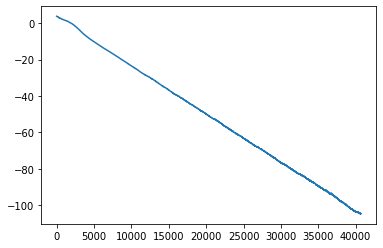

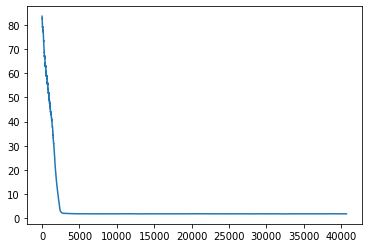

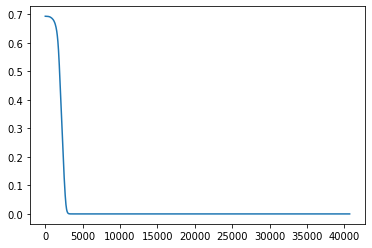

In [12]:
import matplotlib.pyplot as plt
n = 1000
def moving_average(a, k=n):
    ret = np.cumsum(a, dtype=float)
    ret[k:] = ret[k:] - ret[:-k]
    return ret[k - 1:] / k
plt.plot(list(range(len(action_losses)))[:1-n], moving_average(action_losses))
plt.show()
plt.plot(list(range(len(value_losses)))[:1-n], moving_average(value_losses))
plt.show()
plt.plot(list(range(len(dist_entropies)))[:1-n], moving_average(dist_entropies))